In [ ]:
# """
# kf_range_significance.py

# Inputs (edit paths at top):
# - EEG_data_dir: directory of per-subject .npz files with "HFD_features"
# - MRI_csv_path: csv with subject names and group column

# Outputs:
# - prints a summary of significant-state counts per K, empirical p-values from label-permutation null
# - returns a dictionary with full results (if imported)

# Usage (example at bottom).
# """
# import os
# import glob
# import numpy as np
# import pandas as pd
# from sklearn.cluster import KMeans
# from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal, shapiro, levene
# from statsmodels.stats.multitest import multipletests

# # ---------- CONFIG ----------
# EEG_data_dir = "../data/EEG_data/HFD_PSD_4sec_75overlap_6min"
# MRI_csv_path = "../data/MRI_data/ROI_aal3_Vgm.csv_with_groups.csv"
# K_STATES_LIST = list(range(6, 12))  # same as your script
# SEED = 1000
# P_VALUE_THRESHOLD = 0.05
# N_PERM = 1000    # set 500 or 1000 depending on compute budget
# # ----------------------------

# # --- Utilities (kept minimal / fail-fast) ---
# def file_to_sid(path_or_name: str, pad: int = 2) -> str:
#     base = os.path.splitext(os.path.basename(path_or_name))[0]
#     digits = ''.join(ch for ch in base if ch.isdigit())
#     if not digits:
#         if base.startswith("sub-"):
#             tail = ''.join(ch for ch in base.split('-', 1)[1] if ch.isdigit())
#             digits = tail or "0"
#         else:
#             digits = "0"
#     return f"sub-{str(int(digits)).zfill(pad)}"

# def _get_col(df, target_name_lower: str):
#     for c in df.columns:
#         if c.lower() == target_name_lower.lower():
#             return c
#     raise KeyError(f"Column '{target_name_lower}' not found. Available: {list(df.columns)}")

# def choose_statistical_test(groups):
#     # same logic as yours
#     if len(groups) < 2 or any(g.size == 0 for g in groups):
#         return 'None', 1.0, 0.0
#     try:
#         normality_ok = all((len(g) < 3) or (shapiro(g)[1] > 0.05) for g in groups)
#         equal_var_ok = len(groups) <= 1 or (levene(*groups)[1] > 0.05)
#         if normality_ok and equal_var_ok:
#             if len(groups) == 2:
#                 stat, p_val = ttest_ind(*groups)
#                 return 't-test', p_val, stat
#             else:
#                 stat, p_val = f_oneway(*groups)
#                 return 'ANOVA', p_val, stat
#         else:
#             if len(groups) == 2:
#                 stat, p_val = mannwhitneyu(*groups)
#                 return 'Mann-Whitney', p_val, stat
#             else:
#                 stat, p_val = kruskal(*groups)
#                 return 'Kruskal-Wallis', p_val, stat
#     except Exception:
#         return 'None', 1.0, 0.0

# def determine_dominant_group(feature_values, labels):
#     label_to_group = {0: 'N', 1: 'A+P-', 2: 'A+P+'}
#     group_means = {}
#     for lab in np.unique(labels):
#         vals = feature_values[labels == lab]
#         group_means[lab] = np.mean(vals) if len(vals) else np.nan
#     dominant_label = max(group_means, key=group_means.get)
#     return label_to_group.get(dominant_label, str(dominant_label)), group_means

# # ---------- Data loaders ----------
# def load_mri_map(mri_csv_path):
#     df = pd.read_csv(mri_csv_path)
#     # try find columns
#     names_col = _get_col(df, "names") if "names" in [c.lower() for c in df.columns] else df.columns[0]
#     # assume 'group' column exists (as in your script)
#     group_col = _get_col(df, "group")
#     name_series = df[names_col].astype(str)
#     subject_raw = name_series.str.extract(r'(sub-\d+)', expand=False).fillna(
#         name_series.str.replace("_T1w", "", regex=False)
#     )
#     subject_num = subject_raw.str.extract(r'(\d+)', expand=False)
#     df["subject_id"] = subject_num.apply(lambda d: f"sub-{str(int(d)).zfill(2)}" if pd.notna(d) and str(d).isdigit() else np.nan)
#     group_to_label = {'N': 0, 'A+P-': 1, 'A+P+': 2}
#     df["numeric_label"] = df[group_col].map(group_to_label)
#     return df, names_col, group_col

# def load_eeg_windows(feature_dir, risk_group_map):
#     all_features, all_labels, all_sub_ids = [], [], []
#     for npz_path in sorted(glob.glob(os.path.join(feature_dir, "*.npz"))):
#         sid = file_to_sid(npz_path, pad=2)
#         if sid not in risk_group_map:
#             continue
#         label = int(risk_group_map[sid])
#         data = np.load(npz_path, allow_pickle=True)
#         assert "HFD_features" in data, f"HFD_features missing in {npz_path}"
#         hfd = data["HFD_features"]
#         n_windows = hfd.shape[0]
#         subj_num = int(sid.split("-")[1])
#         for w in range(n_windows):
#             all_features.append(hfd[w].flatten())
#             all_labels.append(label)
#             all_sub_ids.append(subj_num)
#     X = np.array(all_features)
#     y = np.array(all_labels)
#     sub_ids = np.array(all_sub_ids)
#     return {"X": X, "y": y, "sub_ids": sub_ids}

# # ---------- Feature computation ----------
# def compute_std_distance_to_centroid_only(X_data, y_data, sub_ids_data, kmeans_model, k_states):
#     assert X_data.ndim == 2
#     centroids = kmeans_model.cluster_centers_
#     all_preds = kmeans_model.predict(X_data)
#     unique_subjects = np.unique(sub_ids_data)
#     subject_features = []
#     for subject in unique_subjects:
#         mask = (sub_ids_data == subject)
#         if not np.any(mask):
#             continue
#         subj_X = X_data[mask]
#         subj_preds = all_preds[mask]
#         subj_label = y_data[mask][0]
#         std_dist = np.full(k_states, np.nan)
#         for s in range(k_states):
#             state_windows = subj_X[subj_preds == s]
#             if state_windows.shape[0] > 0:
#                 distances = np.linalg.norm(state_windows - centroids[s], axis=1)
#                 std_dist[s] = np.std(distances)
#         subject_features.append({
#             'subject_id': subject,
#             'label': subj_label,
#             'std_distance_to_centroid': std_dist
#         })
#     return subject_features

# # ---------- Statistical pipeline ----------
# def test_states_for_matrix(std_distance_matrix, labels, alpha=0.05):
#     """
#     Input:
#       std_distance_matrix: shape [n_subjects, K_states] (may contain nan)
#       labels: subject-level labels array length n_subjects (ints)
#     Returns:
#       per_state_info: list of dicts { 'p_value', 'test', 'significant' }
#     """
#     n_states = std_distance_matrix.shape[1]
#     per_state = []
#     pvals = []
#     for s in range(n_states):
#         vals = std_distance_matrix[:, s]
#         valid_mask = ~np.isnan(vals)
#         if not np.any(valid_mask):
#             per_state.append({'p_value': 1.0, 'test': 'None', 'significant': False})
#             pvals.append(1.0)
#             continue
#         valid_vals = vals[valid_mask]
#         valid_labels = labels[valid_mask]
#         if len(np.unique(valid_labels)) < 2:
#             per_state.append({'p_value': 1.0, 'test': 'None', 'significant': False})
#             pvals.append(1.0)
#             continue
#         groups = [valid_vals[valid_labels == lab] for lab in np.unique(valid_labels)]
#         test_name, p_value, _ = choose_statistical_test(groups)
#         per_state.append({'p_value': p_value, 'test': test_name})
#         pvals.append(p_value)
#     # FDR correction across states for this K
#     reject, pvals_corr, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
#     for i in range(n_states):
#         per_state[i]['p_value_corrected'] = pvals_corr[i]
#         per_state[i]['significant'] = bool(reject[i])
#     return per_state

# # ---------- Higher level: analyze a K list ----------
# def analyze_K_list(eeg_data, K_list, seed=SEED):
#     """
#     Returns dict:
#       results[K] = {
#          'kmeans': model,
#          'subject_features': list-of-dicts,
#          'std_matrix': np.array(n_subj, K),
#          'labels': np.array(n_subj),
#          'per_state': list-of-dicts (with corrected p and significant flag),
#          'n_significant_states': int
#       }
#     """
#     results = {}
#     for K in K_list:
#         X_scaled = eeg_data['X'] / 2.0  # your original scaling
#         kmeans = KMeans(n_clusters=K, random_state=seed, n_init=10, max_iter=300)
#         kmeans.fit(X_scaled)
#         subj_feats = compute_std_distance_to_centroid_only(X_scaled, eeg_data['y'], eeg_data['sub_ids'], kmeans, K)
#         if len(subj_feats) == 0:
#             continue
#         labels = np.array([s['label'] for s in subj_feats])
#         subject_ids = np.array([s['subject_id'] for s in subj_feats])
#         std_matrix = np.vstack([s['std_distance_to_centroid'] for s in subj_feats])
#         per_state = test_states_for_matrix(std_matrix, labels, alpha=P_VALUE_THRESHOLD)
#         n_sig = sum(1 for s in per_state if s.get('significant', False))
#         results[K] = {
#             'kmeans': kmeans,
#             'subject_features': subj_feats,
#             'std_matrix': std_matrix,
#             'labels': labels,
#             'subject_ids': subject_ids,
#             'per_state': per_state,
#             'n_significant_states': n_sig
#         }
#         print(f"K={K}: {n_sig} significant states (after FDR)")
#     return results

# # ---------- Null test: label permutation ----------
# def permutation_test_label_shuffle(eeg_data, K, n_perm=500, seed=SEED):
#     """
#     Permute subject-level labels (shuffle mapping subject_id -> label) and compute
#     #significant states under the same pipeline. Returns observed_count, null_counts array.
#     """
#     # first compute observed
#     X_scaled = eeg_data['X'] / 2.0
#     kmeans = KMeans(n_clusters=K, random_state=seed, n_init=10, max_iter=300)
#     kmeans.fit(X_scaled)
#     subj_feats = compute_std_distance_to_centroid_only(X_scaled, eeg_data['y'], eeg_data['sub_ids'], kmeans, K)
#     if len(subj_feats) == 0:
#         return 0, np.zeros(n_perm, dtype=int)
#     labels = np.array([s['label'] for s in subj_feats])
#     std_matrix = np.vstack([s['std_distance_to_centroid'] for s in subj_feats])
#     per_state = test_states_for_matrix(std_matrix, labels, alpha=P_VALUE_THRESHOLD)
#     observed_count = sum(1 for s in per_state if s.get('significant', False))

#     # Prepare mapping subject_id -> current label and unique subject list
#     subj_ids = np.array([s['subject_id'] for s in subj_feats])
#     unique_subj = np.unique(subj_ids)
#     orig_map = {int(s['subject_id']): int(s['label']) for s in subj_feats}
#     rng = np.random.default_rng(seed)

#     null_counts = np.zeros(n_perm, dtype=int)
#     for i in range(n_perm):
#         perm_labels = rng.permutation([orig_map[s] for s in unique_subj])
#         perm_map = dict(zip(unique_subj, perm_labels))
#         # build permuted window-level labels
#         perm_window_labels = np.array([perm_map[s] for s in subj_ids])
#         # recompute per-state tests using permuted subject labels
#         per_state_perm = test_states_for_matrix(std_matrix, perm_window_labels, alpha=P_VALUE_THRESHOLD)
#         null_counts[i] = sum(1 for s in per_state_perm if s.get('significant', False))
#     # empirical p-value: probability null_count >= observed_count
#     empirical_p = (np.sum(null_counts >= observed_count) + 1) / (n_perm + 1)
#     return observed_count, null_counts, empirical_p

# # ---------- Main runner ----------
# def run_full_analysis():
#     assert os.path.isdir(EEG_data_dir), f"{EEG_data_dir} not found"
#     assert os.path.exists(MRI_csv_path), f"{MRI_csv_path} not found"
#     mri_df, names_col, group_col = load_mri_map(MRI_csv_path)
#     eeg_subjects = {file_to_sid(f) for f in os.listdir(EEG_data_dir) if f.endswith(".npz")}
#     mri_df_eeg = mri_df[mri_df["subject_id"].isin(eeg_subjects)].dropna(subset=["subject_id", "numeric_label"]).copy()
#     risk_group_map = dict(zip(mri_df_eeg["subject_id"], mri_df_eeg["numeric_label"]))
#     eeg_data = load_eeg_windows(EEG_data_dir, risk_group_map)
#     print(f"Windows: {eeg_data['X'].shape[0]}, Subjects: {len(np.unique(eeg_data['sub_ids']))}")

#     # analyze range
#     results = analyze_K_list(eeg_data, K_STATES_LIST, seed=SEED)

#     # run permutation null for each K and summarize
#     summary = {}
#     for K in sorted(results.keys()):
#         print(f"\nRunning permutation null for K={K} (n_perm={N_PERM}) ...")
#         obs_count, null_counts, emp_p = permutation_test_label_shuffle(eeg_data, K, n_perm=N_PERM, seed=SEED)
#         mean_null = null_counts.mean()
#         summary[K] = {'observed_significant_states': int(obs_count),
#                       'mean_null_significant_states': float(mean_null),
#                       'empirical_p': float(emp_p),
#                       'null_counts': null_counts}
#         print(f"K={K}: observed {obs_count}, null mean {mean_null:.2f}, empirical p={emp_p:.4f}")
#     return results, summary

# # --- example usage ---
# if __name__ == "__main__":
#     results, summary = run_full_analysis()
#     # Aggregate: how many Ks had empirical p < 0.05?
#     ks_with_significant_excess = [K for K, s in summary.items() if s['empirical_p'] < 0.05]
#     print("\nK values with empirical p < 0.05 (label-permutation null):", ks_with_significant_excess)


Windows: 23205, Subjects: 65
K=6: 0 significant states (after FDR)
K=7: 0 significant states (after FDR)
K=8: 1 significant states (after FDR)
K=9: 1 significant states (after FDR)
K=10: 0 significant states (after FDR)
K=11: 0 significant states (after FDR)

Running permutation null for K=6 (n_perm=1000) ...
K=6: observed 0, null mean 0.07, empirical p=1.0000

Running permutation null for K=7 (n_perm=1000) ...
K=7: observed 0, null mean 0.05, empirical p=1.0000

Running permutation null for K=8 (n_perm=1000) ...
K=8: observed 1, null mean 0.04, empirical p=0.0380

Running permutation null for K=9 (n_perm=1000) ...
K=9: observed 1, null mean 0.05, empirical p=0.0460

Running permutation null for K=10 (n_perm=1000) ...
K=10: observed 0, null mean 0.05, empirical p=1.0000

Running permutation null for K=11 (n_perm=1000) ...
K=11: observed 0, null mean 0.05, empirical p=1.0000

K values with empirical p < 0.05 (label-permutation null): [8, 9]


In [15]:

import os
import glob
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal, shapiro, levene
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

# Parameters
K_STATES_LIST = list(range(6, 12))
SEED = 1000
P_VALUE_THRESHOLD = 0.05

# Paths
EEG_data_dir = "../data/EEG_data/HFD_PSD_4sec_75overlap_6min"
MRI_csv_path = "../data/MRI_data/ROI_aal3_Vgm.csv_with_groups.csv"

# Output folder for NPZs
NPZ_OUT_DIR = "significant_state_npz"
os.makedirs(NPZ_OUT_DIR, exist_ok=True)

print("="*80)
print("EEG STD_DISTANCE_TO_CENTROID FEATURE ANALYSIS (with NPZ export)")
print("="*80)

# Helper functions
def file_to_sid(path_or_name: str, pad: int = 2) -> str:
    """Convert filename to standardized subject ID"""
    base = os.path.splitext(os.path.basename(path_or_name))[0]
    digits = ''.join(ch for ch in base if ch.isdigit())
    if not digits:
        if base.startswith("sub-"):
            tail = ''.join(ch for ch in base.split('-', 1)[1] if ch.isdigit())
            digits = tail or "0"
        else:
            digits = "0"
    return f"sub-{str(int(digits)).zfill(pad)}"

def _get_col(df, target_name_lower: str):
    """Find column in DataFrame ignoring case"""
    for c in df.columns:
        if c.lower() == target_name_lower:
            return c
    raise KeyError(f"Column '{target_name_lower}' not found. Available: {list(df.columns)}")

def choose_statistical_test(groups):
    """Choose appropriate statistical test"""
    if len(groups) < 2 or any(g.size == 0 for g in groups):
        return 'None', 1.0, 0.0
    try:
        normality_ok = all(shapiro(g)[1] > 0.05 for g in groups if len(g) >= 3)
        equal_var_ok = levene(*groups)[1] > 0.05
        if normality_ok and equal_var_ok:
            if len(groups) == 2:
                stat, p_val = ttest_ind(*groups)
                return 't-test', p_val, stat
            else:
                stat, p_val = f_oneway(*groups)
                return 'ANOVA', p_val, stat
        else:
            if len(groups) == 2:
                stat, p_val = mannwhitneyu(*groups)
                return 'Mann-Whitney', p_val, stat
            else:
                stat, p_val = kruskal(*groups)
                return 'Kruskal-Wallis', p_val, stat
    except Exception:
        return 'None', 1.0, 0.0

def determine_dominant_group(feature_values, labels):
    """Determine which group has highest mean"""
    label_to_group = {0: 'N', 1: 'A+P-', 2: 'A+P+'}
    group_means = {}
    for lab in np.unique(labels):
        vals = feature_values[labels == lab]
        group_means[lab] = np.mean(vals) if len(vals) else np.nan
    dominant_label = max(group_means, key=group_means.get)
    return label_to_group[dominant_label], group_means

# Data loading
print("\nStep 1: Loading subject labels and EEG data")
print("-" * 50)

# Get EEG subjects
eeg_subjects = {file_to_sid(f) for f in os.listdir(EEG_data_dir) if f.endswith(".npz")}
print(f"Found {len(eeg_subjects)} EEG subjects")

# Load MRI labels
mri_df = pd.read_csv(MRI_csv_path)
names_col = _get_col(mri_df, "names")
group_col = _get_col(mri_df, "group")

# Extract subject IDs from names
name_series = mri_df[names_col].astype(str)
subject_raw = name_series.str.extract(r'(sub-\d+)', expand=False).fillna(
    name_series.str.replace("_T1w", "", regex=False)
)
subject_num = subject_raw.str.extract(r'(\d+)', expand=False)
mri_df["subject_id"] = subject_num.apply(
    lambda d: f"sub-{str(int(d)).zfill(2)}" if pd.notna(d) and str(d).isdigit() else np.nan
)

# Create group mappings
group_to_label = {'N': 0, 'A+P-': 1, 'A+P+': 2}
mri_df["numeric_label"] = mri_df[group_col].map(group_to_label)

# Filter to subjects with both EEG and MRI data
mri_df_eeg = mri_df[mri_df["subject_id"].isin(eeg_subjects)].dropna(
    subset=["subject_id", "numeric_label"]
).copy()

risk_group_map = dict(zip(mri_df_eeg["subject_id"], mri_df_eeg["numeric_label"]))

print(f"Subjects with both EEG and MRI labels: {len(risk_group_map)}")
for grp, lab in group_to_label.items():
    cnt = sum(1 for v in risk_group_map.values() if v == lab)
    print(f"  {grp} (label={lab}): {cnt} subjects")

# Create final DataFrame
final_df = mri_df_eeg[["subject_id", group_col, "numeric_label"]].rename(
    columns={group_col: "Risk_Group", "subject_id": "participant_id", "numeric_label": "Group"}
).reset_index(drop=True)

# Load EEG features
def load_eeg_features(feature_dir: str, risk_group_map: dict):
    """Load EEG features for all subjects and windows"""
    all_features, all_labels, all_sub_ids = [], [], []
    
    print("\nLoading EEG window features...")
    for npz_path in glob.glob(os.path.join(feature_dir, "*.npz")):
        sid = file_to_sid(npz_path, pad=2)
        if sid not in risk_group_map:
            continue
            
        label = int(risk_group_map[sid])
        data = np.load(npz_path, allow_pickle=True)
        hfd = data["HFD_features"]
        n_windows = hfd.shape[0]
        subj_num = int(sid.split("-")[1])
        
        for w in range(n_windows):
            all_features.append(hfd[w].flatten())
            all_labels.append(label)
            all_sub_ids.append(subj_num)
        
        print(f"  Loaded {n_windows:4d} windows from {sid} ({['N','A+P-','A+P+'][label]})")
    
    return {
        "X": np.array(all_features),
        "y": np.array(all_labels),
        "sub_ids": np.array(all_sub_ids),
    }

eeg_data = load_eeg_features(EEG_data_dir, risk_group_map)

print(f"\nEEG Data Summary:")
print(f"  Windows: {eeg_data['X'].shape[0]}")
print(f"  Features per window: {eeg_data['X'].shape[1]}")
print(f"  Unique subjects: {len(np.unique(eeg_data['sub_ids']))}")

# store kmeans models and scaled X for retrieval later
kmeans_models = {}
X_scaled_store = {}

# Main analysis function - ONLY std_distance_to_centroid
def compute_std_distance_to_centroid_only(X_data, y_data, sub_ids_data, kmeans_model, k_states):
    """Compute ONLY std_distance_to_centroid for each subject"""
    centroids = kmeans_model.cluster_centers_
    
    # Predict all windows at once
    all_preds = kmeans_model.predict(X_data)
    
    unique_subjects = np.unique(sub_ids_data)
    subject_features = []
    
    for subject in unique_subjects:
        mask = (sub_ids_data == subject)
        if not np.any(mask):
            continue
            
        subj_X = X_data[mask]
        subj_preds = all_preds[mask]
        subj_label = y_data[mask][0]
        
        std_dist = np.full(k_states, np.nan) # Initialize with NaN
        for s in range(k_states): # For each state
            state_windows = subj_X[subj_preds == s] # Windows assigned to state s
            if state_windows.shape[0] > 0: # If there are windows for this state

                #print(f'dimesnion:{state_windows.shape}')
                distances = np.linalg.norm(state_windows - centroids[s], axis=1) # Distances to centroid
                #print(f'dimesnion:{distances.shape}')

                std_dist[s] = np.std(distances) # Std deviation of distances
                # just check variance of features in that state
                #std_dist[s] = state_windows  # np.std(np.std(state_windows, axis=0)) 
                
                # print(std_dist[s].shape)


        subject_features.append({
            'subject_id': subject,
            'label': subj_label,
            'std_distance_to_centroid': std_dist
        })
    
    return subject_features

print("\nStep 2: Feature Engineering and Statistical Testing")
print("-" * 50)

all_significant_features = []
all_features_for_wide = []  # Store ALL features for wide format

for K_STATES in K_STATES_LIST:
    print(f"\nAnalyzing K = {K_STATES}")
    print("-" * 30)
    
    # Fit KMeans - DON'T MODIFY ORIGINAL DATA
    kmeans = KMeans(n_clusters=K_STATES, random_state=SEED, n_init=10, max_iter=300)
    X_scaled = eeg_data['X'] / 2  # Create scaled copy
    kmeans.fit(X_scaled)
    
    # store fitted model & scaled X for NPZ export later
    kmeans_models[K_STATES] = kmeans
    X_scaled_store[K_STATES] = X_scaled
    
    # PCA plot
    # from sklearn.decomposition import PCA
    # import matplotlib.pyplot as plt
    # pca = PCA(n_components=2)
    # X_pca = pca.fit_transform(X_scaled)
    # plt.figure(figsize=(8,6))
    # scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_, cmap='tab10', alpha=0.6)
    # plt.title(f'KMeans Clustering (K={K_STATES}) on EEG Features')
    # plt.xlabel('PCA Component 1')
    # plt.ylabel('PCA Component 2')
    # plt.colorbar(scatter, label='Cluster Label')
    # plt.grid(True)
    # plt.show()



    # Compute std_distance_to_centroid features
    subject_features = compute_std_distance_to_centroid_only(
        X_scaled, eeg_data['y'], eeg_data['sub_ids'], kmeans, K_STATES
    )
    
    if len(subject_features) == 0:
        continue
    
    # Extract labels and feature matrix
    labels = np.array([s['label'] for s in subject_features])
    subject_ids = np.array([s['subject_id'] for s in subject_features])
    std_distance_matrix = np.vstack([s['std_distance_to_centroid'] for s in subject_features])
    
    # Test each state and store ALL features (not just significant ones)
    for state in range(K_STATES):
        vals = std_distance_matrix[:, state]
        feat_name = f"EEG_K{K_STATES}_std_distance_to_centroid_state{state}"
        
        # Store ALL features for wide format
        for subj_id, value in zip(subject_ids, vals):
            all_features_for_wide.append({
                'subject_id_num': subj_id,
                'participant_id': f"sub-{int(subj_id):02d}",
                'feature_name': feat_name,
                'value': value,
                'K': K_STATES,
                'state': state
            })
        
        # Handle NaN values for statistical testing
        valid_mask = ~np.isnan(vals)
        if not np.any(valid_mask):
            continue
            
        valid_vals = vals[valid_mask]
        valid_labels = labels[valid_mask]
        valid_subject_ids = subject_ids[valid_mask]
        
        if len(np.unique(valid_labels)) < 2:
            continue
        
        # Statistical test
        groups = [valid_vals[valid_labels == lab] for lab in np.unique(valid_labels)]
        test_name, p_value, _ = choose_statistical_test(groups)
        
        if p_value < P_VALUE_THRESHOLD:
            dom_group, group_means = determine_dominant_group(valid_vals, valid_labels)
            print(f" ✓ State {state} std_distance: p={p_value:.6f} ({dom_group} higher)")
            
            all_significant_features.append({
                'K': K_STATES,
                'feature_type': 'std_distance_to_centroid',
                'state': state,
                'p_value': p_value,
                'test': test_name,
                'dominant_group': dom_group,
                'group_means': group_means,
                'feature_values': vals,  # Include ALL values (with NaN)
                'subject_ids': subject_ids  # Include ALL subject IDs
            })


# ============================================================================
# POST-HOC PAIRWISE COMPARISONS WITH FAMILY-WISE BONFERRONI
# ============================================================================
from scipy.stats import ttest_ind
import pandas as pd

def bonferroni_posthoc(feature_values, labels, subject_ids, alpha=0.05):
    """
    Perform pairwise comparisons with Bonferroni correction within family
    Returns dict with corrected p-values for each comparison
    """
    from scipy import stats
    
    # Remove NaN values
    valid_mask = ~np.isnan(feature_values)
    vals = feature_values[valid_mask]
    labs = labels[valid_mask]
    
    # Define comparisons
    comparisons = [
        (0, 1, 'N vs A+P-'),
        (0, 2, 'N vs A+P+'),
        (1, 2, 'A+P- vs A+P+')
    ]
    
    results = {}
    bonferroni_alpha = alpha / 3  # Corrected threshold for 3 comparisons
    
    for lab1, lab2, name in comparisons:
        group1 = vals[labs == lab1]
        group2 = vals[labs == lab2]
        
        if len(group1) < 2 or len(group2) < 2:
            results[name] = {
                'p_value': 1.0, 
                'significant': False, 
                'mean_diff': np.nan,
                'ci_lower': np.nan,
                'ci_upper': np.nan,
                'group1_mean': np.nan,
                'group2_mean': np.nan,
                'group1_std': np.nan,
                'group2_std': np.nan,
                'n1': 0,
                'n2': 0
            }
            continue
        
        # Two-sample t-test
        stat, p_val = ttest_ind(group1, group2)
        mean_diff = np.mean(group1) - np.mean(group2)
        
        # Calculate 95% confidence interval for the difference
        n1, n2 = len(group1), len(group2)
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        se_diff = np.sqrt(var1/n1 + var2/n2)
        df = n1 + n2 - 2
        
        # Use t-distribution for CI
        t_crit = stats.t.ppf(0.975, df)  # 95% CI
        ci_lower = mean_diff - t_crit * se_diff
        ci_upper = mean_diff + t_crit * se_diff
        
        results[name] = {
            'p_value': p_val,
            'p_bonferroni': p_val,
            'significant': p_val < bonferroni_alpha,
            'mean_diff': mean_diff,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'group1_mean': np.mean(group1),
            'group2_mean': np.mean(group2),
            'group1_std': np.std(group1),
            'group2_std': np.std(group2),
            'n1': n1,
            'n2': n2
        }
    
    return results, bonferroni_alpha

# Perform post-hoc comparisons for UNCORRECTED significant features
posthoc_results = []

for feat in all_significant_features:
    K = feat['K']
    state = feat['state']
    vals = feat['feature_values']
    subject_ids = feat['subject_ids']
    labels = np.array([risk_group_map.get(f"sub-{int(sid):02d}", -1) for sid in subject_ids])
    
    # Perform pairwise comparisons
    pairwise, bonf_alpha = bonferroni_posthoc(vals, labels, subject_ids)
    
    # Store results
    for comparison, stats in pairwise.items():
        posthoc_results.append({
            'K': K,
            'state': state,
            'comparison': comparison,
            'p_value': stats['p_value'],
            'bonferroni_alpha': bonf_alpha,
            'significant_bonferroni': stats['significant'],
            'mean_diff': stats['mean_diff'],
            'ci_lower': stats['ci_lower'],  # ADD THIS
            'ci_upper': stats['ci_upper'],  # ADD THIS
            'group1_mean': stats.get('group1_mean', np.nan),
            'group2_mean': stats.get('group2_mean', np.nan),
            'group1_std': stats.get('group1_std', np.nan),
            'group2_std': stats.get('group2_std', np.nan),
            'n1': stats.get('n1', 0),
            'n2': stats.get('n2', 0)
        })

# Create DataFrame
posthoc_df = pd.DataFrame(posthoc_results)

EEG STD_DISTANCE_TO_CENTROID FEATURE ANALYSIS (with NPZ export)

Step 1: Loading subject labels and EEG data
--------------------------------------------------
Found 75 EEG subjects
Subjects with both EEG and MRI labels: 65
  N (label=0): 25 subjects
  A+P- (label=1): 23 subjects
  A+P+ (label=2): 17 subjects

Loading EEG window features...
  Loaded  357 windows from sub-13 (N)
  Loaded  357 windows from sub-21 (N)
  Loaded  357 windows from sub-67 (A+P-)
  Loaded  357 windows from sub-59 (A+P-)
  Loaded  357 windows from sub-76 (A+P-)
  Loaded  357 windows from sub-16 (N)
  Loaded  357 windows from sub-57 (A+P-)
  Loaded  357 windows from sub-02 (N)
  Loaded  357 windows from sub-33 (A+P+)
  Loaded  357 windows from sub-39 (A+P+)
  Loaded  357 windows from sub-25 (N)
  Loaded  357 windows from sub-24 (N)
  Loaded  357 windows from sub-26 (N)
  Loaded  357 windows from sub-05 (N)
  Loaded  357 windows from sub-44 (A+P+)
  Loaded  357 windows from sub-37 (A+P+)
  Loaded  357 windows fro

In [18]:
def generate_publication_latex_table(posthoc_df):
    """Generate LaTeX table matching the publication format"""
    
    if len(posthoc_df) == 0:
        print("No post-hoc comparisons to tabulate.")
        return
    
    # Apply FDR correction across ALL pairwise tests
    from statsmodels.stats.multitest import multipletests
    
    p_values = posthoc_df['p_value'].values
    reject, p_fdr, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    
    posthoc_df['p_fdr'] = p_fdr
    posthoc_df['significant_fdr'] = reject
    
    # Filter to only rows with significant comparisons
    sig_rows = posthoc_df[posthoc_df['significant_fdr']].copy()
    
    if len(sig_rows) == 0:
        print("No comparisons remain significant after FDR correction.")
        return
    
    # Get unique (K, state) combinations from significant rows only
    sig_k_state_pairs = sorted(sig_rows[['K', 'state']].drop_duplicates().values.tolist())
    
    print(f"\nK-State pairs with significant comparisons: {sig_k_state_pairs}")
    
    latex = []
    latex.append(r"\begin{table}")
    latex.append(r"\centering")
    latex.append(r"\footnotesize")
    latex.append(r"\caption{FDR-corrected post hoc comparisons of EEG dynamic HFD standard deviation of distance to centroid features across risk groups for states ($K$) with significant differences. Significant pairwise differences ($p <$ .05) are marked with $^{*}$.}")
    latex.append(r"\label{tab:postHocComparisons-EEG}")
    latex.append(r"\begin{tabular}{cllrrrr}")
    latex.append(r"\toprule")
    latex.append(r"\textbf{State} & \textbf{Group 1} & \textbf{Group 2} & \textbf{Diff.} & ")
    latex.append(r"\multicolumn{2}{c}{\textbf{95\% CI}} & \textbf{p$_{\text{FDR}}$} \\")
    latex.append(r"\cmidrule(lr){5-6}")
    latex.append(r" & & & & \textbf{Lower} & \textbf{Upper} & \\")
    latex.append(r"\midrule")
    latex.append("")
    
    # Iterate only over K-state pairs with significant results
    for K, state in sig_k_state_pairs:
        # Get all comparisons for this (K, state)
        k_state_data = posthoc_df[(posthoc_df['K'] == K) & (posthoc_df['state'] == state)].copy()
        
        # Ensure we have all 3 comparisons in correct order
        comparison_order = ['N vs A+P-', 'N vs A+P+', 'A+P- vs A+P+']
        k_state_data['comp_order'] = k_state_data['comparison'].map({c: i for i, c in enumerate(comparison_order)})
        k_state_data = k_state_data.sort_values('comp_order')
        
        # Create state label with state number
        state_label = f"$K$ = {K}, State {state}"
        latex.append(r"\multirow{3}{*}{" + state_label + r"} ")
        
        for idx, (_, row) in enumerate(k_state_data.iterrows()):
            # Mark significance based on FDR-corrected p-value
            sig_marker = "$^*$" if row['significant_fdr'] else ""
            
            # Format numbers
            diff = row['mean_diff']
            ci_lower = row['ci_lower']
            ci_upper = row['ci_upper']
            p_fdr = row['p_fdr']
            
            # Format difference (3 decimal places)
            diff_str = f"{diff:.3f}"
            
            # Format CI bounds (handle negative signs)
            if ci_lower < 0:
                ci_lower_str = f"$-${abs(ci_lower):.3f}"
            else:
                ci_lower_str = f"{ci_lower:.3f}"
            
            if ci_upper < 0:
                ci_upper_str = f"$-${abs(ci_upper):.3f}"
            else:
                ci_upper_str = f"{ci_upper:.3f}"
            
            # Format p-value (2 decimal places)
            p_str = f"{p_fdr:.2f}"
            
            line = f" & {row['comparison'].split(' vs ')[0]} & {row['comparison'].split(' vs ')[1]} & {diff_str} & {ci_lower_str} & {ci_upper_str} & {p_str}{sig_marker} \\\\"
            latex.append(line)
        
        latex.append(r"\cmidrule[0.4pt]{1-7}")
        latex.append("")
    
    # Remove last cmidrule and empty line
    if len(latex) > 2 and latex[-2].startswith(r"\cmidrule"):
        latex = latex[:-2]
    
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\end{table}")
    
    table_str = "\n".join(latex)
    
    # Save to file
    with open('EEG_posthoc_table_publication.tex', 'w') as f:
        f.write(table_str)
    
    print("\n✓ Saved publication-quality LaTeX table: EEG_posthoc_table_publication.tex")
    print(f"✓ K-State pairs with significant comparisons: {len(sig_k_state_pairs)}")
    print(f"✓ Total significant pairwise comparisons: {sum(reject)}/{len(p_values)}")
    
    print("\nTable preview:")
    print(table_str)
    
    return table_str

# Generate the publication table
if len(posthoc_df) > 0:
    generate_publication_latex_table(posthoc_df)


K-State pairs with significant comparisons: [[7, 1], [8, 6], [9, 0], [10, 7]]

✓ Saved publication-quality LaTeX table: EEG_posthoc_table_publication.tex
✓ K-State pairs with significant comparisons: 4
✓ Total significant pairwise comparisons: 5/21

Table preview:
\begin{table}
\centering
\footnotesize
\caption{FDR-corrected post hoc comparisons of EEG dynamic HFD standard deviation of distance to centroid features across risk groups for states ($K$) with significant differences. Significant pairwise differences ($p <$ .05) are marked with $^{*}$.}
\label{tab:postHocComparisons-EEG}
\begin{tabular}{cllrrrr}
\toprule
\textbf{State} & \textbf{Group 1} & \textbf{Group 2} & \textbf{Diff.} & 
\multicolumn{2}{c}{\textbf{95\% CI}} & \textbf{p$_{\text{FDR}}$} \\
\cmidrule(lr){5-6}
 & & & & \textbf{Lower} & \textbf{Upper} & \\
\midrule

\multirow{3}{*}{$K$ = 7, State 1} 
 & N & A+P- & 0.006 & 0.002 & 0.011 & 0.02$^*$ \\
 & N & A+P+ & -0.000 & $-$0.006 & 0.005 & 0.91 \\
 & A+P- & A+P+ & -0.007 

In [3]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def perform_posthoc_comparisons(all_significant_features, labels_map, eeg_data):
    """
    Perform pairwise post-hoc comparisons for significant features
    Values are scaled to [0, 1] for interpretability
    """
    posthoc_results = []
    
    # Filter only features significant after correction
    sig_features = [f for f in all_significant_features if f.get('significant_after_correction', False)]
    
    for feat in sig_features:
        K = feat['K']
        state = feat['state']
        vals = feat['feature_values']
        subject_ids = feat['subject_ids']
        
        # Get labels for subjects
        labels_array = np.array([labels_map.get(f"sub-{int(sid):02d}", -1) for sid in subject_ids])
        
        # Remove NaN and invalid labels
        valid_mask = ~np.isnan(vals) & (labels_array != -1)
        vals_valid = vals[valid_mask]
        labels_array = labels_array[valid_mask]
        
        # Scale to [0, 1] for interpretability
        scaler = MinMaxScaler()
        vals_scaled = scaler.fit_transform(vals_valid.reshape(-1, 1)).flatten()
        
        # Pairwise comparisons
        comparisons = [
            (0, 1, 'N', 'A+P-'),
            (0, 2, 'N', 'A+P+'),
            (1, 2, 'A+P-', 'A+P+')
        ]
        
        for lab1, lab2, name1, name2 in comparisons:
            group1 = vals_scaled[labels_array == lab1]
            group2 = vals_scaled[labels_array == lab2]
            
            if len(group1) < 2 or len(group2) < 2:
                continue
            
            # T-test
            stat, p_val = ttest_ind(group1, group2)
            
            # Calculate difference and CI
            mean_diff = np.mean(group1) - np.mean(group2)
            se_diff = np.sqrt(np.var(group1, ddof=1)/len(group1) + np.var(group2, ddof=1)/len(group2))
            df = len(group1) + len(group2) - 2
            
            # 95% CI
            from scipy import stats
            t_crit = stats.t.ppf(0.975, df)
            ci_lower = mean_diff - t_crit * se_diff
            ci_upper = mean_diff + t_crit * se_diff
            
            posthoc_results.append({
                'K': K,
                'state': state,
                'feature_type': feat['feature_type'],
                'group1': name1,
                'group2': name2,
                'mean_diff': mean_diff,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'df': df,
                'p_value': p_val
            })
    
    return posthoc_results

def generate_latex_table(posthoc_results):
    """
    Generate LaTeX table from post-hoc results - ONLY for significant K values
    """
    if not posthoc_results:
        print("No post-hoc results to generate table.")
        return
    
    # Apply Bonferroni correction
    p_values = [r['p_value'] for r in posthoc_results]
    _, p_bonf, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    
    for i, result in enumerate(posthoc_results):
        result['p_bonf'] = p_bonf[i]
    
    # Group by K and state
    grouped = {}
    for r in posthoc_results:
        key = (r['K'], r['state'])
        if key not in grouped:
            grouped[key] = []
        grouped[key].append(r)
    
    # Filter to only include K values where at least one comparison is significant
    significant_k_states = set()
    for (K, state), results in grouped.items():
        if any(r['p_bonf'] < 0.05 for r in results):
            significant_k_states.add((K, state))
    
    # Generate LaTeX
    latex = []
    latex.append(r"\begin{table}[t]")
    latex.append(r"\centering")
    latex.append(r"\footnotesize")
    latex.append(r"\caption{Bonferroni-corrected post hoc comparisons of EEG std\_distance\_to\_centroid features across risk groups. ")
    latex.append(r"Only K values with significant pairwise differences are shown. ")
    latex.append(r"Values are min-max scaled to [0, 1] for interpretability, where 0 represents the minimum std\_distance and 1 represents the maximum across all subjects for each state. ")
    latex.append(r"Significant differences (p $<$ .05) are marked with $*$.}")
    latex.append(r"\label{tab:postHocComparisons-EEG}")
    latex.append(r"\begin{tabular}{cllrrrrr}")
    latex.append(r"\toprule")
    latex.append(r"\textbf{State} & \textbf{Group 1} & \textbf{Group 2} & \textbf{Diff.} & ")
    latex.append(r"\multicolumn{2}{c}{\textbf{95\% CI}} & \textbf{df} & \textbf{p$_{\text{bonf}}$} \\")
    latex.append(r"\cmidrule(lr){5-6}")
    latex.append(r" & & & & \textbf{Lower} & \textbf{Upper} & & \\")
    latex.append(r"\midrule")
    latex.append("")
    
    for (K, state) in sorted(significant_k_states):
        results = grouped[(K, state)]
        
        latex.append(r"\multirow{3}{*}{K" + str(K) + r"\_S" + str(state) + r"} ")
        
        for i, r in enumerate(results):
            sig_marker = "$^*$" if r['p_bonf'] < 0.05 else ""
            
            # Format values with 3 decimal places
            diff_str = f"{r['mean_diff']:.3f}"
            ci_lower_str = f"{r['ci_lower']:.3f}" if r['ci_lower'] >= 0 else f"$-${abs(r['ci_lower']):.3f}"
            ci_upper_str = f"{r['ci_upper']:.3f}" if r['ci_upper'] >= 0 else f"$-${abs(r['ci_upper']):.3f}"
            p_str = f"{r['p_bonf']:.2f}" if r['p_bonf'] >= 0.01 else f"{r['p_bonf']:.3f}"
            
            line = f" & {r['group1']} & {r['group2']} & {diff_str} & {ci_lower_str} & {ci_upper_str} & {r['df']} & {p_str}{sig_marker} \\\\"
            latex.append(line)
        
        latex.append(r"\cmidrule[0.4pt]{1-8}")
        latex.append("")
    
    # Remove last cmidrule
    if latex[-2].startswith(r"\cmidrule"):
        latex = latex[:-2]
    
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\end{table}")
    
    return "\n".join(latex)

# Run post-hoc analysis
print("\nStep 3: Post-hoc Pairwise Comparisons")
print("-" * 50)

posthoc_results = perform_posthoc_comparisons(all_significant_features, risk_group_map, eeg_data)

print(f"\nGenerated {len(posthoc_results)} pairwise comparisons")

# Generate and save LaTeX table
latex_table = generate_latex_table(posthoc_results)

if latex_table:
    # Save to file
    with open('eeg_posthoc_table.tex', 'w') as f:
        f.write(latex_table)
    
    print("\n✓ Saved LaTeX table: eeg_posthoc_table.tex")
    print("\nLaTeX Table Preview:")
    print("=" * 80)
    print(latex_table)
    print("=" * 80)
    
    # Print summary
    sig_k_states = set((r['K'], r['state']) for r in posthoc_results if r['p_bonf'] < 0.05)
    print(f"\nSignificant K-State combinations: {len(sig_k_states)}")
    for K, state in sorted(sig_k_states):
        print(f"  K={K}, State={state}")


Step 3: Post-hoc Pairwise Comparisons
--------------------------------------------------

Generated 0 pairwise comparisons
No post-hoc results to generate table.


In [5]:


print("\nExporting .npz files for each significant (K, state)...")
if len(significant_results_corrected) == 0:
    print("No significant (K,state) found — nothing to save.")
else:
    # For each significant (K, state) create NPZ with windows per subject that had >=1 window in that state
    for feat in significant_results_corrected:
        K = feat['K']
        state = feat['state']
        # retrieve stored kmeans and scaled X
        if K not in kmeans_models or K not in X_scaled_store:
            print(f"  ! Missing stored model/X for K={K} — skipping")
            continue
        kmeans = kmeans_models[K]
        X_scaled = X_scaled_store[K]
        preds = kmeans.predict(X_scaled)  # assigned states for all windows (scaled)
        
        subj_windows_list = []  # List of arrays (each subject can have different number of windows)
        subj_labels = []
        subj_partids = []
        
        # iterate unique subject numeric ids present in eeg_data
        unique_subjs = np.unique(eeg_data['sub_ids'])
        for subj in unique_subjs:
            mask = (eeg_data['sub_ids'] == subj) & (preds == state)
            if not np.any(mask):
                continue
            
            # Get original (unscaled) windows for this subject and state
            subj_windows = eeg_data['X'][mask]  # shape (n_win_subj_state, D)
            
            # Reshape back to (n_windows, 127, 5) from flattened (n_windows, 635)
            n_windows_for_state = subj_windows.shape[0]
            subj_windows_reshaped = subj_windows.reshape(n_windows_for_state, 127, 5)
            
            # Store as list element (since subjects have different numbers of windows)
            subj_windows_list.append(subj_windows_reshaped)
            
            pid = f"sub-{int(subj):02d}"
            # fail-fast: ensure pid exists in risk_group_map
            if pid not in risk_group_map:
                raise ValueError(f"Participant id {pid} not found in risk_group_map (expected).")
            subj_partids.append(pid)
            subj_labels.append(int(risk_group_map[pid]))
        
        if len(subj_windows_list) == 0:
            print(f"  - (K={K}, state={state}): no subjects assigned -> skipping .npz")
            continue
        
        # Convert to numpy arrays
        labels_out = np.array(subj_labels, dtype=int)
        partids_out = np.array(subj_partids, dtype=object)
        
        # Save as object array to handle variable window counts per subject
        X_subjects_windows = np.array(subj_windows_list, dtype=object)
        
        out_name = f"significant_K{K}_state{state}.npz"
        out_path = os.path.join(NPZ_OUT_DIR, out_name)
        np.savez_compressed(out_path,
                            X_subjects_windows=X_subjects_windows,  # List of arrays (n_windows, 127, 5) per subject
                            labels=labels_out,
                            participant_ids=partids_out,
                            K=np.int32(K),
                            state=np.int32(state))
        
        # Print info about windows per subject
        window_counts = [windows.shape[0] for windows in subj_windows_list]
        total_windows = sum(window_counts)
        print(f"  ✓ Saved {out_path}")
        print(f"    Subjects: {len(subj_windows_list)}, Total windows: {total_windows}")
        print(f"    Windows per subject: min={min(window_counts)}, max={max(window_counts)}, mean={np.mean(window_counts):.1f}")

print("\nDone exporting NPZs. (Script does not modify other outputs.)")


Exporting .npz files for each significant (K, state)...
  ✓ Saved significant_state_npz/significant_K7_state1.npz
    Subjects: 65, Total windows: 3617
    Windows per subject: min=3, max=215, mean=55.6
  ✓ Saved significant_state_npz/significant_K8_state6.npz
    Subjects: 65, Total windows: 3226
    Windows per subject: min=1, max=228, mean=49.6
  ✓ Saved significant_state_npz/significant_K9_state0.npz
    Subjects: 65, Total windows: 3109
    Windows per subject: min=1, max=213, mean=47.8
  ✓ Saved significant_state_npz/significant_K10_state7.npz
    Subjects: 65, Total windows: 2737
    Windows per subject: min=1, max=172, mean=42.1
  ✓ Saved significant_state_npz/significant_K10_state8.npz
    Subjects: 65, Total windows: 2406
    Windows per subject: min=1, max=172, mean=37.0
  ✓ Saved significant_state_npz/significant_K11_state5.npz
    Subjects: 61, Total windows: 2544
    Windows per subject: min=1, max=136, mean=41.7
  ✓ Saved significant_state_npz/significant_K11_state7.npz

(3109, 127, 5)

In [17]:
# files
import os 
import numpy as np
import mne

def infer_region_from_name(ch_name: str) -> str:
    """
    Heuristic mapping from name prefix -> region.
    Rules:
      - 'FP', 'AF', 'F', 'FC', 'FT' -> Frontal
      - 'T', 'TP' -> Temporal
      - 'C', 'CP' -> Central
      - 'P', 'PO' -> Parietal
      - 'O' -> Occipital
    If none match, scan for presence of F/T/C/P/O in that priority order.
    Final fallback: 'Frontal' (should be rare).
    """
    s = extract_alpha_prefix(ch_name)
    if not s:
        return "Frontal"
    # Specific prefix checks (order matters)
    if s.startswith(("FP", "AF", "FC", "FT")) or s.startswith("F"):
        return "Frontal"
    if s.startswith(("TP",)) or s.startswith("T"):
        return "Temporal"
    if s.startswith(("CP",)) or s.startswith("C"):
        return "Central"
    if s.startswith(("PO",)) or s.startswith("P"):
        return "Parietal"
    if s.startswith("O"):
        return "Occipital"
    # Fallback: search for letters with priority
    for ch, region in (('F', 'Frontal'), ('T', 'Temporal'),
                       ('C', 'Central'), ('P', 'Parietal'), ('O', 'Occipital')):
        if ch in s:
            return region
    return "Frontal"

def extract_alpha_prefix(ch_name: str) -> str:
    """Return the leading letters in the channel name (uppercased)."""
    letters = ''.join([c for c in ch_name if c.isalpha()])
    return letters.upper()

files = "significant_state_npz"

files = os.listdir(files)
print(files)


path = "/data/s.dharia-ra/PEARL/original_data/sub-01/eeg/sub-01_task-rest_eeg.vhdr"
raw = mne.io.read_raw_brainvision(path, preload=True, verbose=False)
ch_names = raw.info['ch_names']
print(len(ch_names))  #127 channels

N = []
A_plus_P_minus = []
A_plus_P_plus = []

for file in files:
    data = np.load(os.path.join("significant_state_npz", file), allow_pickle=True)
    print(data.files)
    u_labels, counts = np.unique(data['labels'], return_counts=True) 
    print(file, u_labels, counts)
    s_windows = data['X_subjects_windows']
    # print('subjects',s_windows.shape)  
    labels = data['labels']

    # print(s_windows[0].shape)

    
    centroid = np.mean(np.vstack(s_windows), axis=0, keepdims=True)  #(1, n_channels, n_features)


    for i in range(s_windows.shape[0]):  #iterate over subjects
        subject_windows = s_windows[i]  # (n_windows, n_channels, n_features)

    
        # print(subject_windows.shape)
        subject_label = labels[i]
        # print(f"Subject {i} with label {subject_label} has {subject_windows.shape[0]} windows.")
        if subject_label == 0:
            N.append( (subject_windows - centroid)**2)
        elif subject_label == 1:
            A_plus_P_minus.append( (subject_windows - centroid)**2)
        elif subject_label == 2:
            A_plus_P_plus.append( (subject_windows - centroid)**2)
 

['significant_K10_state8.npz', 'significant_K7_state1.npz', 'significant_K11_state5.npz', 'significant_K8_state6.npz', 'significant_K11_state7.npz', 'significant_K10_state7.npz', 'significant_K9_state0.npz']
127
['X_subjects_windows', 'labels', 'participant_ids', 'K', 'state']
significant_K10_state8.npz [0 1 2] [25 23 17]
['X_subjects_windows', 'labels', 'participant_ids', 'K', 'state']
significant_K7_state1.npz [0 1 2] [25 23 17]
['X_subjects_windows', 'labels', 'participant_ids', 'K', 'state']
significant_K11_state5.npz [0 1 2] [23 21 17]
['X_subjects_windows', 'labels', 'participant_ids', 'K', 'state']
significant_K8_state6.npz [0 1 2] [25 23 17]
['X_subjects_windows', 'labels', 'participant_ids', 'K', 'state']
significant_K11_state7.npz [0 1 2] [25 23 17]
['X_subjects_windows', 'labels', 'participant_ids', 'K', 'state']
significant_K10_state7.npz [0 1 2] [25 23 17]
['X_subjects_windows', 'labels', 'participant_ids', 'K', 'state']
significant_K9_state0.npz [0 1 2] [25 23 17]


In [18]:
# import numpy as np
# import pandas as pd
# from scipy.stats import f_oneway, kruskal, shapiro, levene
# import matplotlib.pyplot as plt
# import seaborn as sns
# from collections import defaultdict

# def analyze_regional_differences(N_list, A_plus_P_minus_list, A_plus_P_plus_list, ch_names):
#     """
#     Analyze which brain regions show significant differences between groups
#     Analyzes each subject individually, then summarizes overall findings
#     """
    
#     # Step 1: Map channels to regions
#     print("Step 1: Mapping channels to brain regions...")
#     channel_to_region = {}
#     region_channels = defaultdict(list)
    
#     for i, ch_name in enumerate(ch_names):
#         region = infer_region_from_name(ch_name)
#         channel_to_region[i] = region
#         region_channels[region].append(i)
    
#     print(f"Found {len(region_channels)} regions:")
#     for region, channels in region_channels.items():
#         print(f"  {region}: {len(channels)} channels")
    
#     band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    
#     # Step 2: Analyze each subject and collect regional averages
#     print("\nStep 2: Analyzing each subject...")
    
#     # Store regional averages per subject: {region: {band: {'N': [], 'A+P-': [], 'A+P+': []}}}
#     regional_subject_data = defaultdict(lambda: defaultdict(lambda: {'N': [], 'A+P-': [], 'A+P+': []}))
    
#     # Process N group subjects
#     print(f"\nProcessing {len(N_list)} subjects in N group...")
#     for subj_idx, subject_data in enumerate(N_list):
#         # subject_data shape: (n_windows, n_channels, n_features)
#         # Average across windows for this subject
#         subject_avg = subject_data # np.mean(subject_data, axis=0)  # (n_channels, n_features)
        
 
#         # For each region and band, calculate average
#         for region, channel_indices in region_channels.items():
#             for band_idx in range(subject_avg.shape[2]):
#                 band_name = band_names[band_idx] if band_idx < len(band_names) else f'band_{band_idx}'
#                 totalW = subject_avg.shape[0] 
#                 region_band_avg = np.sqrt( np.sum(subject_avg[:, channel_indices, band_idx].reshape(totalW, -1), axis=1) )  # sum over channels, keep windows

#                 # print( 'aaaaaa', region_band_avg.shape )

#                 regional_subject_data[region][band_name]['N'].append( np.std(region_band_avg ) )
    
#     # Process A+P- group subjects
#     print(f"Processing {len(A_plus_P_minus_list)} subjects in A+P- group...")
#     for subj_idx, subject_data in enumerate(A_plus_P_minus_list):
#         subject_avg = subject_data # np.mean(subject_data, axis=0)
        
#         for region, channel_indices in region_channels.items():
#             for band_idx in range(subject_avg.shape[2]):
#                 band_name = band_names[band_idx] if band_idx < len(band_names) else f'band_{band_idx}'
#                 totalW = subject_avg.shape[0] 
#                 region_band_avg = np.sqrt( np.sum(subject_avg[:, channel_indices, band_idx].reshape(totalW, -1), axis=1) )  # sum over channels, keep windows

#                 # print( 'aaaaaa', region_band_avg.shape )

#                 regional_subject_data[region][band_name]['A+P-'].append( np.std(region_band_avg, axis=0) )
    
#     # Process A+P+ group subjects
#     print(f"Processing {len(A_plus_P_plus_list)} subjects in A+P+ group...")
#     for subj_idx, subject_data in enumerate(A_plus_P_plus_list):
#         subject_avg = subject_data # np.mean(subject_data, axis=0)
        
#         for region, channel_indices in region_channels.items():
#             for band_idx in range(subject_avg.shape[2]):
#                 band_name = band_names[band_idx] if band_idx < len(band_names) else f'band_{band_idx}'
#                 totalW = subject_avg.shape[0] 
#                 region_band_avg = np.sqrt( np.sum(subject_avg[:, channel_indices, band_idx].reshape(totalW, -1), axis=1) )  # sum over channels, keep windows

#                 # print( 'aaaaaa', subject_avg[:, channel_indices, band_idx].reshape(totalW, -1).shape )
                
#                 regional_subject_data[region][band_name]['A+P+'].append( np.std(region_band_avg, axis=0) )
    
#     # Step 3: Summarize overall findings
#     print("\nStep 3: Summarizing overall findings...")
    
#     regional_results = {}
    
#     for region in regional_subject_data.keys():
#         regional_results[region] = {}
        
#         for band in regional_subject_data[region].keys():
#             n_values = np.array(regional_subject_data[region][band]['N'])
#             apm_values = np.array(regional_subject_data[region][band]['A+P-'])
#             app_values = np.array(regional_subject_data[region][band]['A+P+'])
            
#             regional_results[region][band] = {
#                 'N_mean': np.mean(n_values),
#                 'N_std': np.std(n_values),
#                 'N_values': n_values,
#                 'A+P-_mean': np.mean(apm_values),
#                 'A+P-_std': np.std(apm_values),
#                 'A+P-_values': apm_values,
#                 'A+P+_mean': np.mean(app_values),
#                 'A+P+_std': np.std(app_values),
#                 'A+P+_values': app_values,
#                 'N_n': len(n_values),
#                 'A+P-_n': len(apm_values),
#                 'A+P+_n': len(app_values)
#             }
    
#     return regional_results, region_channels

# def statistical_testing(regional_results):
#     """
#     Perform statistical testing for regional differences
#     """
#     print("\nStep 4: Statistical testing for regional differences...")
    
#     significant_results = []
    
#     for region, bands_data in regional_results.items():
#         for band, values in bands_data.items():
#             # Get subject-level values for each group
#             n_vals = values['N_values']
#             apm_vals = values['A+P-_values']
#             app_vals = values['A+P+_values']
            
#             # Perform statistical test
#             groups = [n_vals, apm_vals, app_vals]
            
#             # Check normality and equal variance
#             normality_ok = all(shapiro(group)[1] > 0.05 for group in groups if len(group) >= 3)
#             equal_var_ok = levene(*groups)[1] > 0.05
            
#             if normality_ok and equal_var_ok:
#                 stat, p_value = f_oneway(*groups)
#                 test_name = 'ANOVA'
#             else:
#                 stat, p_value = kruskal(*groups)
#                 test_name = 'Kruskal-Wallis'
            
#             # Find which group has highest mean
#             means = {
#                 'N': values['N_mean'],
#                 'A+P-': values['A+P-_mean'],
#                 'A+P+': values['A+P+_mean']
#             }
#             highest_group = max(means, key=means.get)
            
#             result = {
#                 'region': region,
#                 'band': band,
#                 'p_value': p_value,
#                 'test': test_name,
#                 'highest_group': highest_group,
#                 'N_mean': means['N'],
#                 'N_std': values['N_std'],
#                 'N_n': values['N_n'],
#                 'A+P-_mean': means['A+P-'],
#                 'A+P-_std': values['A+P-_std'],
#                 'A+P-_n': values['A+P-_n'],
#                 'A+P+_mean': means['A+P+'],
#                 'A+P+_std': values['A+P+_std'],
#                 'A+P+_n': values['A+P+_n'],
#                 'effect_size': stat
#             }
            
#             significant_results.append(result)
            
#             # Print significant results
#             if p_value < 0.05:
#                 print(f"  ✓ {region} {band}: p={p_value:.6f} ({highest_group} highest, {test_name})")
#                 print(f"     N: {means['N']:.4f}±{values['N_std']:.4f} (n={values['N_n']})")
#                 print(f"     A+P-: {means['A+P-']:.4f}±{values['A+P-_std']:.4f} (n={values['A+P-_n']})")
#                 print(f"     A+P+: {means['A+P+']:.4f}±{values['A+P+_std']:.4f} (n={values['A+P+_n']})")
    
#     return significant_results

# def create_visualization(significant_results, region_channels):
#     """
#     Create visualizations of the results
#     """
#     print("\nStep 5: Creating visualizations...")
    
#     # Filter significant results
#     sig_results = [r for r in significant_results if r['p_value'] < 0.05]
    
#     if len(sig_results) == 0:
#         print("No significant results to visualize.")
#         return None
    
#     # Create DataFrame for plotting
#     df_plot = pd.DataFrame(sig_results)
    
#     # 1. Heatmap of p-values by region and band
#     pivot_p = df_plot.pivot(index='region', columns='band', values='p_value')
    
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(pivot_p, annot=True, cmap='viridis', fmt='.4f', 
#                 cbar_kws={'label': 'p-value'})
#     plt.title('Statistical Significance by Brain Region and Frequency Band\n(Lower values = more significant)')
#     plt.tight_layout()
#     plt.savefig('regional_significance_heatmap.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     # 2. Bar plot of most significant regions
#     df_plot_sorted = df_plot.sort_values('p_value').head(20)
    
#     plt.figure(figsize=(15, 8))
#     bars = plt.bar(range(len(df_plot_sorted)), -np.log10(df_plot_sorted['p_value']))
#     plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
#     plt.xlabel('Region-Band Combinations')
#     plt.ylabel('-log10(p-value)')
#     plt.title('Most Significant Regional Differences (Top 20)')
#     plt.xticks(range(len(df_plot_sorted)), 
#                [f"{row['region']}\n{row['band']}" for _, row in df_plot_sorted.iterrows()], 
#                rotation=45, ha='right')
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig('top_significant_regions.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     # 3. Summary by region
#     region_summary = df_plot.groupby('region').agg({
#         'p_value': ['count', 'min', 'mean'],
#         'highest_group': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'N/A'
#     }).round(4)
    
#     print("\nRegional Summary:")
#     print("="*60)
#     print(region_summary)
    
#     return df_plot

# # Run the analysis
# print("="*80)
# print("REGIONAL BRAIN ANALYSIS OF EEG MICROSTATE DIFFERENCES")
# print("="*80)

# # Get channel names
# path = "/data/s.dharia-ra/PEARL/original_data/sub-01/eeg/sub-01_task-rest_eeg.vhdr"
# raw = mne.io.read_raw_brainvision(path, preload=True, verbose=False)
# ch_names = raw.info['ch_names']

# # Run analysis with lists (N, A_plus_P_minus, A_plus_P_plus are lists of arrays)
# regional_results, region_channels = analyze_regional_differences(
#     N, A_plus_P_minus, A_plus_P_plus, ch_names
# )

# # Statistical testing
# significant_results = statistical_testing(regional_results)

# # p value correction
# from statsmodels.stats.multitest import multipletests
# if significant_results:
#     p_values = [res['p_value'] for res in significant_results]
#     reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    
#     for i, res in enumerate(significant_results):
#         res['p_value_corrected'] = pvals_corrected[i]
#         res['significant_after_correction'] = reject[i]
    
#     print("\nCorrected p-values using FDR-BH:")
#     for res in significant_results:
#         sig_marker = "✓" if res['significant_after_correction'] else "✗"
#         print(f" {sig_marker} {res['region']} {res['band']}: corrected p={res['p_value_corrected']:.6f}")
# else:
#     print("\nNo significant results found to correct.")

# # create a new dataframe with only significant results after correction
# significant_results = [res for res in significant_results if res.get('significant_after_correction', False)]
# significant_results_corrected = significant_results
# # Create visualizations
# df_results = create_visualization(significant_results, region_channels)

# # Save detailed results
# df_all_results = pd.DataFrame(significant_results)
# df_all_results.to_csv('regional_statistical_results.csv', index=False)
# print(f"\n✓ Saved detailed results: regional_statistical_results.csv")

# # Print summary
# sig_count = len([r for r in significant_results if r['p_value'] < 0.05])
# print(f"\n" + "="*80)
# print(f"SUMMARY: Found {sig_count} significant region-band combinations (p < 0.05)")
# print(f"Total tested: {len(significant_results)}")
# print("="*80)

In [19]:
len(N)

173

REGIONAL BRAIN ANALYSIS OF EEG VARIABILITY DIFFERENCES
Step 1: Mapping channels to brain regions...
Found 5 regions:
  Frontal: 54 channels
  Central: 26 channels
  Temporal: 12 channels
  Parietal: 28 channels
  Occipital: 7 channels

Step 2: Analyzing each subject's variability (std)...

Processing 173 subjects in N group...
Processing 159 subjects in A+P- group...
Processing 119 subjects in A+P+ group...

Step 3: Summarizing overall findings...
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
sssssssssssssssssss (173,)
ssssssss

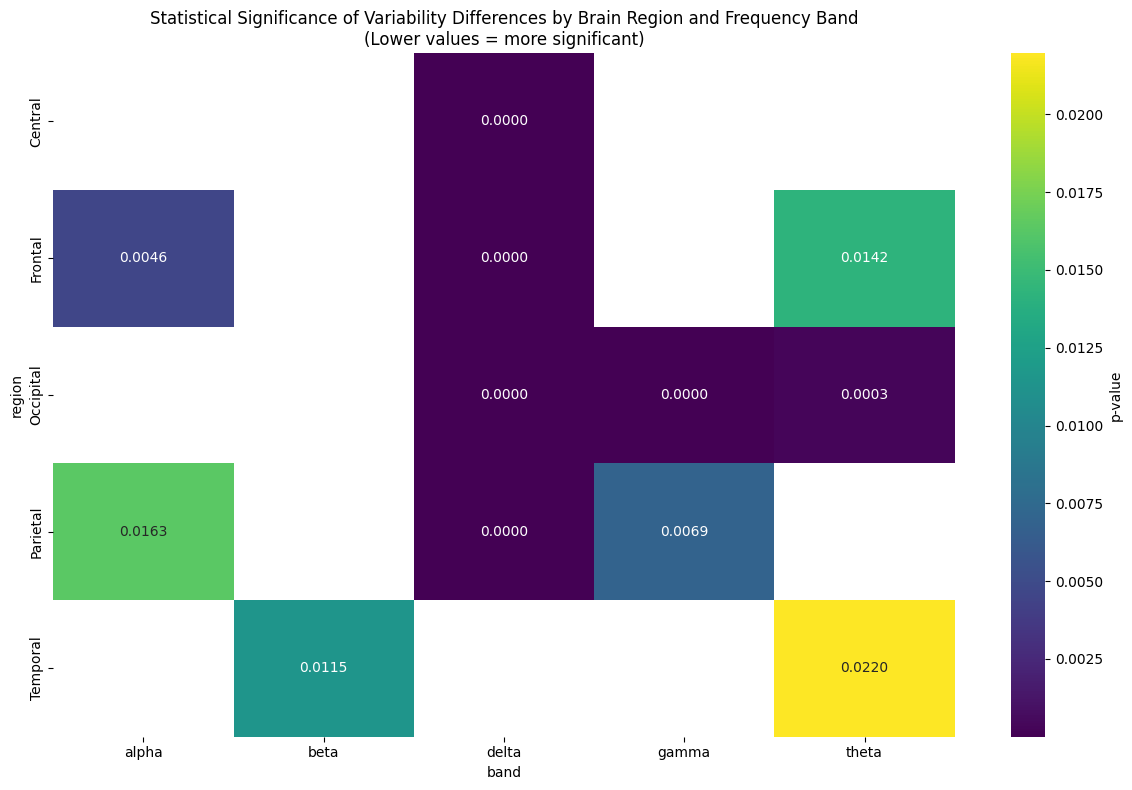

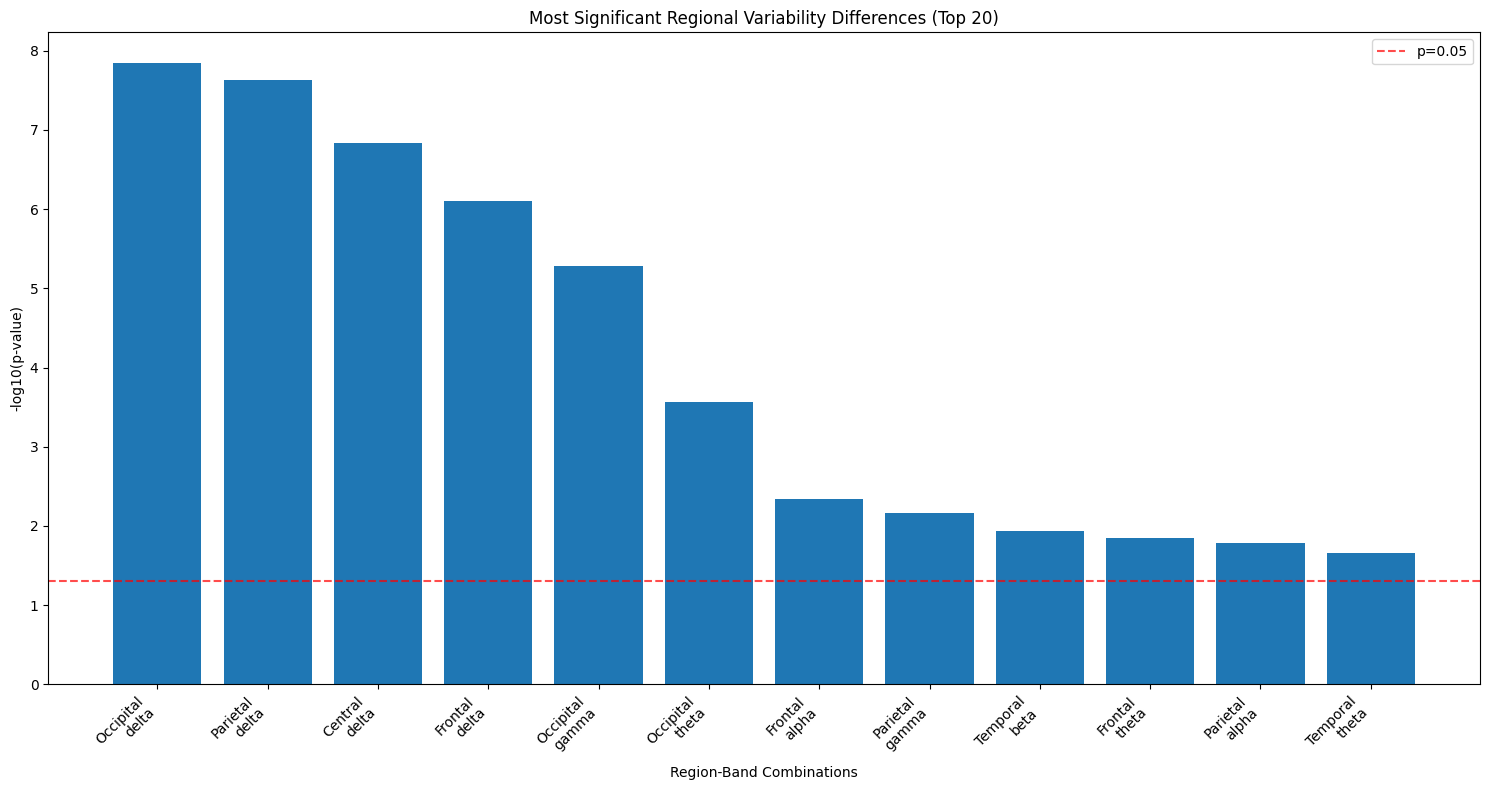


Regional Summary:
          p_value                 highest_variability_group
            count     min    mean                  <lambda>
region                                                     
Central         1  0.0000  0.0000                         N
Frontal         3  0.0000  0.0063                         N
Occipital       3  0.0000  0.0001                      A+P-
Parietal        3  0.0000  0.0077                         N
Temporal        2  0.0115  0.0167                      A+P-

✓ Saved detailed results: regional_variability_statistical_results.csv

SUMMARY: Found 12 significant region-band combinations after FDR correction
Total tested: 25


In [20]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, kruskal, shapiro, levene
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def analyze_regional_differences(N_list, A_plus_P_minus_list, A_plus_P_plus_list, ch_names):
    """
    Analyze which brain regions show significant differences in VARIABILITY (std) between groups
    Analyzes each subject's std individually, then compares across groups
    """
    
    # Step 1: Map channels to regions
    print("Step 1: Mapping channels to brain regions...")
    channel_to_region = {}
    region_channels = defaultdict(list)
    
    for i, ch_name in enumerate(ch_names):
        region = infer_region_from_name(ch_name)
        channel_to_region[i] = region
        region_channels[region].append(i)
    
    print(f"Found {len(region_channels)} regions:")
    for region, channels in region_channels.items():
        print(f"  {region}: {len(channels)} channels")
    
    band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    
    # Step 2: Analyze each subject's VARIABILITY and collect regional averages
    print("\nStep 2: Analyzing each subject's variability (std)...")
    
    # Store regional std per subject: {region: {band: {'N': [], 'A+P-': [], 'A+P+': []}}}
    regional_subject_data = defaultdict(lambda: defaultdict(lambda: {'N': [], 'A+P-': [], 'A+P+': []}))
    
    # Process N group subjects
    print(f"\nProcessing {len(N_list)} subjects in N group...")
    for subj_idx, subject_data in enumerate(N_list):
        # subject_data shape: (n_windows, n_channels, n_features)
        # Average across windows for this subject
        subject_avg = subject_data # np.mean(subject_data, axis=0)  # (n_channels, n_features)
        
 
        # For each region and band, calculate average
        for region, channel_indices in region_channels.items():
            for band_idx in range(subject_avg.shape[2]):
                band_name = band_names[band_idx] if band_idx < len(band_names) else f'band_{band_idx}'
                totalW = subject_avg.shape[0] 
                region_band_avg = np.sqrt( np.sum(subject_avg[:, channel_indices, band_idx].reshape(totalW, -1), axis=1) )  # sum over channels, keep windows

                # print( 'aaaaaa', region_band_avg.shape )

                regional_subject_data[region][band_name]['N'].append( np.std(region_band_avg ) )
    
    # Process A+P- group subjects
    print(f"Processing {len(A_plus_P_minus_list)} subjects in A+P- group...")
    for subj_idx, subject_data in enumerate(A_plus_P_minus_list):
        subject_avg = subject_data # np.mean(subject_data, axis=0)
        
        for region, channel_indices in region_channels.items():
            for band_idx in range(subject_avg.shape[2]):
                band_name = band_names[band_idx] if band_idx < len(band_names) else f'band_{band_idx}'
                totalW = subject_avg.shape[0] 
                region_band_avg = np.sqrt( np.sum(subject_avg[:, channel_indices, band_idx].reshape(totalW, -1), axis=1) )  # sum over channels, keep windows

           

                regional_subject_data[region][band_name]['A+P-'].append( np.std(region_band_avg, axis=0) )
              
    
    # Process A+P+ group subjects
    print(f"Processing {len(A_plus_P_plus_list)} subjects in A+P+ group...")
    for subj_idx, subject_data in enumerate(A_plus_P_plus_list):
        subject_avg = subject_data # np.mean(subject_data, axis=0)
        
        for region, channel_indices in region_channels.items():
            for band_idx in range(subject_avg.shape[2]):
                band_name = band_names[band_idx] if band_idx < len(band_names) else f'band_{band_idx}'
                totalW = subject_avg.shape[0] 
                region_band_avg = np.sqrt( np.sum(subject_avg[:, channel_indices, band_idx].reshape(totalW, -1), axis=1) )  # sum over channels, keep windows

                # print( 'aaaaaa', subject_avg[:, channel_indices, band_idx].reshape(totalW, -1).shape )
                
                regional_subject_data[region][band_name]['A+P+'].append( np.std(region_band_avg, axis=0) )
    
    # Step 3: Summarize overall findings
    print("\nStep 3: Summarizing overall findings...")
    
    regional_results = {}
    
    for region in regional_subject_data.keys():
        regional_results[region] = {}
        
        for band in regional_subject_data[region].keys():
            n_values = np.array(regional_subject_data[region][band]['N'])
            apm_values = np.array(regional_subject_data[region][band]['A+P-'])
            app_values = np.array(regional_subject_data[region][band]['A+P+'])

            print('sssssssssssssssssss', n_values.shape)
            
            regional_results[region][band] = {
                'N_mean_std': np.mean(n_values),  # mean of stds
                'N_std_of_std': np.std(n_values),  # std of stds
                'N_values': n_values,
                'A+P-_mean_std': np.mean(apm_values),
                'A+P-_std_of_std': np.std(apm_values),
                'A+P-_values': apm_values,
                'A+P+_mean_std': np.mean(app_values),
                'A+P+_std_of_std': np.std(app_values),
                'A+P+_values': app_values,
                'N_n': len(n_values),
                'A+P-_n': len(apm_values),
                'A+P+_n': len(app_values)
            }
    
    return regional_results, region_channels

def statistical_testing(regional_results):
    """
    Perform statistical testing for regional differences in VARIABILITY
    """
    print("\nStep 4: Statistical testing for regional differences in STD...")
    
    significant_results = []
    
    for region, bands_data in regional_results.items():
        for band, values in bands_data.items():
            # Get subject-level STD values for each group
            n_vals = values['N_values']
            apm_vals = values['A+P-_values']
            app_vals = values['A+P+_values']
            
            # Perform statistical test
            groups = [n_vals, apm_vals, app_vals]
            
            # Check normality and equal variance
            normality_ok = all(shapiro(group)[1] > 0.05 for group in groups if len(group) >= 3)
            equal_var_ok = levene(*groups)[1] > 0.05
            
            if normality_ok and equal_var_ok:
                stat, p_value = f_oneway(*groups)
                test_name = 'ANOVA'
            else:
                stat, p_value = kruskal(*groups)
                test_name = 'Kruskal-Wallis'
            
            # Find which group has highest mean STD (highest variability)
            means = {
                'N': values['N_mean_std'],
                'A+P-': values['A+P-_mean_std'],
                'A+P+': values['A+P+_mean_std']
            }
            highest_group = max(means, key=means.get)
            
            result = {
                'region': region,
                'band': band,
                'p_value': p_value,
                'test': test_name,
                'highest_variability_group': highest_group,
                'N_mean_std': means['N'],
                'N_std_of_std': values['N_std_of_std'],
                'N_n': values['N_n'],
                'A+P-_mean_std': means['A+P-'],
                'A+P-_std_of_std': values['A+P-_std_of_std'],
                'A+P-_n': values['A+P-_n'],
                'A+P+_mean_std': means['A+P+'],
                'A+P+_std_of_std': values['A+P+_std_of_std'],
                'A+P+_n': values['A+P+_n'],
                'effect_size': stat
            }
            
            significant_results.append(result)
            
            # Print significant results
            if p_value < 0.05:
                print(f"  ✓ {region} {band}: p={p_value:.6f} ({highest_group} highest variability, {test_name})")
                print(f"     N variability: {means['N']:.4f}±{values['N_std_of_std']:.4f} (n={values['N_n']})")
                print(f"     A+P- variability: {means['A+P-']:.4f}±{values['A+P-_std_of_std']:.4f} (n={values['A+P-_n']})")
                print(f"     A+P+ variability: {means['A+P+']:.4f}±{values['A+P+_std_of_std']:.4f} (n={values['A+P+_n']})")
    
    return significant_results

def create_visualization(significant_results, region_channels):
    """
    Create visualizations of the results
    """
    print("\nStep 5: Creating visualizations...")
    
    # Filter significant results
    sig_results = [r for r in significant_results if r['p_value'] < 0.05]
    
    if len(sig_results) == 0:
        print("No significant results to visualize.")
        return None
    
    # Create DataFrame for plotting
    df_plot = pd.DataFrame(sig_results)
    
    # 1. Heatmap of p-values by region and band
    pivot_p = df_plot.pivot(index='region', columns='band', values='p_value')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_p, annot=True, cmap='viridis', fmt='.4f', 
                cbar_kws={'label': 'p-value'})
    plt.title('Statistical Significance of Variability Differences by Brain Region and Frequency Band\n(Lower values = more significant)')
    plt.tight_layout()
    plt.savefig('regional_variability_significance_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Bar plot of most significant regions
    df_plot_sorted = df_plot.sort_values('p_value').head(20)
    
    plt.figure(figsize=(15, 8))
    bars = plt.bar(range(len(df_plot_sorted)), -np.log10(df_plot_sorted['p_value']))
    plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
    plt.xlabel('Region-Band Combinations')
    plt.ylabel('-log10(p-value)')
    plt.title('Most Significant Regional Variability Differences (Top 20)')
    plt.xticks(range(len(df_plot_sorted)), 
               [f"{row['region']}\n{row['band']}" for _, row in df_plot_sorted.iterrows()], 
               rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('top_significant_variability_regions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Summary by region
    region_summary = df_plot.groupby('region').agg({
        'p_value': ['count', 'min', 'mean'],
        'highest_variability_group': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'N/A'
    }).round(4)
    
    print("\nRegional Summary:")
    print("="*60)
    print(region_summary)
    
    return df_plot

# Run the analysis
print("="*80)
print("REGIONAL BRAIN ANALYSIS OF EEG VARIABILITY DIFFERENCES")
print("="*80)

# Get channel names
path = "/data/s.dharia-ra/PEARL/original_data/sub-01/eeg/sub-01_task-rest_eeg.vhdr"
raw = mne.io.read_raw_brainvision(path, preload=True, verbose=False)
ch_names = raw.info['ch_names']

# Run analysis with lists (N, A_plus_P_minus, A_plus_P_plus are lists of arrays)
regional_results, region_channels = analyze_regional_differences(
    N, A_plus_P_minus, A_plus_P_plus, ch_names
)

# Statistical testing
significant_results = statistical_testing(regional_results)

# p value correction
from statsmodels.stats.multitest import multipletests
if significant_results:
    p_values = [res['p_value'] for res in significant_results]
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    
    for i, res in enumerate(significant_results):
        res['p_value_corrected'] = pvals_corrected[i]
        res['significant_after_correction'] = reject[i]
    
    print("\nCorrected p-values using FDR-BH:")
    sig_after_correction = [res for res in significant_results if res['significant_after_correction']]
    print(f"Found {len(sig_after_correction)} significant results after FDR correction:")
    for res in sig_after_correction:
        print(f" ✓ {res['region']} {res['band']}: corrected p={res['p_value_corrected']:.6f} ({res['highest_variability_group']} highest)")
else:
    print("\nNo significant results found to correct.")

# Filter for only significant results after correction
significant_results_corrected = [res for res in significant_results if res.get('significant_after_correction', False)]

# Create visualizations
df_results = create_visualization(significant_results_corrected, region_channels)

# Save detailed results
df_all_results = pd.DataFrame(significant_results_corrected)
df_all_results.to_csv('regional_variability_statistical_results.csv', index=False)
print(f"\n✓ Saved detailed results: regional_variability_statistical_results.csv")

# Print summary
sig_count = len(significant_results_corrected)
print(f"\n" + "="*80)
print(f"SUMMARY: Found {sig_count} significant region-band combinations after FDR correction")
print(f"Total tested: {len(significant_results)}")
print("="*80)

/tmp/ipykernel_1680453/650796319.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


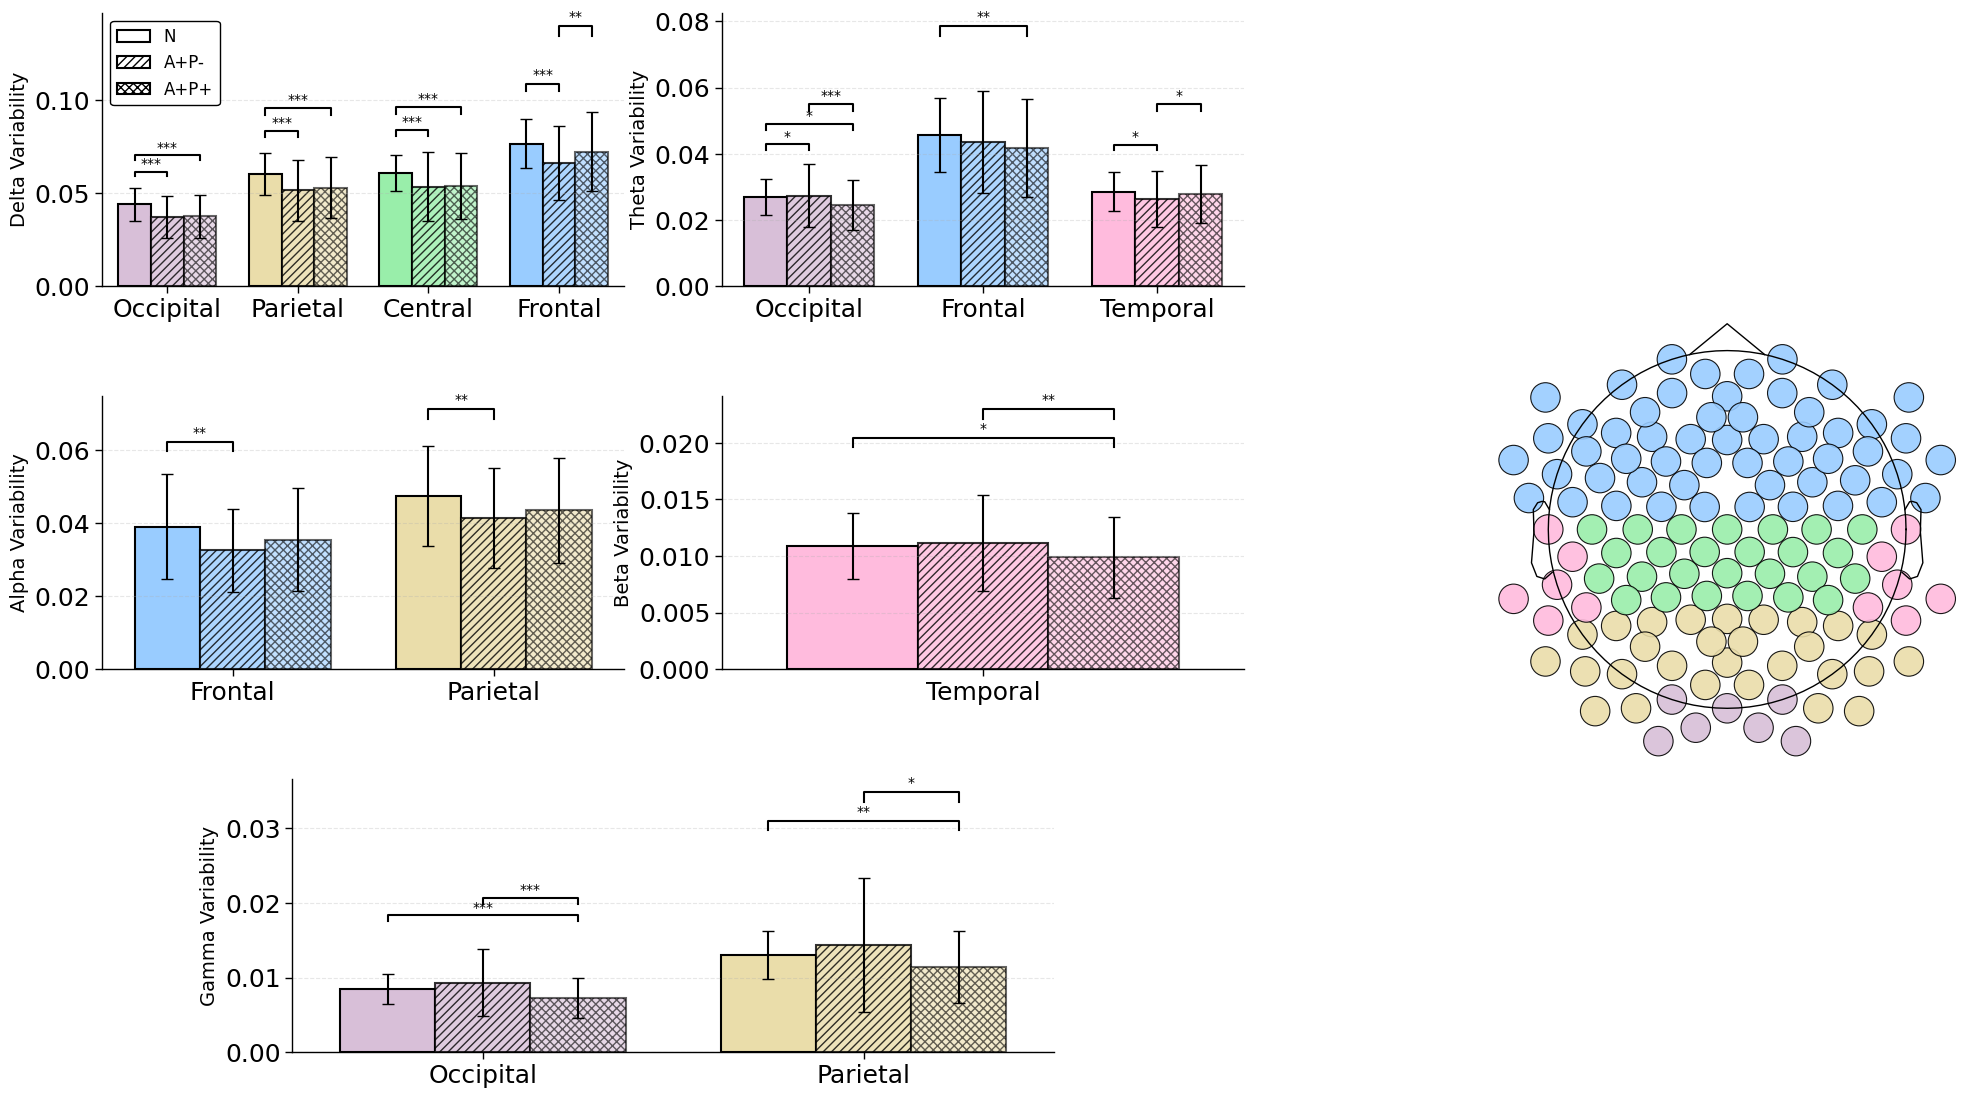


✓ Saved visualization: regional_variability_barplot_topomap.png


In [23]:
import mne
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle, FancyBboxPatch
from scipy.stats import mannwhitneyu

# Region color palette
region_colors = {
    "Frontal": "#99CCFF",
    "Temporal": "#FFBBDD",
    "Central": "#99EEAA",
    "Parietal": "#EADDAA",
    "Occipital": "#D8BFD8"
}

def add_significance_bracket(ax, x1, x2, y, p_value):
    """Add a significance bracket between two bars"""
    h = y * 0.04
    
    # Draw bracket
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    
    # Add significance stars
    if p_value < 0.001:
        sig_text = '***'
    elif p_value < 0.01:
        sig_text = '**'
    elif p_value < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    ax.text((x1+x2)/2, y+h*1.2, sig_text, ha='center', va='bottom', fontsize=10)

# Load channel info
path = "/data/s.dharia-ra/PEARL/original_data/sub-01/eeg/sub-01_task-rest_eeg.vhdr"
raw = mne.io.read_raw_brainvision(path, preload=True, verbose=False)
ch_names = raw.info['ch_names']

# Get significant results
sig_results_df = pd.DataFrame(significant_results_corrected)

# Define band order
band_order = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Filter and organize by band
results_by_band = {}
for band in band_order:
    band_results = sig_results_df[sig_results_df['band'] == band]
    if len(band_results) > 0:
        results_by_band[band] = band_results.sort_values('p_value_corrected')

# Collect all significant regions
all_sig_regions = set()
for band, band_df in results_by_band.items():
    all_sig_regions.update(band_df['region'].values)

# Create figure with grid: 4 columns (barplot, barplot, empty, topomap) x n_rows
n_bands = len(results_by_band)
n_rows = int(np.ceil(n_bands / 2))  # 2 plots per row

fig = plt.figure(figsize=(24, 4.5 * n_rows))
# Add a 4th column for spacing when last plot is centered
gs = fig.add_gridspec(n_rows, 4, width_ratios=[1, 1, 0.1, 0.9], hspace=0.4, wspace=0.25)

# Create topomap (spans all rows in the rightmost column)
ax_topo = fig.add_subplot(gs[:, 3])

# Create sensor plot
mne.viz.plot_sensors(raw.info, ch_type='eeg', show_names=False, 
                     show=False, axes=ax_topo)

# Get sensor collection
sensors_collection = ax_topo.collections[0]

# Color sensors by region
inferred_regions = [infer_region_from_name(ch) for ch in ch_names]
sensor_colors = []

for ch, reg in zip(ch_names, inferred_regions):
    # not just significant regions, but all regions in the analysis
    if reg in region_colors:
        sensor_colors.append(region_colors[reg])
    else:
        sensor_colors.append('#E0E0E0')

sensors_collection.set_facecolors(sensor_colors)
sensors_collection.set_alpha(0.9)
sensors_collection.set_edgecolors('black')
sensors_collection.set_linewidth(0.8)
sensors_collection.set_sizes([450] * len(ch_names))

# Add legend for regions
legend_handles = [
    mlines.Line2D([], [], color=region_colors[reg], marker='o', 
                 markersize=14, linestyle='None', label=reg, 
                 markeredgecolor='black', markeredgewidth=0.8)
    for reg in sorted(all_sig_regions)
]

# Create bar plots for each band (2 per row)
for idx, (band, band_df) in enumerate(results_by_band.items()):
    row = idx // 2  # Which row (0, 1, 2, ...)
    col = idx % 2   # Which column (0 or 1)
    
    # Center last plot if odd number of bands by using column 0.5 position
    if n_bands % 2 == 1 and idx == n_bands - 1:
        # Last plot - use a GridSpec to center it between columns 0 and 1
        from matplotlib.gridspec import GridSpecFromSubplotSpec
        inner_gs = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[row, :2], 
                                           width_ratios=[0.25, 1, 0.25], wspace=0)
        ax_bar = fig.add_subplot(inner_gs[0, 1])
    else:
        ax_bar = fig.add_subplot(gs[row, col])
    
    regions = band_df['region'].values
    n_regions = len(regions)
    bar_width = 0.25
    
    # Calculate positions
    x_pos = np.arange(n_regions)
    
    # Create bars for each region
    for i, (_, row_data) in enumerate(band_df.iterrows()):
        region = row_data['region']
        base_color = region_colors[region]
        
        # N group - solid
        ax_bar.bar(x_pos[i] - bar_width, row_data['N_mean_std'], bar_width,
                  yerr=row_data['N_std_of_std'], color=base_color, alpha=1.0,
                  capsize=4, error_kw={'linewidth': 1.5, 'elinewidth': 1.5},
                  edgecolor='black', linewidth=1.5, label='N' if i == 0 else '')
        
        # A+P- group - diagonal
        ax_bar.bar(x_pos[i], row_data['A+P-_mean_std'], bar_width,
                  yerr=row_data['A+P-_std_of_std'], color=base_color, alpha=0.8,
                  capsize=4, error_kw={'linewidth': 1.5, 'elinewidth': 1.5},
                  edgecolor='black', linewidth=1.5, hatch='////',
                  label='A+P-' if i == 0 else '')
        
        # A+P+ group - cross
        ax_bar.bar(x_pos[i] + bar_width, row_data['A+P+_mean_std'], bar_width,
                  yerr=row_data['A+P+_std_of_std'], color=base_color, alpha=0.6,
                  capsize=4, error_kw={'linewidth': 1.5, 'elinewidth': 1.5},
                  edgecolor='black', linewidth=1.5, hatch='xxxx',
                  label='A+P+' if i == 0 else '')
        
        # Pairwise comparisons
        n_vals = regional_results[region][band]['N_values']
        apm_vals = regional_results[region][band]['A+P-_values']
        app_vals = regional_results[region][band]['A+P+_values']
        
        y_vals = [row_data['N_mean_std'] + row_data['N_std_of_std'],
                  row_data['A+P-_mean_std'] + row_data['A+P-_std_of_std'],
                  row_data['A+P+_mean_std'] + row_data['A+P+_std_of_std']]
        y_max = max(y_vals)
        
        # N vs A+P-
        _, p_n_apm = mannwhitneyu(n_vals, apm_vals, alternative='two-sided')
        if p_n_apm < 0.05:
            add_significance_bracket(ax_bar, x_pos[i] - bar_width, x_pos[i], y_max * 1.12, p_n_apm)
        
        # N vs A+P+
        _, p_n_app = mannwhitneyu(n_vals, app_vals, alternative='two-sided')
        if p_n_app < 0.05:
            add_significance_bracket(ax_bar, x_pos[i] - bar_width, x_pos[i] + bar_width, y_max * 1.28, p_n_app)
        
        # A+P- vs A+P+
        _, p_apm_app = mannwhitneyu(apm_vals, app_vals, alternative='two-sided')
        if p_apm_app < 0.05:
            add_significance_bracket(ax_bar, x_pos[i], x_pos[i] + bar_width, y_max * 1.44, p_apm_app)
    
    # Set tight x-axis limits
    ax_bar.set_xlim(-0.5, n_regions - 0.5)
    
    # Customize
    ax_bar.set_ylabel(f'{band.capitalize()} Variability', fontsize=14)
    ax_bar.set_xticks(x_pos)
    ax_bar.set_xticklabels(regions, fontsize=18)
    
    # Legend (only on first plot)
    if idx == 0:
        legend_elements = [
            plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', linewidth=1.5, label='N'),
            plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', linewidth=1.5, hatch='////', label='A+P-'),
            plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', linewidth=1.5, hatch='xxxx', label='A+P+')
        ]
        legend = ax_bar.legend(handles=legend_elements, loc='best', fontsize=12, 
                              frameon=True, edgecolor='black', facecolor='white', framealpha=1)
        legend.get_frame().set_linewidth(1.0)
    
    ax_bar.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.spines['left'].set_linewidth(1.0)
    ax_bar.spines['bottom'].set_linewidth(1.0)
    ax_bar.tick_params(labelsize=18, width=1.0, length=5)

plt.tight_layout()
plt.savefig('regional_variability_barplot_topomap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved visualization: regional_variability_barplot_topomap.png")

# EEG PERMUTATION

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal, shapiro, levene
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

# Parameters
K_STATES_LIST = list(range(6, 12))
SEED = 1000
P_VALUE_THRESHOLD = 0.05

# Paths
EEG_data_dir = "data/EEG_data/HFD_PSD_4sec_75overlap_6min"
MRI_csv_path = "/data/s.dharia-ra/PEARL/final_multi_modal/data/MRI_data/ROI_aal3_Vgm.csv_with_groups.csv"

print("="*80)
print("EEG STD_DISTANCE_TO_CENTROID FEATURE ANALYSIS")
print("="*80)

# Helper functions
def file_to_sid(path_or_name: str, pad: int = 2) -> str:
    """Convert filename to standardized subject ID"""
    base = os.path.splitext(os.path.basename(path_or_name))[0]
    digits = ''.join(ch for ch in base if ch.isdigit())
    if not digits:
        if base.startswith("sub-"):
            tail = ''.join(ch for ch in base.split('-', 1)[1] if ch.isdigit())
            digits = tail or "0"
        else:
            digits = "0"
    return f"sub-{str(int(digits)).zfill(pad)}"

def _get_col(df, target_name_lower: str):
    """Find column in DataFrame ignoring case"""
    for c in df.columns:
        if c.lower() == target_name_lower:
            return c
    raise KeyError(f"Column '{target_name_lower}' not found. Available: {list(df.columns)}")

def choose_statistical_test(groups):
    """Choose appropriate statistical test"""
    if len(groups) < 2 or any(g.size == 0 for g in groups):
        return 'None', 1.0, 0.0
    try:
        normality_ok = all(shapiro(g)[1] > 0.05 for g in groups if len(g) >= 3)
        equal_var_ok = levene(*groups)[1] > 0.05
        if normality_ok and equal_var_ok:
            if len(groups) == 2:
                stat, p_val = ttest_ind(*groups)
                return 't-test', p_val, stat
            else:
                stat, p_val = f_oneway(*groups)
                return 'ANOVA', p_val, stat
        else:
            if len(groups) == 2:
                stat, p_val = mannwhitneyu(*groups)
                return 'Mann-Whitney', p_val, stat
            else:
                stat, p_val = kruskal(*groups)
                return 'Kruskal-Wallis', p_val, stat
    except Exception:
        return 'None', 1.0, 0.0

def determine_dominant_group(feature_values, labels):
    """Determine which group has highest mean"""
    label_to_group = {0: 'N', 1: 'A+P-', 2: 'A+P+'}
    group_means = {}
    for lab in np.unique(labels):
        vals = feature_values[labels == lab]
        group_means[lab] = np.mean(vals) if len(vals) else np.nan
    dominant_label = max(group_means, key=group_means.get)
    return label_to_group[dominant_label], group_means

# Data loading
print("\nStep 1: Loading subject labels and EEG data")
print("-" * 50)

# Get EEG subjects
eeg_subjects = {file_to_sid(f) for f in os.listdir(EEG_data_dir) if f.endswith(".npz")}
print(f"Found {len(eeg_subjects)} EEG subjects")

# Load MRI labels
mri_df = pd.read_csv(MRI_csv_path)
names_col = _get_col(mri_df, "names")
group_col = _get_col(mri_df, "group")

# Extract subject IDs from names
name_series = mri_df[names_col].astype(str)
subject_raw = name_series.str.extract(r'(sub-\d+)', expand=False).fillna(
    name_series.str.replace("_T1w", "", regex=False)
)
subject_num = subject_raw.str.extract(r'(\d+)', expand=False)
mri_df["subject_id"] = subject_num.apply(
    lambda d: f"sub-{str(int(d)).zfill(2)}" if pd.notna(d) and str(d).isdigit() else np.nan
)

# Create group mappings
group_to_label = {'N': 0, 'A+P-': 1, 'A+P+': 2}
mri_df["numeric_label"] = mri_df[group_col].map(group_to_label)

# Filter to subjects with both EEG and MRI data
mri_df_eeg = mri_df[mri_df["subject_id"].isin(eeg_subjects)].dropna(
    subset=["subject_id", "numeric_label"]
).copy()

risk_group_map = dict(zip(mri_df_eeg["subject_id"], mri_df_eeg["numeric_label"]))

print(f"Subjects with both EEG and MRI labels: {len(risk_group_map)}")
for grp, lab in group_to_label.items():
    cnt = sum(1 for v in risk_group_map.values() if v == lab)
    print(f"  {grp} (label={lab}): {cnt} subjects")

# Create final DataFrame
final_df = mri_df_eeg[["subject_id", group_col, "numeric_label"]].rename(
    columns={group_col: "Risk_Group", "subject_id": "participant_id", "numeric_label": "Group"}
).reset_index(drop=True)

# Load EEG features
def load_eeg_features(feature_dir: str, risk_group_map: dict):
    """Load EEG features for all subjects and windows"""
    all_features, all_labels, all_sub_ids = [], [], []
    
    print("\nLoading EEG window features...")
    for npz_path in glob.glob(os.path.join(feature_dir, "*.npz")):
        sid = file_to_sid(npz_path, pad=2)
        if sid not in risk_group_map:
            continue
            
        label = int(risk_group_map[sid])
        data = np.load(npz_path, allow_pickle=True)
        hfd = data["HFD_features"]
        n_windows = hfd.shape[0]
        subj_num = int(sid.split("-")[1])
        
        for w in range(n_windows):
            all_features.append(hfd[w].flatten())
            all_labels.append(label)
            all_sub_ids.append(subj_num)
        
        print(f"  Loaded {n_windows:4d} windows from {sid} ({['N','A+P-','A+P+'][label]})")
    
    return {
        "X": np.array(all_features),
        "y": np.array(all_labels),
        "sub_ids": np.array(all_sub_ids),
    }

eeg_data = load_eeg_features(EEG_data_dir, risk_group_map)

print(f"\nEEG Data Summary:")
print(f"  Windows: {eeg_data['X'].shape[0]}")
print(f"  Features per window: {eeg_data['X'].shape[1]}")
print(f"  Unique subjects: {len(np.unique(eeg_data['sub_ids']))}")

# Main analysis function - ONLY std_distance_to_centroid
def compute_std_distance_to_centroid_only(X_data, y_data, sub_ids_data, kmeans_model, k_states):
    """Compute ONLY std_distance_to_centroid for each subject"""
    centroids = kmeans_model.cluster_centers_
    
    # Predict all windows at once
    all_preds = kmeans_model.predict(X_data)
    
    unique_subjects = np.unique(sub_ids_data)
    subject_features = []
    
    for subject in unique_subjects:
        mask = (sub_ids_data == subject)
        if not np.any(mask):
            continue
            
        subj_X = X_data[mask]
        subj_preds = all_preds[mask]
        subj_label = y_data[mask][0]
        
        std_dist = np.full(k_states, np.nan) # Initialize with NaN
        for s in range(k_states): # For each state
            state_windows = subj_X[subj_preds == s] # Windows assigned to state s
            if state_windows.shape[0] > 0: # If there are windows for this state
                distances = np.linalg.norm(state_windows - centroids[s], axis=1) # Distances to centroid
                std_dist[s] = np.std(distances) # Std deviation of distances
        
        subject_features.append({
            'subject_id': subject,
            'label': subj_label,
            'std_distance_to_centroid': std_dist
        })
    
    return subject_features

print("\nStep 2: Feature Engineering and Statistical Testing")
print("-" * 50)

all_significant_features = []
all_features_for_wide = []  # Store ALL features for wide format

for K_STATES in K_STATES_LIST:
    print(f"\nAnalyzing K = {K_STATES}")
    print("-" * 30)
    
    # Fit KMeans - DON'T MODIFY ORIGINAL DATA
    kmeans = KMeans(n_clusters=K_STATES, random_state=SEED, n_init=10, max_iter=300)
    X_scaled = eeg_data['X'] / 2  # Create scaled copy
    kmeans.fit(X_scaled)
    
    # Compute std_distance_to_centroid features
    subject_features = compute_std_distance_to_centroid_only(
        X_scaled, eeg_data['y'], eeg_data['sub_ids'], kmeans, K_STATES
    )
    
    if len(subject_features) == 0:
        continue
    
    # Extract labels and feature matrix
    labels = np.array([s['label'] for s in subject_features])
    subject_ids = np.array([s['subject_id'] for s in subject_features])
    std_distance_matrix = np.vstack([s['std_distance_to_centroid'] for s in subject_features])
    
    # Test each state and store ALL features (not just significant ones)
    for state in range(K_STATES):
        vals = std_distance_matrix[:, state]
        feat_name = f"EEG_K{K_STATES}_std_distance_to_centroid_state{state}"
        
        # Store ALL features for wide format
        for subj_id, value in zip(subject_ids, vals):
            all_features_for_wide.append({
                'subject_id_num': subj_id,
                'participant_id': f"sub-{int(subj_id):02d}",
                'feature_name': feat_name,
                'value': value,
                'K': K_STATES,
                'state': state
            })
        
        # Handle NaN values for statistical testing
        valid_mask = ~np.isnan(vals)
        if not np.any(valid_mask):
            continue
            
        valid_vals = vals[valid_mask]
        valid_labels = labels[valid_mask]
        valid_subject_ids = subject_ids[valid_mask]
        
        if len(np.unique(valid_labels)) < 2:
            continue
        
        # Statistical test
        groups = [valid_vals[valid_labels == lab] for lab in np.unique(valid_labels)]
        test_name, p_value, _ = choose_statistical_test(groups)
        
        if p_value < P_VALUE_THRESHOLD:
            dom_group, group_means = determine_dominant_group(valid_vals, valid_labels)
            print(f"  ✓ State {state} std_distance: p={p_value:.6f} ({dom_group} higher)")
            
            all_significant_features.append({
                'K': K_STATES,
                'feature_type': 'std_distance_to_centroid',
                'state': state,
                'p_value': p_value,
                'test': test_name,
                'dominant_group': dom_group,
                'group_means': group_means,
                'feature_values': vals,  # Include ALL values (with NaN)
                'subject_ids': subject_ids  # Include ALL subject IDs
            })

print(f"\nStep 3: Results")
print("-" * 50)
print(f"Found {len(all_significant_features)} significant std_distance_to_centroid features")

if all_significant_features:
    # Summary
    k_counts = Counter(f['K'] for f in all_significant_features)
    dom_counts = Counter(f['dominant_group'] for f in all_significant_features)
    
    print(f"\nBreakdown by K value:")
    for k, count in sorted(k_counts.items()):
        print(f"  K={k}: {count}")
    
    print(f"\nBreakdown by dominant group:")
    for group, count in sorted(dom_counts.items()):
        print(f"  {group}: {count}")
    
    # Save results
    print(f"\nStep 4: Saving Results")
    print("-" * 50)
    
    # Create long-format DataFrame (ONLY significant features)
    records = []
    for feat in all_significant_features:
        feat_name = f"EEG_K{feat['K']}_std_distance_to_centroid_state{feat['state']}"
        
        for subj_id, value in zip(feat['subject_ids'], feat['feature_values']):
            records.append({
                'subject_id_num': subj_id,
                'participant_id': f"sub-{int(subj_id):02d}",
                'feature_name': feat_name,
                'value': value,
                'p_value': feat['p_value'],
                'test': feat['test'],
                'dominant_group': feat['dominant_group']
            })
    
    long_df = pd.DataFrame(records)
    
    # Merge with subject metadata
    long_df = pd.merge(long_df, final_df[['participant_id', 'Risk_Group', 'Group']], 
                       on='participant_id', how='left')
    
    # Save long format
    long_csv = "EEG_std_distance_significant_features_long.csv"
    long_df.to_csv(long_csv, index=False)
    print(f"✓ Saved long-format CSV: {long_csv}")
    
    # Create wide format from ALL features (including non-significant ones from significant K values)
    print("\nCreating wide format with ALL features from significant K values...")
    
    # Get all K values that had at least one significant feature
    significant_K_values = set(f['K'] for f in all_significant_features)
    print(f"Significant K values: {sorted(significant_K_values)}")
    
    # Filter all_features_for_wide to only include significant K values
    wide_features = [f for f in all_features_for_wide if f['K'] in significant_K_values]
    
    # Create wide DataFrame
    wide_df_all = pd.DataFrame(wide_features)
    wide_df_all = pd.merge(wide_df_all, final_df[['participant_id', 'Risk_Group', 'Group']], 
                          on='participant_id', how='left')
    
    # Pivot to wide format
    wide_df = wide_df_all.pivot_table(
        index=['participant_id', 'Risk_Group', 'Group'],
        columns='feature_name',
        values='value'
    ).reset_index()
    
    wide_csv = "EEG_std_distance_all_features_wide.csv"
    wide_df.to_csv(wide_csv, index=False)
    print(f"✓ Saved wide-format CSV with ALL features: {wide_csv}")
    print(f"  Shape: {wide_df.shape}")
    print(f"  Feature columns: {wide_df.shape[1] - 3}")  # Subtract metadata columns
    
    # Also create a wide format with ONLY significant features
    wide_df_sig_only = long_df.pivot_table(
        index=['participant_id', 'Risk_Group', 'Group'],
        columns='feature_name',
        values='value'
    ).reset_index()
    
    wide_csv_sig = "EEG_std_distance_significant_only_wide.csv"
    wide_df_sig_only.to_csv(wide_csv_sig, index=False)
    print(f"✓ Saved wide-format CSV with ONLY significant features: {wide_csv_sig}")
    print(f"  Shape: {wide_df_sig_only.shape}")

else:
    print("No significant std_distance_to_centroid features found.")

print("\n" + "="*80)
print("✅ COMPLETE! std_distance_to_centroid analysis finished")
print("="*80)


EEG STD_DISTANCE_TO_CENTROID FEATURE ANALYSIS

Step 1: Loading subject labels and EEG data
--------------------------------------------------
Found 75 EEG subjects
Subjects with both EEG and MRI labels: 65
  N (label=0): 25 subjects
  A+P- (label=1): 23 subjects
  A+P+ (label=2): 17 subjects

Loading EEG window features...
  Loaded  357 windows from sub-13 (N)
  Loaded  357 windows from sub-21 (N)
  Loaded  357 windows from sub-67 (A+P-)
  Loaded  357 windows from sub-59 (A+P-)
  Loaded  357 windows from sub-76 (A+P-)
  Loaded  357 windows from sub-16 (N)
  Loaded  357 windows from sub-57 (A+P-)
  Loaded  357 windows from sub-02 (N)
  Loaded  357 windows from sub-33 (A+P+)
  Loaded  357 windows from sub-39 (A+P+)
  Loaded  357 windows from sub-25 (N)
  Loaded  357 windows from sub-24 (N)
  Loaded  357 windows from sub-26 (N)
  Loaded  357 windows from sub-05 (N)
  Loaded  357 windows from sub-44 (A+P+)
  Loaded  357 windows from sub-37 (A+P+)
  Loaded  357 windows from sub-54 (A+P+)
  

In [ ]:
"""
LOSO (Leave-One-Subject-Out) for EEG std_distance_to_centroid + LogisticRegression
With EEG ensemble across K using p-value weighting (adapted from your multimodal pattern).
Expected inputs (explicit):
- EEG window .npz files folder containing "HFD_features" per file (each file = subject windows)
  Path: EEG_data_dir (string)
- MRI CSV path containing subject name column (contains 'sub-<num>') and group column
  Path: MRI_csv_path (string)
Notes:
- This script expects a binary classification mapping (e.g., {'N':0, 'A+P-':1}) as in your pasted snippet.
- Follows "fail fast" rules: asserts on paths, raises ValueError on shape mismatches.
Outputs:
- CSVs in RESULTS_DIR with per-fold EEG ensemble probabilities and summary metrics.
"""
import os
import glob
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal, shapiro, levene
from collections import Counter

# -------- Parameters (edit as needed) --------
SEED = 100
K_STATES_LIST = list(range(4, 10))  # EEG K range used in your multimodal script
EEG_data_dir = "data/EEG_data/HFD_PSD_4sec_75overlap_6min"
MRI_csv_path = "/data/s.dharia-ra/PEARL/final_multi_modal/data/MRI_data/ROI_aal3_Vgm.csv_with_groups.csv"
RESULTS_DIR = "loso_results_eeg_ensemble"
os.makedirs(RESULTS_DIR, exist_ok=True)

# basic checks
assert os.path.isdir(EEG_data_dir), f"EEG_data_dir not found: {EEG_data_dir}"
assert os.path.isfile(MRI_csv_path), f"MRI_csv_path not found: {MRI_csv_path}"

# -------- Helper functions (minimal) --------
def file_to_sid(path_or_name: str, pad: int = 2) -> str:
    base = os.path.splitext(os.path.basename(path_or_name))[0]
    digits = ''.join(ch for ch in base if ch.isdigit())
    if not digits:
        if base.startswith("sub-"):
            tail = ''.join(ch for ch in base.split('-', 1)[1] if ch.isdigit())
            digits = tail or "0"
        else:
            digits = "0"
    return f"sub-{str(int(digits)).zfill(pad)}"

def _get_col(df, target_name_lower: str):
    for c in df.columns:
        if c.lower() == target_name_lower:
            return c
    raise KeyError(f"Column '{target_name_lower}' not found. Available: {list(df.columns)}")

def choose_statistical_test(groups):
    """Return (test_name, p_value, stat) - same adaptive rules as before."""
    if len(groups) < 2 or any(g.size == 0 for g in groups):
        return 'None', 1.0, 0.0
    try:
        normality_ok = all(shapiro(g)[1] > 0.05 for g in groups if len(g) >= 3)
        equal_var_ok = levene(*groups)[1] > 0.05
        if normality_ok and equal_var_ok:
            if len(groups) == 2:
                stat, p_val = ttest_ind(*groups)
                return 't-test', p_val, stat
            else:
                stat, p_val = f_oneway(*groups)
                return 'ANOVA', p_val, stat
        else:
            if len(groups) == 2:
                stat, p_val = mannwhitneyu(*groups)
                return 'Mann-Whitney', p_val, stat
            else:
                stat, p_val = kruskal(*groups)
                return 'Kruskal-Wallis', p_val, stat
    except Exception:
        return 'None', 1.0, 0.0

def compute_pvalue_weights(p_values, smoothing=1e-10, power=2.0):
    """Convert array of p-values to normalized weights (higher weight -> lower p)."""
    p = np.array(p_values, dtype=float)
    if p.size == 0:
        return np.array([])
    smoothed = p + smoothing
    inv = (1.0 / smoothed) ** power
    # If all p-values are identical zeros (unlikely), handle divide by zero
    s = np.sum(inv)
    if s <= 0 or not np.isfinite(s):
        return np.ones_like(inv) / float(inv.size)
    return inv / s

def weighted_prediction(probabilities, weights):
    """probabilities: (n_samples, n_models), weights: (n_models,) -> returns binarized preds and weighted_prob"""
    probs = np.array(probabilities)
    weights = np.array(weights)
    if probs.ndim == 1:
        probs = probs[:, None]
    # weighted average across model axis (axis=1 is models)
    weighted_prob = np.average(probs, axis=1, weights=weights)
    preds = (weighted_prob > 0.5).astype(int)
    return preds, weighted_prob

# -------- Load EEG windows (HFD_features) --------
def load_eeg_features(feature_dir: str, risk_group_map: dict):
    all_features, all_labels, all_sub_ids = [], [], []
    npz_paths = sorted(glob.glob(os.path.join(feature_dir, "*.npz")))
    if len(npz_paths) == 0:
        raise ValueError("No .npz files found in EEG_data_dir.")
    for npz_path in npz_paths:
        sid = file_to_sid(npz_path, pad=2)
        if sid not in risk_group_map:
            continue
        label = int(risk_group_map[sid])
        data = np.load(npz_path, allow_pickle=True)
        if "HFD_features" not in data:
            raise KeyError(f"'HFD_features' not found in {npz_path}")
        hfd = data["HFD_features"]
        n_windows = int(hfd.shape[0])
        subj_num = int(sid.split("-")[1])
        for w in range(n_windows):
            all_features.append(hfd[w].flatten())
            all_labels.append(label)
            all_sub_ids.append(subj_num)
    if len(all_features) == 0:
        raise ValueError("No EEG windows loaded. Check paths and subject mappings.")
    return {"X": np.array(all_features), "y": np.array(all_labels), "sub_ids": np.array(all_sub_ids)}

# -------- per-subject std_distance_to_centroid (using centroids from train KMeans) --------
def compute_std_distance_to_centroid_only(X_data, y_data, sub_ids_data, kmeans_model, k_states):
    centroids = kmeans_model.cluster_centers_
    all_preds = kmeans_model.predict(X_data)
    unique_subjects = np.unique(sub_ids_data)
    subject_features = []
    for subject in unique_subjects:
        mask = (sub_ids_data == subject)
        if not np.any(mask):
            continue
        subj_X = X_data[mask]
        subj_preds = all_preds[mask]
        subj_label = int(y_data[mask][0])
        std_dist = np.full(k_states, np.nan)
        for s in range(k_states):
            state_windows = subj_X[subj_preds == s]
            if state_windows.shape[0] > 0:
                distances = np.linalg.norm(state_windows - centroids[s], axis=1)
                std_dist[s] = float(np.std(distances))
        subject_features.append({'subject_id': int(subject), 'label': subj_label, 'std_distance_to_centroid': std_dist})
    return subject_features

# -------- Load MRI csv and build risk_group_map (binary mapping expected) --------
mri_df = pd.read_csv(MRI_csv_path)
try:
    names_col = _get_col(mri_df, "names")
except KeyError:
    for alt in ("name", "subject", "participant"):
        try:
            names_col = _get_col(mri_df, alt)
            break
        except KeyError:
            names_col = None
    if names_col is None:
        raise

group_col = None
for cand in ("group", "risk_group", "Risk_Group", "Group"):
    try:
        group_col = _get_col(mri_df, cand)
        break
    except KeyError:
        group_col = None
if group_col is None:
    raise KeyError("Cannot find group column in MRI csv. Look for 'group' or similar.")

name_series = mri_df[names_col].astype(str)
subject_raw = name_series.str.extract(r'(sub-\d+)', expand=False).fillna(name_series.str.replace("_T1w", "", regex=False))
subject_num = subject_raw.str.extract(r'(\d+)', expand=False)
mri_df["subject_id"] = subject_num.apply(lambda d: f"sub-{str(int(d)).zfill(2)}" if pd.notna(d) and str(d).isdigit() else np.nan)

# <-- USER ADJUSTED mapping earlier to two classes; keep as-is (fail fast if mismatch) -->
group_to_label = {'N': 0, 'A+P-': 1}
present_vals = set(mri_df[group_col].unique())
if not present_vals.issuperset(set(group_to_label.keys())):
    raise ValueError(f"MRI group names {present_vals} do not include expected keys {set(group_to_label.keys())}. Update mapping.")

mri_df["numeric_label"] = mri_df[group_col].map(group_to_label)

eeg_files = sorted(glob.glob(os.path.join(EEG_data_dir, "*.npz")))
eeg_subjects = {file_to_sid(f) for f in eeg_files}
mri_df_eeg = mri_df[mri_df["subject_id"].isin(eeg_subjects)].dropna(subset=["subject_id", "numeric_label"]).copy()
risk_group_map = dict(zip(mri_df_eeg["subject_id"], mri_df_eeg["numeric_label"]))

print("Subjects with both EEG and MRI labels:", len(risk_group_map))
for grp, lab in group_to_label.items():
    cnt = sum(1 for v in risk_group_map.values() if v == lab)
    print(f"  {grp} (label={lab}): {cnt} subjects")

final_df = mri_df_eeg[["subject_id", group_col, "numeric_label"]].rename(
    columns={group_col: "Risk_Group", "subject_id": "participant_id", "numeric_label": "Group"}
).reset_index(drop=True)

# -------- Load EEG windows --------
eeg_data = load_eeg_features(EEG_data_dir, risk_group_map)
print("EEG windows loaded:", eeg_data['X'].shape)

# -------- LOSO loop with EEG ensemble (p-value weighting across K) --------
unique_subject_nums = np.unique(eeg_data['sub_ids'])
if unique_subject_nums.size < 2:
    raise ValueError("Need at least 2 subjects for LOSO.")

results_per_K = {}  # keep per-K CSVs if desired
summary = {}
all_fold_rows = []

for test_subject in unique_subject_nums:
    print(f"\nLOSO fold: leaving out subject {int(test_subject)}")
    # train/test window masks
    train_mask = eeg_data['sub_ids'] != test_subject
    test_mask = eeg_data['sub_ids'] == test_subject
    X_train = eeg_data['X'][train_mask]
    y_train_w = eeg_data['y'][train_mask]
    subids_train = eeg_data['sub_ids'][train_mask]
    X_test = eeg_data['X'][test_mask]
    y_test_w = eeg_data['y'][test_mask]
    subids_test = eeg_data['sub_ids'][test_mask]

    if X_test.shape[0] == 0:
        print(f"  Test subject {int(test_subject)} has no windows -> skipping fold")
        continue

    per_K_probs = []   # collect probability for positive class for this test subject, per K
    per_K_pvals = []   # corresponding p-values (best state's p)
    per_K_info = []    # debug info

    for K in K_STATES_LIST:
        # fit KMeans on training windows only
        try:
            kmeans = KMeans(n_clusters=K, random_state=SEED, n_init=10, max_iter=300)
            kmeans.fit(X_train)
        except Exception as e:
            print(f"  KMeans failed for K={K}: {e}. Skipping this K.")
            continue

        # compute subject-level std_distance using centroids above (for all subjects)
        subject_features = compute_std_distance_to_centroid_only(eeg_data['X'], eeg_data['y'], eeg_data['sub_ids'], kmeans, K)
        subj_ids = np.array([s['subject_id'] for s in subject_features])
        labels = np.array([s['label'] for s in subject_features])
        feat_mat = np.vstack([s['std_distance_to_centroid'] for s in subject_features])  # (n_subjects, K)

        # Build subject-level train/test arrays
        train_sub_ids = np.unique(subids_train)
        train_mask_sub = np.isin(subj_ids, train_sub_ids)
        test_mask_sub = subj_ids == int(test_subject)
        if not np.any(test_mask_sub):
            # test subject didn't receive any feature for this K (all NaN) -> skip this K
            print(f"    K={K}: test subject has no feature -> skipping K")
            continue

        X_train_sub = feat_mat[train_mask_sub]
        y_train_sub = labels[train_mask_sub]
        X_test_sub = feat_mat[test_mask_sub]  # shape (1, K)
        y_test_sub = int(labels[test_mask_sub][0])

        # For each state compute p-values on training subjects
        p_list = []
        for state in range(K):
            vals = X_train_sub[:, state]
            valid_mask_state = ~np.isnan(vals)
            if np.sum(valid_mask_state) < 2:
                p_list.append(1.0)
                continue
            groups = [vals[(y_train_sub == lab) & valid_mask_state] for lab in np.unique(y_train_sub)]
            test_name, p_val, _ = choose_statistical_test(groups)
            p_list.append(float(p_val))

        # choose best state (minimum p)
        p_array = np.array(p_list)
        if p_array.size == 0 or np.all(np.isnan(p_array)) or np.all(p_array >= 1.0):
            print(f"    K={K}: no valid p-values across states -> skipping K")
            continue
        best_state = int(np.nanargmin(p_array))
        best_p = float(p_array[best_state])

        # ensure train has enough non-NaN rows for the selected state
        train_vals_for_state = X_train_sub[:, best_state]
        valid_train_mask = ~np.isnan(train_vals_for_state)
        if np.sum(valid_train_mask) < 2:
            print(f"    K={K}: not enough train subjects for selected state {best_state} -> skipping K")
            continue
        # ensure test subject not NaN
        if np.isnan(X_test_sub[0, best_state]):
            print(f"    K={K}: test subject NaN for selected state {best_state} -> skipping K")
            continue

        # train logistic regression on the selected state (binary)
        Xtr = train_vals_for_state[valid_train_mask].reshape(-1, 1)
        ytr = y_train_sub[valid_train_mask]
        Xte = np.array(X_test_sub[:, best_state]).reshape(-1, 1)

        clf = make_pipeline(StandardScaler(), LogisticRegression(penalty=None,
                                                                 class_weight='balanced', random_state=SEED))
        clf.fit(Xtr, ytr)
        prob_pos = float(clf.predict_proba(Xte)[:, 1][0])
        pred_label = int(clf.predict(Xte)[0])

        per_K_probs.append(prob_pos)
        per_K_pvals.append(best_p)
        per_K_info.append({'K': K, 'best_state': best_state, 'best_p': best_p, 'pred_label': pred_label})

        # clean up
        del clf
        del kmeans

    # after iterating all K, compute ensemble weighted probability
    if len(per_K_probs) == 0:
        print(f"  Fold test_subject={int(test_subject)}: no valid K produced a prediction -> skipping fold")
        continue

    weights = compute_pvalue_weights(np.array(per_K_pvals), smoothing=1e-10, power=2.0)
    # build probabilities as (n_samples=1, n_models=len(per_K_probs))
    probs_matrix = np.array(per_K_probs).reshape(1, -1)
    _, ensemble_prob = weighted_prediction(probs_matrix, weights)  # returns (preds, probs)
    ensemble_prob_scalar = float(ensemble_prob[0])
    ensemble_pred = int(ensemble_prob_scalar > 0.5)

    # true label for test subject (take from existing data)
    true_label = int(np.unique(eeg_data['y'][eeg_data['sub_ids'] == test_subject])[0])

    # collect fold results
    row = {
        'test_subject': int(test_subject),
        'true_label': true_label,
        'ensemble_prob': ensemble_prob_scalar,
        'ensemble_pred': ensemble_pred,
        'per_K_info': per_K_info,
        'per_K_pvals': per_K_pvals,
        'per_K_probs': per_K_probs
    }
    all_fold_rows.append(row)
    print(f"  Fold test_subject={int(test_subject)} -> true={true_label} ensemble_prob={ensemble_prob_scalar:.4f} pred={ensemble_pred}")

# -------- Aggregate and save results --------
if len(all_fold_rows) == 0:
    raise ValueError("No folds completed successfully. Check data and K ranges.")

results_df_rows = []
for r in all_fold_rows:
    base = {'test_subject': r['test_subject'], 'true_label': r['true_label'],
            'ensemble_prob': r['ensemble_prob'], 'ensemble_pred': r['ensemble_pred']}
    # also save compact per-K summary as JSON-like strings
    base['per_K_info'] = str(r['per_K_info'])
    base['per_K_pvals'] = str(r['per_K_pvals'])
    base['per_K_probs'] = str(r['per_K_probs'])
    results_df_rows.append(base)

results_df = pd.DataFrame(results_df_rows)
out_csv = os.path.join(RESULTS_DIR, "loso_eeg_ensemble_per_fold.csv")
results_df.to_csv(out_csv, index=False)
print(f"\nSaved per-fold EEG ensemble results: {out_csv}")

# compute overall metrics
y_true = results_df['true_label'].values
y_pred = results_df['ensemble_pred'].values
y_prob = results_df['ensemble_prob'].values

acc = accuracy_score(y_true, y_pred)
try:
    auc = roc_auc_score(y_true, y_prob)
except Exception:
    auc = float('nan')
cm = confusion_matrix(y_true, y_pred, labels=sorted(list(set(y_true))))
print("\nLOSO EEG Ensemble Summary:")
print(f"  folds={len(results_df)} accuracy={acc:.3f} auc={auc if not np.isnan(auc) else 'nan'}")
print("  confusion_matrix (rows=true, cols=pred):")
print(cm)

summary_csv = os.path.join(RESULTS_DIR, "loso_eeg_ensemble_summary.csv")
pd.DataFrame([{'accuracy': acc, 'auc': auc, 'n_folds': len(results_df)}]).to_csv(summary_csv, index=False)
print(f"Saved summary CSV: {summary_csv}")

print("Done.")


Subjects with both EEG and MRI labels: 48
  N (label=0): 25 subjects
  A+P- (label=1): 23 subjects
EEG windows loaded: (17136, 635)

LOSO fold: leaving out subject 1
    K=10: test subject NaN for selected state 9 -> skipping K
  Fold test_subject=1 -> true=0 ensemble_prob=0.3080 pred=0

LOSO fold: leaving out subject 2
  Fold test_subject=2 -> true=0 ensemble_prob=0.6392 pred=1

LOSO fold: leaving out subject 3
  Fold test_subject=3 -> true=0 ensemble_prob=0.5078 pred=1

LOSO fold: leaving out subject 4
    K=11: test subject NaN for selected state 4 -> skipping K
  Fold test_subject=4 -> true=0 ensemble_prob=0.6658 pred=1

LOSO fold: leaving out subject 5
  Fold test_subject=5 -> true=0 ensemble_prob=0.3962 pred=0

LOSO fold: leaving out subject 7
  Fold test_subject=7 -> true=0 ensemble_prob=0.5473 pred=1

LOSO fold: leaving out subject 8
  Fold test_subject=8 -> true=0 ensemble_prob=0.4236 pred=0

LOSO fold: leaving out subject 9
  Fold test_subject=9 -> true=0 ensemble_prob=0.3855

In [ ]:
import os
import glob
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import (ttest_ind, f_oneway, mannwhitneyu, kruskal, 
                         shapiro, levene, entropy)

# --- Parameters ---
K_STATES_LIST = list(range(4, 11))
SEED = 200
P_VALUE_THRESHOLD = 0.05

# --- Paths ---
EEG_data_dir = "data/EEG_data/HFD_PSD_4sec_75overlap_6min"
MRI_csv_path = "/data/s.dharia-ra/PEARL/final_multi_modal/data/MRI_data/ROI_aal3_Vgm.csv_with_groups.csv"

# %% [markdown]
# ## 2. Helper Functions
# 
# Define utility functions for data loading, statistical testing, and feature processing.

# %% [code]
def file_to_sid(path_or_name: str, pad: int = 2) -> str:
    """Extracts a zero-padded subject ID (e.g., 'sub-05') from a filename."""
    base = os.path.splitext(os.path.basename(path_or_name))[0]
    digits = ''.join(ch for ch in base if ch.isdigit())
    if not digits:
        if base.startswith("sub-"):
            tail = ''.join(ch for ch in base.split('-', 1)[1] if ch.isdigit())
            digits = tail or "0"
        else:
            digits = "0"
    return f"sub-{str(int(digits)).zfill(pad)}"

def _get_col(df: pd.DataFrame, target_name_lower: str) -> str:
    """Finds a column in a DataFrame, ignoring case."""
    for c in df.columns:
        if c.lower() == target_name_lower:
            return c
    raise KeyError(f"Column '{target_name_lower}' not found. Available: {list(df.columns)}")

def choose_statistical_test(groups: list) -> tuple:
    """
    Chooses and performs the appropriate statistical test based on the number of groups,
    normality (Shapiro-Wilk), and variance equality (Levene).
    """
    if len(groups) < 2 or any(g.size < 3 for g in groups):
        return 'None', 1.0, 0.0
    try:
        normality_ok = all(shapiro(g)[1] > 0.05 for g in groups)
        equal_var_ok = levene(*groups)[1] > 0.05

        if normality_ok and equal_var_ok:
            test_name, test_func = ('t-test', ttest_ind) if len(groups) == 2 else ('ANOVA', f_oneway)
        else:
            test_name, test_func = ('Mann-Whitney', mannwhitneyu) if len(groups) == 2 else ('Kruskal-Wallis', kruskal)
        
        stat, p_val = test_func(*groups)
        return test_name, p_val, stat
    except (ValueError, ZeroDivisionError):
        return 'None', 1.0, 0.0

def determine_dominant_group(feature_values: np.ndarray, labels: np.ndarray) -> tuple:
    """Identifies which group has the highest mean for a given feature."""
    label_to_group = {0: 'N', 1: 'A+P-', 2: 'A+P+'}
    group_means = {lab: np.nanmean(feature_values[labels == lab]) for lab in np.unique(labels)}
    
    # Filter out NaN values before finding the max
    valid_means = {k: v for k, v in group_means.items() if not np.isnan(v)}
    if not valid_means:
        return "N/A", group_means
        
    dominant_label = max(valid_means, key=valid_means.get)
    return label_to_group[dominant_label], group_means

# %% [markdown]
# ## 3. Data Loading and Preprocessing
# 
# Load subject labels from the MRI CSV and prepare a master list of subjects who have both EEG data and a valid group label. Then, load all windowed EEG features into memory.

# %% [code]
print("="*80)
print("STEP 1: LOADING LABELS AND EEG DATA")
print("="*80)

# --- Load Labels from MRI CSV ---
eeg_sids = {file_to_sid(f) for f in os.listdir(EEG_data_dir) if f.endswith(".npz")}
print(f"Found {len(eeg_sids)} unique subjects in EEG data directory.")

mri_df = pd.read_csv(MRI_csv_path)
names_col = _get_col(mri_df, "names")
group_col = _get_col(mri_df, "group")

name_series = mri_df[names_col].astype(str)
subject_raw = name_series.str.extract(r'(sub-\d+)', expand=False).fillna(name_series.str.replace("_T1w", "", regex=False))
subject_num = subject_raw.str.extract(r'(\d+)', expand=False)
mri_df["subject_id"] = subject_num.apply(lambda d: f"sub-{str(int(d)).zfill(2)}" if pd.notna(d) and str(d).isdigit() else np.nan)

group_to_label = {'N': 0, 'A+P-': 1, 'A+P+': 2}
mri_df["numeric_label"] = mri_df[group_col].map(group_to_label)

# --- Create Final Subject DataFrame ---
mri_df_eeg = mri_df[mri_df["subject_id"].isin(eeg_sids)].dropna(subset=["subject_id", "numeric_label"]).copy()
risk_group_map = dict(zip(mri_df_eeg["subject_id"], mri_df_eeg["numeric_label"]))

final_df = mri_df_eeg[["subject_id", group_col, "numeric_label"]].rename(
    columns={group_col: "Risk_Group", "subject_id": "participant_id", "numeric_label": "Group"}
).reset_index(drop=True)
participant_to_idx = {pid: idx for idx, pid in enumerate(final_df["participant_id"])}

print(f"\nLoaded labels for {len(risk_group_map)} subjects with corresponding EEG data.")
print(f"Final subject count: {final_df.shape[0]}")
print(f"Risk group distribution:\n{final_df['Risk_Group'].value_counts()}")

# --- Load EEG Window Features ---
def load_eeg_features(feature_dir: str, rgm: dict):
    features, labels, sub_ids = [], [], []
    print("\nLoading EEG windows...")
    for npz_path in glob.glob(os.path.join(feature_dir, "*.npz")):
        sid = file_to_sid(npz_path)
        if sid not in rgm:
            continue
        
        label = int(rgm[sid])
        subj_num = int(sid.split("-")[1])
        data = np.load(npz_path, allow_pickle=True)["HFD_features"]
        
        for window_features in data:
            features.append(window_features.flatten())
            labels.append(label)
            sub_ids.append(subj_num)
    
    return {"X": np.array(features), "y": np.array(labels), "sub_ids": np.array(sub_ids)}

eeg_data = load_eeg_features(EEG_data_dir, risk_group_map)
print(f"\nTotal EEG windows loaded: {eeg_data['X'].shape[0]}")
print(f"Feature vector length per window: {eeg_data['X'].shape[1]}")

# %% [markdown]
# ## 4. Feature Engineering and Statistical Analysis
# 
# This is the main analysis loop. For each `K`, we:
# 1.  Fit a `KMeans` model to all EEG windows.
# 2.  Predict the state for every window.
# 3.  For each subject, compute a set of features based on their sequence of states.
# 4.  For each feature, run a statistical test to check for group differences.
# 5.  Store any feature that passes the `P_VALUE_THRESHOLD`.

# %% [code]
def compute_subject_level_features(X_all, y_all, sub_ids_all, kmeans_model):
    """Computes a dictionary of subject-level features from clustered window data."""
    k_states = kmeans_model.n_clusters
    centroids = kmeans_model.cluster_centers_
    
    # Predict on all data once for efficiency
    preds_all = kmeans_model.predict(X_all)
    
    unique_subjects = np.unique(sub_ids_all)
    features_by_subject = []

    for subject in unique_subjects:
        mask = (sub_ids_all == subject)
        if not np.any(mask):
            continue
            
        subj_X = X_all[mask]
        subj_preds = preds_all[mask]
        subj_label = y_all[mask][0]
        n_windows = len(subj_preds)

        # --- Compute Features ---
        dwell_counts = np.bincount(subj_preds, minlength=k_states)
        
        # Distances to centroid
        mean_dist = np.full(k_states, np.nan)
        std_dist = np.full(k_states, np.nan)
        for s in range(k_states):
            state_windows = subj_X[subj_preds == s]
            if state_windows.shape[0] > 0:
                dists = np.linalg.norm(state_windows - centroids[s], axis=1)
                mean_dist[s] = np.mean(dists)
                std_dist[s] = np.std(dists)

        # Store all features for this subject
        subj_feats = {
            'subject_id': subject, 'label': subj_label,
            'dwell_count': dwell_counts,
            'dwell_percent': dwell_counts / n_windows if n_windows > 0 else np.zeros(k_states),
            'transition_count': np.sum(subj_preds[:-1] != subj_preds[1:]) if n_windows > 1 else 0,
            'transition_rate': np.sum(subj_preds[:-1] != subj_preds[1:]) / (n_windows - 1) if n_windows > 1 else 0,
            'state_entropy': entropy(dwell_counts / n_windows) if n_windows > 0 and np.any(dwell_counts) else 0,
            'mean_distance_to_centroid': mean_dist,
            'std_distance_to_centroid': std_dist,
        }
        features_by_subject.append(subj_feats)
        
    return pd.DataFrame(features_by_subject)

# --- Main Analysis Loop ---
print("\n" + "="*80)
print("STEP 2: FEATURE ENGINEERING & STATISTICAL TESTING")
print("="*80)

all_significant_features = []

if eeg_data['X'].size == 0:
    print("\nNo EEG data found after filtering. Exiting.")
else:
    for K_STATES in K_STATES_LIST:
        print(f"\n----- Analyzing K = {K_STATES} -----")
        
        # 1. Fit KMeans
        kmeans = KMeans(n_clusters=K_STATES, random_state=SEED, n_init=10, max_iter=1000).fit(eeg_data['X'])
        
        # 2. Compute subject-level features
        subject_features_df = compute_subject_level_features(eeg_data['X'], eeg_data['y'], eeg_data['sub_ids'], kmeans)
        
        # 3. Test each feature for significance
        labels = subject_features_df['label'].values
        
        # Test scalar features
        scalar_features = ['std_distance_to_centroid']
        for f_type in scalar_features:
            vals = subject_features_df[f_type].values
            groups = [vals[labels == lab] for lab in np.unique(labels)]
            test, p_val, _ = choose_statistical_test(groups)
            if p_val < P_VALUE_THRESHOLD:
                dom_group, _ = determine_dominant_group(vals, labels)
                print(f"  Significant feature: {f_type} (p={p_val:.4f}, {dom_group} higher)")
                all_significant_features.append({
                    'K': K_STATES, 'feature_type': f_type, 'state': -1, 'p_value': p_val,
                    'test': test, 'dominant_group': dom_group, 'values': dict(zip(subject_features_df['subject_id'], vals))
                })

        # Test state-wise vector features
        vector_features = ['dwell_count', 'dwell_percent', 'mean_distance_to_centroid', 'std_distance_to_centroid']
        for f_type in vector_features:
            # Stack the feature vectors from the DataFrame column
            vals_matrix = np.vstack(subject_features_df[f_type].values)
            for state in range(K_STATES):
                vals = vals_matrix[:, state]
                
                # Handle NaNs from distance calculations
                valid_mask = ~np.isnan(vals)
                if not np.any(valid_mask): continue
                
                v_clean, l_clean = vals[valid_mask], labels[valid_mask]
                if len(np.unique(l_clean)) < 2: continue

                groups = [v_clean[l_clean == lab] for lab in np.unique(l_clean)]
                test, p_val, _ = choose_statistical_test(groups)
                
                if p_val < P_VALUE_THRESHOLD:
                    dom_group, _ = determine_dominant_group(v_clean, l_clean)
                    print(f"  Significant feature: {f_type}_state{state} (p={p_val:.4f}, {dom_group} higher)")
                    all_significant_features.append({
                        'K': K_STATES, 'feature_type': f_type, 'state': state, 'p_value': p_val,
                        'test': test, 'dominant_group': dom_group, 'values': dict(zip(subject_features_df['subject_id'], vals))
                    })

# %% [markdown]
# ## 5. Saving Results
# 
# Consolidate all significant features into a single, tidy DataFrame and save it to CSV. A "long" format is saved for detailed analysis, and a "wide" format (one row per subject) is saved for machine learning applications.

# %% [code]
print("\n" + "="*80)
print("STEP 3: CONSOLIDATING AND SAVING RESULTS")
print("="*80)

if not all_significant_features:
    print("No significant features were found.")
else:
    # --- Create a long-form DataFrame of all significant results ---
    records = []
    for feat in all_significant_features:
        state_str = f"_state{feat['state']}" if feat['state'] != -1 else ""
        feat_name = f"EEG_K{feat['K']}_{feat['feature_type']}{state_str}"
        
        for subj_id, value in feat['values'].items():
            records.append({
                'subject_id_num': subj_id,
                'feature_name': feat_name,
                'value': value,
                'p_value': feat['p_value'],
                'test': feat['test'],
                'dominant_group': feat['dominant_group']
            })
    
    long_df = pd.DataFrame(records)
    long_df['participant_id'] = long_df['subject_id_num'].apply(lambda x: f"sub-{int(x):02d}")
    
    # Merge with subject metadata
    long_df = pd.merge(long_df, final_df[['participant_id', 'Risk_Group', 'Group']], on='participant_id')
    
    # Save long format CSV
    long_csv_path = "EEG_comprehensive_significant_features_long.csv"
    long_df.to_csv(long_csv_path, index=False)
    print(f"✓ Saved long-format CSV with {len(long_df)} rows to: {long_csv_path}")

    # --- Create and save a wide-format DataFrame (one row per subject) ---
    wide_df = long_df.pivot_table(
        index=['participant_id', 'Risk_Group', 'Group'],
        columns='feature_name',
        values='value'
    ).reset_index()
    
    wide_csv_path = "EEG_comprehensive_significant_features_wide.csv"
    wide_df.to_csv(wide_csv_path, index=False)
    print(f"✓ Saved wide-format CSV with {len(wide_df)} subjects to: {wide_csv_path}")

# %% [markdown]
# ## 6. Summary Report
# 
# Print a summary of the findings, including the total number of significant features and breakdowns by feature type, dominant group, and K value.

# %% [code]
print("\n" + "="*80)
print("STEP 4: SUMMARY REPORT")
print("="*80)

if not all_significant_features:
    print("No summary to generate.")
else:
    print(f"Total significant features found: {len(all_significant_features)}")

    print("\nBreakdown by Feature Type:")
    ft_counts = Counter(f['feature_type'] for f in all_significant_features)
    for f_type, count in sorted(ft_counts.items()):
        print(f"  - {f_type}: {count}")

    print("\nBreakdown by Dominant Group:")
    dom_counts = Counter(f['dominant_group'] for f in all_significant_features)
    for group, count in sorted(dom_counts.items()):
        print(f"  - {group} higher: {count}")

    print("\nBreakdown by K Value:")
    k_counts = Counter(f['K'] for f in all_significant_features)
    for k, count in sorted(k_counts.items()):
        print(f"  - K={k}: {count}")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)

STEP 1: LOADING LABELS AND EEG DATA
Found 75 unique subjects in EEG data directory.

Loaded labels for 65 subjects with corresponding EEG data.
Final subject count: 65
Risk group distribution:
Risk_Group
N       25
A+P-    23
A+P+    17
Name: count, dtype: int64

Loading EEG windows...

Total EEG windows loaded: 23205
Feature vector length per window: 635

STEP 2: FEATURE ENGINEERING & STATISTICAL TESTING

----- Analyzing K = 4 -----

----- Analyzing K = 5 -----

----- Analyzing K = 6 -----

----- Analyzing K = 7 -----
  Significant feature: std_distance_to_centroid_state4 (p=0.0151, N higher)

----- Analyzing K = 8 -----
  Significant feature: std_distance_to_centroid_state3 (p=0.0053, N higher)

----- Analyzing K = 9 -----
  Significant feature: std_distance_to_centroid_state0 (p=0.0078, N higher)

----- Analyzing K = 10 -----
  Significant feature: std_distance_to_centroid_state3 (p=0.0200, A+P+ higher)
  Significant feature: std_distance_to_centroid_state8 (p=0.0142, N higher)

STE

In [ ]:
# ...existing code...
# Save wide format: one row per subject, columns = significant feature values only
wide_csv = "EEG_comprehensive_significant_features_wide.csv"

# Keep only value columns (exclude *_pval and *_test)
feature_cols = [
    c for c in final_df.columns
    if c.startswith("EEG_K") and not (c.endswith("_pval") or c.endswith("_test"))
]

# Ensure numeric feature columns
final_df[feature_cols] = final_df[feature_cols].apply(pd.to_numeric, errors="coerce")

meta_cols = ["participant_id", "Risk_Group", "Group"]
wide_df = final_df[meta_cols + sorted(feature_cols)]

wide_df.to_csv(wide_csv, index=False)
print(f"\n✓ Saved wide CSV (one row per subject): {wide_csv}")
print(f"  Shape: {wide_df.shape}, feature columns: {len(feature_cols)}")
# ...existing code...


✓ Saved wide CSV (one row per subject): EEG_comprehensive_significant_features_wide.csv
  Shape: (65, 31), feature columns: 28


In [ ]:
# import os
# import glob
# import numpy as np
# import pandas as pd
# from sklearn.cluster import KMeans

# # ----------------------------
# # Parameters
# # ----------------------------
# EEG_data_dir = "data/EEG_data/HFD_PSD_4sec_75overlap_6min"
# MRI_csv_path = "/data/s.dharia-ra/PEARL/final_multi_modal/data/MRI_data/ROI_aal3_Vgm.csv_with_groups.csv"

# K_STATES_LIST = list(range(4, 10))
# SEED = 100

# # EEG windowing params (from folder name: 4 sec windows, 75% overlap -> step = 1 sec)
# EEG_WINDOW_SEC = 4.0
# EEG_OVERLAP = 0.75
# STEP_SEC = EEG_WINDOW_SEC * (1.0 - EEG_OVERLAP)  # 1.0 second

# # ----------------------------
# # Helpers
# # ----------------------------
# def file_to_sid(path_or_name: str, pad: int = 2) -> str:
#     base = os.path.splitext(os.path.basename(path_or_name))[0]
#     digits = ''.join(ch for ch in base if ch.isdigit())
#     if not digits:
#         if base.startswith("sub-"):
#             tail = ''.join(ch for ch in base.split('-', 1)[1] if ch.isdigit())
#             digits = tail or "0"
#         else:
#             digits = "0"
#     return f"sub-{str(int(digits)).zfill(pad)}"

# def _get_col(df, target_name_lower: str):
#     for c in df.columns:
#         if c.lower() == target_name_lower:
#             return c
#     raise KeyError(f"Column '{target_name_lower}' not found in CSV. Columns: {list(df.columns)}")

# def load_labels_from_mri(mri_csv_path: str, eeg_subjects: set):
#     mri_df = pd.read_csv(mri_csv_path)

#     names_col = _get_col(mri_df, "names")
#     group_col = _get_col(mri_df, "group")

#     name_series = mri_df[names_col].astype(str)
#     subject_raw = name_series.str.extract(r'(sub-\d+)', expand=False).fillna(
#         name_series.str.replace("_T1w", "", regex=False)
#     )
#     subject_num = subject_raw.str.extract(r'(\d+)', expand=False)
#     mri_df["subject_id"] = subject_num.apply(
#         lambda d: f"sub-{str(int(d)).zfill(2)}" if pd.notna(d) and str(d).isdigit() else np.nan
#     )

#     group_to_label = {'N': 0, 'A+P-': 1, 'A+P+': 2}
#     mri_df["numeric_label"] = mri_df[group_col].map(group_to_label)

#     mri_df_eeg = mri_df[mri_df["subject_id"].isin(eeg_subjects)].dropna(subset=["subject_id", "numeric_label"]).copy()

#     final_df = mri_df_eeg[["subject_id", group_col, "numeric_label"]].rename(
#         columns={group_col: "Risk_Group", "subject_id": "participant_id", "numeric_label": "Group"}
#     ).reset_index(drop=True)

#     risk_group_map = dict(zip(final_df["participant_id"], final_df["Group"]))
#     return final_df, risk_group_map

# def load_eeg_windows(feature_dir: str, risk_group_map: dict):
#     all_features, all_labels, all_sub_ids = [], [], []
#     for npz_path in glob.glob(os.path.join(feature_dir, "*.npz")):
#         sid = file_to_sid(npz_path, pad=2)
#         if sid not in risk_group_map:
#             continue
#         label = int(risk_group_map[sid])
#         data = np.load(npz_path, allow_pickle=True)

#         # Expect: HFD_features: (n_windows, n_channels, n_bands) or similar
#         hfd = data["HFD_features"]
#         n_windows = hfd.shape[0]
#         subj_num = int(sid.split("-")[1])

#         # Flatten each window for clustering
#         for w in range(n_windows):
#             all_features.append(hfd[w].reshape(-1))
#             all_labels.append(label)
#             all_sub_ids.append(subj_num)
#     return {
#         "X": np.array(all_features),
#         "y": np.array(all_labels, dtype=int),
#         "sub_ids": np.array(all_sub_ids, dtype=int),
#     }

# def compute_subject_dwell_times_eeg(X_data, y_data, sub_ids_data, target_subjects, kmeans_model, k_states, step_sec: float):
#     subject_features, subject_labels, processed_subjects = [], [], []
#     unique_subjects = np.unique(target_subjects)

#     preds_all = kmeans_model.predict(X_data)  # predict once for speed

#     for subject in unique_subjects:
#         subject_mask = (sub_ids_data == subject)
#         if not np.any(subject_mask):
#             continue

#         subject_label = y_data[subject_mask][0]
#         subject_preds = preds_all[subject_mask]  # cluster index per window
#         subject_dwell_times = np.bincount(subject_preds, minlength=k_states) * step_sec  # seconds per state

#         subject_features.append(subject_dwell_times.astype(float))
#         subject_labels.append(int(subject_label))
#         processed_subjects.append(int(subject))

#     return np.array(subject_features), np.array(subject_labels), processed_subjects

# # ----------------------------
# # Main
# # ----------------------------
# if __name__ == "__main__":
#     print("="*80)
#     print("EEG DWELL-TIME PER SUBJECT (seconds per KMeans state)")
#     print("="*80)
#     print(f"EEG window length: {EEG_WINDOW_SEC:.1f}s, overlap: {EEG_OVERLAP*100:.0f}%, step: {STEP_SEC:.2f}s")

#     # Discover EEG subjects (by file name)
#     eeg_subjects = {file_to_sid(f) for f in os.listdir(EEG_data_dir) if f.endswith(".npz")}
#     print(f"\nEEG subjects found: {len(eeg_subjects)}")

#     # Load labels from MRI CSV (GROUP) for only EEG subjects
#     final_df, risk_group_map = load_labels_from_mri(MRI_csv_path, eeg_subjects)
#     participant_to_idx = {pid: idx for idx, pid in enumerate(final_df["participant_id"])}

#     print(f"\nSubjects with labels: {len(risk_group_map)}")
#     print(final_df["Risk_Group"].value_counts())

#     # Load EEG windows
#     eeg_data = load_eeg_windows(EEG_data_dir, risk_group_map)
#     if eeg_data["X"].size == 0:
#         print("\nNo EEG data after filtering labels/subjects. Exiting.")
#         exit(0)

#     print(f"\nEEG data windows: {eeg_data['X'].shape[0]}, features per window: {eeg_data['X'].shape[1]}")
#     print(f"Unique subjects: {len(np.unique(eeg_data['sub_ids']))}")

#     # Prepare wide dataframe: one row per subject
#     wide_df = final_df[["participant_id", "Risk_Group", "Group"]].copy()

#     # For each K, fit KMeans and compute dwell-time (seconds) per subject/state
#     for K_STATES in K_STATES_LIST:
#         print(f"\n{'='*80}\nK_STATES = {K_STATES}\n{'='*80}")
#         kmeans = KMeans(n_clusters=K_STATES, random_state=SEED, n_init=10, max_iter=300)
#         kmeans.fit(eeg_data["X"])

#         subj_features_sec, subj_labels, processed_subjects = compute_subject_dwell_times_eeg(
#             X_data=eeg_data["X"],
#             y_data=eeg_data["y"],
#             sub_ids_data=eeg_data["sub_ids"],
#             target_subjects=np.unique(eeg_data["sub_ids"]),
#             kmeans_model=kmeans,
#             k_states=K_STATES,
#             step_sec=STEP_SEC
#         )

#         # check statstics using anova
#         print("\nDwell-time (seconds) statistics per state:")
#         for state in range(K_STATES):
#             vals = subj_features_sec[:, state]
#             groups = [vals[subj_labels == lab] for lab in np.unique(subj_labels)]
#             test_name, p_value, stat = choose_statistical_test(groups)
#             if p_value < 0.05:
#                 print(f"  State {state} dwell-time (sec): p={p_value:.6f} ({test_name})")
#         # Store dwell-time (seconds) per subject/state in wide dataframe
        

#         # Add columns for this K (seconds per state)
#         for state in range(K_STATES):
#             col_name_sec = f"EEG_dwell_K{K_STATES}_state{state}_sec"
#             if col_name_sec not in wide_df.columns:
#                 wide_df[col_name_sec] = np.nan

#         # Fill values row-wise
#         for i, subj_num in enumerate(processed_subjects):
#             pid = f"sub-{int(subj_num):02d}"
#             if pid not in participant_to_idx:
#                 continue
#             df_idx = participant_to_idx[pid]
#             row_idx = wide_df.index[df_idx]
#             for state in range(K_STATES):
#                 wide_df.loc[row_idx, f"EEG_dwell_K{K_STATES}_state{state}_sec"] = float(subj_features_sec[i, state])

#         # Optional: sanity check total time per subject for this K
#         total_times = subj_features_sec.sum(axis=1)
#         print(f"Computed dwell-times (sec). Mean total per subject: {np.mean(total_times):.2f}s")

#     # Save one-row-per-subject wide CSV
#     out_csv = "EEG_dwell_times_wide.csv"
#     wide_df.to_csv(out_csv, index=False)
#     print(f"\n✓ Saved dwell-time CSV (one row/subject): {out_csv}")
#     print(f"  Shape: {wide_df.shape}")

EEG DWELL-TIME PER SUBJECT (seconds per KMeans state)
EEG window length: 4.0s, overlap: 75%, step: 1.00s

EEG subjects found: 75

Subjects with labels: 65
Risk_Group
N       25
A+P-    23
A+P+    17
Name: count, dtype: int64

EEG data windows: 23205, features per window: 635
Unique subjects: 65

K_STATES = 4

Dwell-time (seconds) statistics per state:
Computed dwell-times (sec). Mean total per subject: 357.00s

K_STATES = 5

Dwell-time (seconds) statistics per state:
Computed dwell-times (sec). Mean total per subject: 357.00s

K_STATES = 6

Dwell-time (seconds) statistics per state:
Computed dwell-times (sec). Mean total per subject: 357.00s

K_STATES = 7

Dwell-time (seconds) statistics per state:
Computed dwell-times (sec). Mean total per subject: 357.00s

K_STATES = 8

Dwell-time (seconds) statistics per state:
Computed dwell-times (sec). Mean total per subject: 357.00s

K_STATES = 9

Dwell-time (seconds) statistics per state:
Computed dwell-times (sec). Mean total per subject: 357.

EEG Data Shape: (23205, 635)
Running K-means for K = 2 to 14...
  Testing K = 2... Inertia = 12332.68
  Testing K = 3... Inertia = 11156.79
  Testing K = 4... Inertia = 10563.16
  Testing K = 5... Inertia = 10186.74
  Testing K = 6... Inertia = 9908.52
  Testing K = 7... Inertia = 9696.80
  Testing K = 8... Inertia = 9518.19
  Testing K = 9... Inertia = 9362.74
  Testing K = 10... Inertia = 9235.82
  Testing K = 11... Inertia = 9124.33
  Testing K = 12... Inertia = 9023.43
  Testing K = 13... Inertia = 8929.62
  Testing K = 14... Inertia = 8846.33

✓ Saved plot: EEG_kmeans_elbow_plot.png


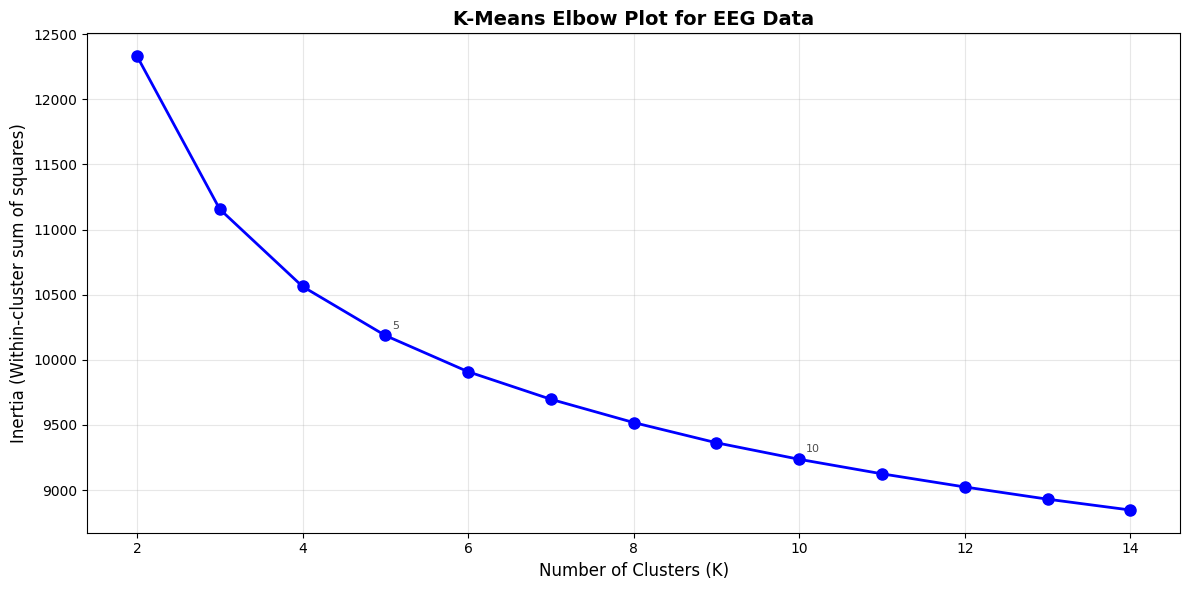


RATE OF CHANGE ANALYSIS
✓ Saved plot: EEG_kmeans_rate_of_change.png


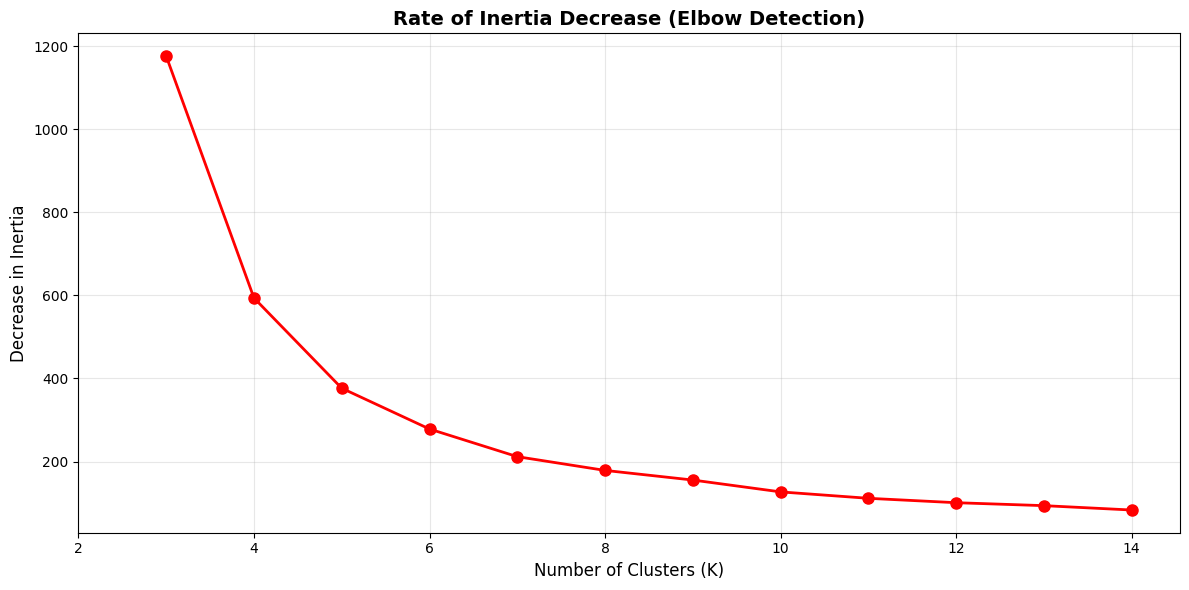


Suggested K values based on elbow analysis:
------------------------------------------------------------
  1. Largest elbow (max 2nd derivative): K = 4
  2. Top 3 rate of change points: K = [3, 4, 5]
  3. Stabilization point (< 5% max rate): K = 14

✅ COMPLETE! Review the plots to choose optimal K
✓ Saved combined plot: EEG_kmeans_combined_analysis.png


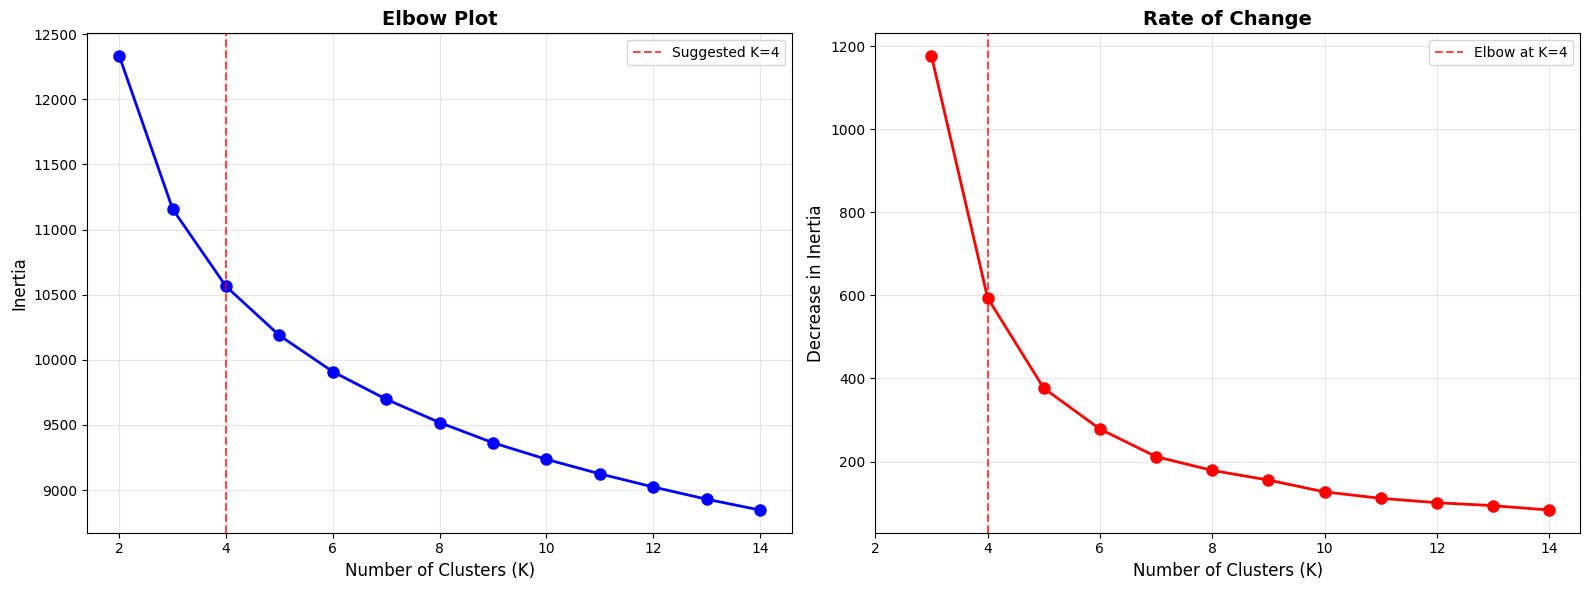

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Parameters
K_RANGE = range(2, 15)  # Test from 2 to 50 clusters
SEED = 100

# print("="*80)
# print("K-MEANS ELBOW PLOT (INERTIA) FOR EEG DATA")
# print("="*80)

# # Load EEG data (reuse from your previous code)
# EEG_data_dir = "data/EEG_data/HFD_PSD_4sec_75overlap_6min"
# fMRI_data_files = "/data/s.dharia-ra/PEARL/final_multi_modal/data/fMRI_data"

# # Get common subjects
# EEG_subjects = set([f"sub-{f.split('.')[0]}" for f in os.listdir(EEG_data_dir) if f.endswith('.npz')])
# fMRI_subjects = set([f.split('_')[0] for f in os.listdir(fMRI_data_files) if f.endswith('.npz')])
# common_subjects = EEG_subjects.intersection(fMRI_subjects)

# print(f"Loading EEG features for {len(common_subjects)} subjects...")
# eeg_data = load_eeg_features(EEG_data_dir, common_subjects)

print(f"EEG Data Shape: {eeg_data['X'].shape}")
print(f"Running K-means for K = {K_RANGE.start} to {K_RANGE.stop-1}...")

# Calculate inertia for different K values
inertias = []
k_values = list(K_RANGE)

for k in k_values:
    print(f"  Testing K = {k}...", end=" ")
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=5, max_iter=300)
    kmeans.fit(eeg_data['X'])
    inertias.append(kmeans.inertia_)
    print(f"Inertia = {kmeans.inertia_:.2f}")

# Plot the elbow curve
plt.figure(figsize=(12, 6))
plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
plt.title('K-Means Elbow Plot for EEG Data', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values[::2])  # Show every other K value on x-axis

# Add annotations for key points
for i, (k, inertia) in enumerate(zip(k_values, inertias)):
    if k % 5 == 0:  # Annotate every 5th point
        plt.annotate(f'{k}', 
                    xy=(k, inertia), 
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8,
                    alpha=0.7)

plt.tight_layout()
plt.savefig('EEG_kmeans_elbow_plot.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved plot: EEG_kmeans_elbow_plot.png")
plt.show()

# Calculate the rate of change (first derivative)
print("\n" + "="*80)
print("RATE OF CHANGE ANALYSIS")
print("="*80)

rates_of_change = []
for i in range(1, len(inertias)):
    rate = inertias[i-1] - inertias[i]
    rates_of_change.append(rate)
    
# Plot rate of change
plt.figure(figsize=(12, 6))
plt.plot(k_values[1:], rates_of_change, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Decrease in Inertia', fontsize=12)
plt.title('Rate of Inertia Decrease (Elbow Detection)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values[::2])

plt.tight_layout()
plt.savefig('EEG_kmeans_rate_of_change.png', dpi=300, bbox_inches='tight')
print("✓ Saved plot: EEG_kmeans_rate_of_change.png")
plt.show()

# Find potential elbow points (where rate of change decreases significantly)
second_derivative = []
for i in range(1, len(rates_of_change)):
    second_deriv = rates_of_change[i-1] - rates_of_change[i]
    second_derivative.append(second_deriv)

# Suggest optimal K values
print("\nSuggested K values based on elbow analysis:")
print("-" * 60)

# Method 1: Largest rate of change decrease
max_second_deriv_idx = np.argmax(second_derivative)
suggested_k1 = k_values[max_second_deriv_idx + 2]  # +2 due to double derivative offset
print(f"  1. Largest elbow (max 2nd derivative): K = {suggested_k1}")

# Method 2: Top 3 rate of change values
top_3_indices = np.argsort(rates_of_change)[-3:][::-1]
top_3_k = [k_values[i+1] for i in top_3_indices]
print(f"  2. Top 3 rate of change points: K = {top_3_k}")

# Method 3: Where rate of change stabilizes (< 5% of max rate)
threshold = max(rates_of_change) * 0.05
stabilization_idx = next((i for i, rate in enumerate(rates_of_change) if rate < threshold), len(rates_of_change)-1)
suggested_k3 = k_values[stabilization_idx + 1]
print(f"  3. Stabilization point (< 5% max rate): K = {suggested_k3}")

print("\n" + "="*80)
print("✅ COMPLETE! Review the plots to choose optimal K")
print("="*80)

# Optional: Create a combined visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Inertia
ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values[::2])

# Mark suggested K values
ax1.axvline(x=suggested_k1, color='r', linestyle='--', alpha=0.7, label=f'Suggested K={suggested_k1}')
ax1.legend()

# Right plot: Rate of change
ax2.plot(k_values[1:], rates_of_change, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
ax2.set_ylabel('Decrease in Inertia', fontsize=12)
ax2.set_title('Rate of Change', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values[::2])

# Mark suggested K values
ax2.axvline(x=suggested_k1, color='r', linestyle='--', alpha=0.7, label=f'Elbow at K={suggested_k1}')
ax2.legend()

plt.tight_layout()
plt.savefig('EEG_kmeans_combined_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved combined plot: EEG_kmeans_combined_analysis.png")
plt.show()

In [ ]:
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal, shapiro, levene
import pandas as pd
import numpy as np
import os
import glob

# Parameters
P_VALUE_THRESHOLD = 0.05

def load_eeg_features(feature_dir, common_subjects):
    """Load EEG features from extracted HFD/PSD files"""
    all_features = []
    all_labels = []
    all_sub_ids = []
    
    npz_files = glob.glob(os.path.join(feature_dir, '*.npz'))
    
    for npz_file in npz_files:
        subject_number = os.path.basename(npz_file).split('.')[0]
        subject_id = f'sub-{subject_number}'
        
        if subject_id not in common_subjects:
            continue
            
        try:
            data = np.load(npz_file, allow_pickle=True)
            
            hfd_features = data['HFD_features']
            psd_features = data['PSD_features']
            labels = data['label']
            
            num_windows = hfd_features.shape[0]
            
            for w in range(num_windows):
                window_hfd = hfd_features[w].flatten()
                window_psd = psd_features[w].flatten()
                window_features = np.concatenate([window_hfd, window_psd])
                
                all_features.append(window_features)
                all_labels.append(labels[w])
                all_sub_ids.append(int(subject_number))
                
            print(f"Loaded {num_windows} windows from {subject_id}")
            
        except Exception as e:
            print(f"Error loading {npz_file}: {e}")
            continue
    
    return {
        'X': np.array(all_features),
        'y': np.array(all_labels),
        'sub_ids': np.array(all_sub_ids)
    }

def aggregate_subject_features(X_data, y_data, sub_ids_data):
    """Aggregate features per subject (mean across windows)"""
    unique_subjects = np.unique(sub_ids_data)
    subject_features = []
    subject_labels = []
    
    for subject in unique_subjects:
        subject_mask = sub_ids_data == subject
        subject_windows = X_data[subject_mask]
        subject_label = y_data[subject_mask][0]
        
        # Average across all windows for this subject
        subject_mean_features = np.median(subject_windows, axis=0)
        
        subject_features.append(subject_mean_features)
        subject_labels.append(subject_label)
    
    return np.array(subject_features), np.array(subject_labels), unique_subjects

def choose_statistical_test(groups):
    """Choose appropriate statistical test based on data distribution"""
    if len(groups) < 2 or any(g.size == 0 for g in groups):
        return 'None', 1.0, 0.0
    
    try:
        normality_ok = all(shapiro(g)[1] > 0.05 for g in groups if len(g) >= 3)
        equal_var_ok = levene(*groups)[1] > 0.05
        
        if normality_ok and equal_var_ok:
            if len(groups) == 2:
                stat, p_val = ttest_ind(*groups)
                return 't-test', p_val, stat
            else:
                stat, p_val = f_oneway(*groups)
                return 'ANOVA', p_val, stat
        else:
            if len(groups) == 2:
                stat, p_val = mannwhitneyu(*groups)
                return 'Mann-Whitney', p_val, stat
            else:
                stat, p_val = kruskal(*groups)
                return 'Kruskal-Wallis', p_val, stat
    except:
        return 'None', 1.0, 0.0

def determine_dominant_group(feature_values, labels):
    """Determine which risk group has highest mean for this feature"""
    unique_labels = np.unique(labels)
    label_to_group = {0: 'N', 1: 'AposPminus', 2: 'AposPpos'}
    
    group_means = {}
    for label in unique_labels:
        group_values = feature_values[labels == label]
        group_means[label] = np.mean(group_values)
    
    dominant_label = max(group_means, key=group_means.get)
    dominant_group = label_to_group[dominant_label]
    
    return dominant_group, group_means

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("="*80)
print("RAW EEG FEATURE ANALYSIS - NO CLUSTERING")
print("="*80)

# Load participant data
EEG_data_dir = "data/EEG_data/HFD_PSD_4sec_75overlap_6min"
fMRI_data_files = "/data/s.dharia-ra/PEARL/final_multi_modal/data/fMRI_data"

# Get common subjects
EEG_subjects = set([f"sub-{f.split('.')[0]}" for f in os.listdir(EEG_data_dir) if f.endswith('.npz')])
fMRI_subjects = set([f.split('_')[0] for f in os.listdir(fMRI_data_files) if f.endswith('.npz')])
common_subjects = EEG_subjects.intersection(fMRI_subjects)

print(f"\nNumber of subjects with both EEG and fMRI data: {len(common_subjects)}")

# Load participant information
df = pd.read_csv("./participants.tsv", sep="\t")

# Create risk groups
conditions = [
    (~df['APOE_haplotype'].str.contains('e4', case=False)) & (df['PICALM_rs3851179'] != 'G/G'),
    (df['APOE_haplotype'].str.contains('e4', case=False)) & (df['PICALM_rs3851179'] != 'G/G'),
    (df['APOE_haplotype'].str.contains('e4', case=False)) & (df['PICALM_rs3851179'] == 'G/G')
]
choices = ['N', 'A+P-', 'A+P+']
df['Risk_Group'] = np.select(conditions, choices, default='Excluded')

df.loc[(df['APOE_haplotype'].str.contains('e2', case=False)) & 
       (~df['APOE_haplotype'].str.contains('e4', case=False)) & 
       (df['Risk_Group'] == 'N'), 'Risk_Group'] = 'Excluded'

study_df = df[df['Risk_Group'].isin(['N', 'A+P-', 'A+P+'])].copy()
study_df['Has_EEG_fMRI'] = study_df['participant_id'].apply(lambda x: x in common_subjects)
final_df = study_df[study_df['Has_EEG_fMRI']].copy()

print(f"Final dataframe shape: {final_df.shape}")
print(f"Classes distribution:\n{final_df['Risk_Group'].value_counts()}")

participant_to_idx = {pid: idx for idx, pid in enumerate(final_df['participant_id'])}

# Load EEG features
print("\nLoading EEG features...")
eeg_data = load_eeg_features(EEG_data_dir, common_subjects)

print(f"\nEEG Data Shape:")
print(f"  Features: {eeg_data['X'].shape}")
print(f"  Labels: {eeg_data['y'].shape}")
print(f"  Unique subjects: {len(np.unique(eeg_data['sub_ids']))}")

# ============================================================================
# AGGREGATE FEATURES PER SUBJECT
# ============================================================================

print("\n" + "="*80)
print("AGGREGATING FEATURES PER SUBJECT (MEAN ACROSS WINDOWS)")
print("="*80)

subject_features, subject_labels, subject_ids = aggregate_subject_features(
    eeg_data['X'], 
    eeg_data['y'], 
    eeg_data['sub_ids']
)

print(f"Subject features shape: {subject_features.shape}")
print(f"Subject labels shape: {subject_labels.shape}")

# ============================================================================
# TEST EACH RAW FEATURE
# ============================================================================

print("\n" + "="*80)
print("TESTING EACH RAW EEG FEATURE FOR SIGNIFICANCE")
print("="*80)

n_features = subject_features.shape[1]
significant_features = []

print(f"\nTesting {n_features} features...")
print(f"This may take a moment...\n")

for feature_idx in range(n_features):
    feature_values = subject_features[:, feature_idx]
    
    # Test across groups
    groups = [feature_values[subject_labels == label] for label in np.unique(subject_labels)]
    test_name, p_value, stat = choose_statistical_test(groups)
    
    if p_value < P_VALUE_THRESHOLD:
        dominant_group, group_means = determine_dominant_group(feature_values, subject_labels)
        
        print(f"  Feature {feature_idx}: p={p_value:.6f} *** ({dominant_group} higher)")
        
        significant_features.append({
            'feature_idx': feature_idx,
            'p_value': p_value,
            'test': test_name,
            'dominant_group': dominant_group,
            'group_means': group_means,
            'feature_values': feature_values
        })

print(f"\n" + "="*80)
print(f"FOUND {len(significant_features)} SIGNIFICANT RAW EEG FEATURES")
print("="*80)

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("SAVING SIGNIFICANT RAW FEATURES")
print("="*80)

output_dir = "EEG_raw_significant_features"
os.makedirs(output_dir, exist_ok=True)

for idx, feat in enumerate(significant_features, 1):
    filename = (f"raw_feature_{feat['feature_idx']}_"
               f"{feat['dominant_group']}_higher_p{feat['p_value']:.6f}.npz")
    
    filepath = os.path.join(output_dir, filename)
    
    np.savez_compressed(
        filepath,
        feature_idx=feat['feature_idx'],
        p_value=feat['p_value'],
        test=feat['test'],
        dominant_group=feat['dominant_group'],
        group_means=feat['group_means'],
        feature_values=feat['feature_values'],
        subject_ids=subject_ids
    )
    
    print(f"{idx:3d}. {filename}")

# ============================================================================
# CREATE DATAFRAME
# ============================================================================

print("\n" + "="*80)
print("CREATING DATAFRAME WITH SIGNIFICANT RAW FEATURES")
print("="*80)

for feat in significant_features:
    feature_idx = feat['feature_idx']
    dominant_group = feat['dominant_group']
    p_val = feat['p_value']
    
    col_name = f'EEG_raw_feat{feature_idx}_{dominant_group}_higher'
    final_df[col_name] = np.nan
    final_df[f'{col_name}_pval'] = p_val
    final_df[f'{col_name}_test'] = feat['test']
    
    # Fill in values
    for i, subject_id in enumerate(subject_ids):
        participant_id = f'sub-{subject_id}'
        if participant_id in participant_to_idx:
            df_idx = participant_to_idx[participant_id]
            final_df.loc[final_df.index[df_idx], col_name] = feat['feature_values'][i]

# Add group mapping
group_mapping = {'N': 0, 'A+P-': 1, 'A+P+': 2}
final_df['Group'] = final_df['Risk_Group'].map(group_mapping)

# Save dataframe
output_csv = "EEG_raw_significant_features.csv"
final_df.to_csv(output_csv, index=False)

print(f"\n✓ Saved dataframe: {output_csv}")
print(f"  Shape: {final_df.shape}")
print(f"  Significant feature columns: {len(significant_features)}")

# ============================================================================
# SUMMARY REPORT
# ============================================================================

print("\n" + "="*80)
print("RAW EEG FEATURE SUMMARY REPORT")
print("="*80)

from collections import Counter

print(f"\nTotal significant raw features: {len(significant_features)}")

# By dominant group
dominant_counts = Counter([f['dominant_group'] for f in significant_features])
print(f"\nFeatures by dominant group:")
for group, count in dominant_counts.items():
    print(f"  {group} has higher values: {count} features")

# P-value statistics
if len(significant_features) > 0:
    p_values = [f['p_value'] for f in significant_features]
    print(f"\nP-value statistics:")
    print(f"  Min: {min(p_values):.6f}")
    print(f"  Max: {max(p_values):.6f}")
    print(f"  Mean: {np.mean(p_values):.6f}")
    print(f"  Median: {np.median(p_values):.6f}")
    
    # Top 10 most significant features
    print(f"\nTop 10 most significant features:")
    sorted_features = sorted(significant_features, key=lambda x: x['p_value'])[:10]
    for i, feat in enumerate(sorted_features, 1):
        print(f"  {i}. Feature {feat['feature_idx']}: p={feat['p_value']:.6f} ({feat['dominant_group']} higher)")

print("\n" + "="*80)
print("✅ COMPLETE! Raw EEG feature analysis done")
print("="*80)

RAW EEG FEATURE ANALYSIS - NO CLUSTERING

Number of subjects with both EEG and fMRI data: 56
Final dataframe shape: (56, 89)
Classes distribution:
Risk_Group
A+P-    23
N       17
A+P+    16
Name: count, dtype: int64

Loading EEG features...
Loaded 357 windows from sub-13
Loaded 357 windows from sub-21
Loaded 357 windows from sub-67
Loaded 357 windows from sub-59
Loaded 357 windows from sub-76
Loaded 357 windows from sub-16
Loaded 357 windows from sub-57
Loaded 357 windows from sub-33
Loaded 357 windows from sub-39
Loaded 357 windows from sub-25
Loaded 357 windows from sub-24
Loaded 357 windows from sub-26
Loaded 357 windows from sub-44
Loaded 357 windows from sub-37
Loaded 357 windows from sub-54
Loaded 357 windows from sub-75
Loaded 357 windows from sub-64
Loaded 357 windows from sub-56
Loaded 357 windows from sub-49
Loaded 357 windows from sub-35
Loaded 357 windows from sub-79
Loaded 357 windows from sub-47
Loaded 357 windows from sub-14
Loaded 357 windows from sub-62
Loaded 357 win

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal, shapiro, levene

# Parameters
P_VALUE_THRESHOLD = 0.05

# EEG bands
BAND_NAMES = ['delta', 'theta', 'alpha', 'beta', 'gamma']
N_CHANNELS = 127
N_BANDS = 5

def load_eeg_features_structured(feature_dir, common_subjects):
    """Load EEG features and keep HFD/PSD structure"""
    subject_data = []
    
    npz_files = glob.glob(os.path.join(feature_dir, '*.npz'))
    
    for npz_file in npz_files:
        subject_number = os.path.basename(npz_file).split('.')[0]
        subject_id = f'sub-{subject_number}'
        
        if subject_id not in common_subjects:
            continue
            
        try:
            data = np.load(npz_file, allow_pickle=True)
            
            hfd_features = data['HFD_features']  # (n_windows, n_channels, n_bands)
            psd_features = data['PSD_features']  # (n_windows, n_channels, n_bands)
            label = data['label'][0]  # Get first label (same for all windows)
            
            # Average across all windows for this subject
            hfd_mean = np.median(hfd_features, axis=0)  # (n_channels, n_bands)
            psd_mean = np.median(psd_features, axis=0)  # (n_channels, n_bands)
            
            subject_data.append({
                'subject_id': subject_id,
                'subject_number': int(subject_number),
                'label': label,
                'hfd': hfd_mean,
                'psd': psd_mean
            })
            
            print(f"Loaded {subject_id}: {hfd_features.shape[0]} windows averaged")
            
        except Exception as e:
            print(f"Error loading {npz_file}: {e}")
            continue
    
    return subject_data

def create_feature_dataframe(subject_data, final_df, participant_to_idx):
    """Create dataframe with structured feature columns"""
    
    # Initialize dataframe with subject info
    result_df = final_df[['participant_id', 'Risk_Group']].copy()
    result_df['Group'] = result_df['Risk_Group'].map({'N': 0, 'A+P-': 1, 'A+P+': 2})
    
    # Create column names for all features
    feature_columns = []
    
    # HFD features: HFD_ch{channel}_{band}
    for ch in range(N_CHANNELS):
        for band_idx, band_name in enumerate(BAND_NAMES):
            col_name = f'HFD_ch{ch}_{band_name}'
            feature_columns.append(col_name)
            result_df[col_name] = np.nan
    
    # PSD features: PSD_ch{channel}_{band}
    for ch in range(N_CHANNELS):
        for band_idx, band_name in enumerate(BAND_NAMES):
            col_name = f'PSD_ch{ch}_{band_name}'
            feature_columns.append(col_name)
            result_df[col_name] = np.nan
    
    # Fill in data for each subject
    for subj in subject_data:
        subject_id = subj['subject_id']
        
        if subject_id not in participant_to_idx:
            continue
            
        df_idx = participant_to_idx[subject_id]
        row_idx = result_df.index[df_idx]
        
        # Fill HFD features
        for ch in range(N_CHANNELS):
            for band_idx, band_name in enumerate(BAND_NAMES):
                col_name = f'HFD_ch{ch}_{band_name}'
                value = subj['hfd'][ch, band_idx]
                result_df.loc[row_idx, col_name] = value
        
        # Fill PSD features
        for ch in range(N_CHANNELS):
            for band_idx, band_name in enumerate(BAND_NAMES):
                col_name = f'PSD_ch{ch}_{band_name}'
                value = subj['psd'][ch, band_idx]
                result_df.loc[row_idx, col_name] = value
    
    return result_df, feature_columns

def test_features_for_significance(result_df, feature_columns):
    """Test each feature for group differences"""
    
    significant_results = []
    
    print("\n" + "="*80)
    print("TESTING FEATURES FOR SIGNIFICANCE")
    print("="*80)
    
    for col_name in feature_columns:
        # Get values for each group
        values = result_df[col_name].values
        groups_labels = result_df['Group'].values
        
        # Skip if any NaN
        if np.any(np.isnan(values)):
            continue
        
        # Create groups
        group_0 = values[groups_labels == 0]  # N
        group_1 = values[groups_labels == 1]  # A+P-
        group_2 = values[groups_labels == 2]  # A+P+
        
        groups = [group_0, group_1, group_2]
        
        # Statistical test
        try:
            normality_ok = all(shapiro(g)[1] > 0.05 for g in groups if len(g) >= 3)
            equal_var_ok = levene(*groups)[1] > 0.05
            
            if normality_ok and equal_var_ok:
                stat, p_value = f_oneway(*groups)
                test_name = 'ANOVA'
            else:
                stat, p_value = kruskal(*groups)
                test_name = 'Kruskal-Wallis'
        except:
            continue
        
        # If significant, record it
        if p_value < P_VALUE_THRESHOLD:
            # Find dominant group
            means = [np.mean(g) for g in groups]
            dominant_idx = np.argmax(means)
            dominant_group = ['N', 'A+P-', 'A+P+'][dominant_idx]
            
            significant_results.append({
                'feature': col_name,
                'p_value': p_value,
                'test': test_name,
                'dominant_group': dominant_group,
                'mean_N': means[0],
                'mean_AposPminus': means[1],
                'mean_AposPpos': means[2]
            })
            
            print(f"✓ {col_name}: p={p_value:.6f} ({dominant_group} higher)")
    
    return significant_results

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("="*80)
print("STRUCTURED EEG FEATURE ANALYSIS")
print("="*80)

# Load participant data
EEG_data_dir = "data/EEG_data/HFD_PSD_4sec_75overlap_6min"
fMRI_data_files = "/data/s.dharia-ra/PEARL/final_multi_modal/data/fMRI_data"

# Get common subjects
EEG_subjects = set([f"sub-{f.split('.')[0]}" for f in os.listdir(EEG_data_dir) if f.endswith('.npz')])
fMRI_subjects = set([f.split('_')[0] for f in os.listdir(fMRI_data_files) if f.endswith('.npz')])
common_subjects = EEG_subjects.intersection(fMRI_subjects)

print(f"\nNumber of subjects with both EEG and fMRI data: {len(common_subjects)}")

# Load participant information
df = pd.read_csv("./participants.tsv", sep="\t")

# Create risk groups
conditions = [
    (~df['APOE_haplotype'].str.contains('e4', case=False)) & (df['PICALM_rs3851179'] != 'G/G'),
    (df['APOE_haplotype'].str.contains('e4', case=False)) & (df['PICALM_rs3851179'] != 'G/G'),
    (df['APOE_haplotype'].str.contains('e4', case=False)) & (df['PICALM_rs3851179'] == 'G/G')
]
choices = ['N', 'A+P-', 'A+P+']
df['Risk_Group'] = np.select(conditions, choices, default='Excluded')

df.loc[(df['APOE_haplotype'].str.contains('e2', case=False)) & 
       (~df['APOE_haplotype'].str.contains('e4', case=False)) & 
       (df['Risk_Group'] == 'N'), 'Risk_Group'] = 'Excluded'

study_df = df[df['Risk_Group'].isin(['N', 'A+P-', 'A+P+'])].copy()
study_df['Has_EEG_fMRI'] = study_df['participant_id'].apply(lambda x: x in common_subjects)
final_df = study_df[study_df['Has_EEG_fMRI']].copy()

print(f"Final dataframe shape: {final_df.shape}")
print(f"Classes distribution:\n{final_df['Risk_Group'].value_counts()}")

participant_to_idx = {pid: idx for idx, pid in enumerate(final_df['participant_id'])}

# Load EEG features with structure
print("\n" + "="*80)
print("LOADING STRUCTURED EEG FEATURES")
print("="*80)

subject_data = load_eeg_features_structured(EEG_data_dir, common_subjects)
print(f"\nLoaded data for {len(subject_data)} subjects")

# Create structured dataframe
print("\n" + "="*80)
print("CREATING STRUCTURED DATAFRAME")
print("="*80)

result_df, feature_columns = create_feature_dataframe(subject_data, final_df, participant_to_idx)

print(f"\nDataframe shape: {result_df.shape}")
print(f"Total features: {len(feature_columns)}")
print(f"  HFD features: {N_CHANNELS * N_BANDS} (127 channels × 5 bands)")
print(f"  PSD features: {N_CHANNELS * N_BANDS} (127 channels × 5 bands)")

# Save full dataframe
output_csv = "EEG_structured_features_all.csv"
result_df.to_csv(output_csv, index=False)
print(f"\n✓ Saved full dataframe: {output_csv}")

# Test for significance
significant_results = test_features_for_significance(result_df, feature_columns)

# Save significant features summary
if len(significant_results) > 0:
    sig_df = pd.DataFrame(significant_results)
    sig_df = sig_df.sort_values('p_value')
    sig_df.to_csv("EEG_significant_features_summary.csv", index=False)
    
    print(f"\n" + "="*80)
    print(f"FOUND {len(significant_results)} SIGNIFICANT FEATURES")
    print("="*80)
    
    print(f"\nTop 10 most significant features:")
    for i, row in sig_df.head(10).iterrows():
        print(f"  {row['feature']}: p={row['p_value']:.6f} ({row['dominant_group']} higher)")
    
    print(f"\n✓ Saved significance summary: EEG_significant_features_summary.csv")
else:
    print("\nNo significant features found at p < 0.05")

print("\n" + "="*80)
print("✅ COMPLETE!")
print("="*80)
print(f"\nOutput files:")
print(f"  1. {output_csv} - Full dataframe with all EEG features")
print(f"  2. EEG_significant_features_summary.csv - Summary of significant features")

STRUCTURED EEG FEATURE ANALYSIS

Number of subjects with both EEG and fMRI data: 56
Final dataframe shape: (56, 89)
Classes distribution:
Risk_Group
A+P-    23
N       17
A+P+    16
Name: count, dtype: int64

LOADING STRUCTURED EEG FEATURES
Loaded sub-13: 357 windows averaged
Loaded sub-21: 357 windows averaged
Loaded sub-67: 357 windows averaged
Loaded sub-59: 357 windows averaged
Loaded sub-76: 357 windows averaged
Loaded sub-16: 357 windows averaged
Loaded sub-57: 357 windows averaged
Loaded sub-33: 357 windows averaged
Loaded sub-39: 357 windows averaged
Loaded sub-25: 357 windows averaged
Loaded sub-24: 357 windows averaged
Loaded sub-26: 357 windows averaged
Loaded sub-44: 357 windows averaged
Loaded sub-37: 357 windows averaged
Loaded sub-54: 357 windows averaged
Loaded sub-75: 357 windows averaged
Loaded sub-64: 357 windows averaged
Loaded sub-56: 357 windows averaged
Loaded sub-49: 357 windows averaged
Loaded sub-35: 357 windows averaged
Loaded sub-79: 357 windows averaged
Loa

/tmp/ipykernel_1893277/3333807626.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[col_name] = np.nan
/tmp/ipykernel_1893277/3333807626.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[col_name] = np.nan
/tmp/ipykernel_1893277/3333807626.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 


Dataframe shape: (56, 1273)
Total features: 1270
  HFD features: 635 (127 channels × 5 bands)
  PSD features: 635 (127 channels × 5 bands)

✓ Saved full dataframe: EEG_structured_features_all.csv

TESTING FEATURES FOR SIGNIFICANCE
✓ HFD_ch19_delta: p=0.042230 (N higher)
✓ HFD_ch34_delta: p=0.024800 (N higher)
✓ HFD_ch55_delta: p=0.034638 (N higher)
✓ HFD_ch59_delta: p=0.028515 (N higher)
✓ HFD_ch60_delta: p=0.022072 (N higher)
✓ HFD_ch74_beta: p=0.041684 (N higher)
✓ HFD_ch75_beta: p=0.046079 (N higher)
✓ HFD_ch94_gamma: p=0.033073 (N higher)
✓ HFD_ch95_delta: p=0.024898 (N higher)
✓ HFD_ch100_gamma: p=0.049041 (N higher)
✓ HFD_ch101_delta: p=0.014984 (N higher)
✓ HFD_ch118_delta: p=0.024165 (N higher)
✓ PSD_ch8_delta: p=0.023497 (N higher)
✓ PSD_ch20_beta: p=0.018647 (N higher)
✓ PSD_ch30_gamma: p=0.029182 (N higher)
✓ PSD_ch58_theta: p=0.049032 (N higher)
✓ PSD_ch67_delta: p=0.033034 (N higher)
✓ PSD_ch100_beta: p=0.024671 (N higher)
✓ PSD_ch107_beta: p=0.041786 (N higher)
✓ PSD_ch1

XGboost


BINARY XGBOOST CLASSIFICATION: N vs A+P+

Number of subjects with both EEG and fMRI data: 56
Final dataframe shape: (56, 89)
Classes distribution:
Risk_Group
A+P-    23
N       17
A+P+    16
Name: count, dtype: int64

Risk group mapping created for 56 subjects:
  N: 17
  A+P-: 23
  A+P+: 16

LOADING EEG FEATURES WITH CORRECT LABELS
Loaded sub-13: N (label=0)
Loaded sub-21: N (label=0)
Loaded sub-67: A+P- (label=1)
Loaded sub-59: A+P- (label=1)
Loaded sub-76: A+P- (label=1)
Loaded sub-16: N (label=0)
Loaded sub-57: A+P- (label=1)
Loaded sub-33: A+P+ (label=2)
Loaded sub-39: A+P+ (label=2)
Loaded sub-25: N (label=0)
Loaded sub-24: N (label=0)
Loaded sub-26: N (label=0)
Loaded sub-44: A+P+ (label=2)
Loaded sub-37: A+P+ (label=2)
Loaded sub-54: A+P+ (label=2)
Loaded sub-75: A+P- (label=1)
Loaded sub-64: A+P- (label=1)
Loaded sub-56: A+P+ (label=2)
Loaded sub-49: A+P+ (label=2)
Loaded sub-35: A+P+ (label=2)
Loaded sub-79: A+P- (label=1)
Loaded sub-47: A+P- (label=1)
Loaded sub-14: N (label=

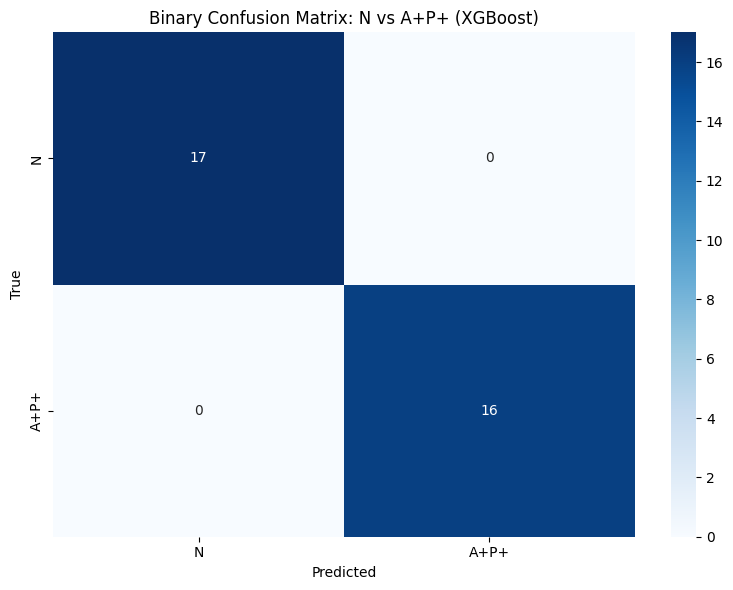


TOP 20 MOST IMPORTANT FEATURES

Top 20 features:
   1. PSD_ch58_theta: 0.077887
   2. HFD_ch32_beta: 0.044110
   3. PSD_ch5_alpha: 0.043631
   4. HFD_ch119_beta: 0.042481
   5. PSD_ch16_beta: 0.039216
   6. HFD_ch30_delta: 0.037137
   7. PSD_ch74_beta: 0.035955
   8. HFD_ch25_delta: 0.034148
   9. HFD_ch59_delta: 0.027592
  10. HFD_ch24_delta: 0.027590
  11. HFD_ch23_delta: 0.024804
  12. HFD_ch108_beta: 0.024446
  13. HFD_ch105_delta: 0.023588
  14. HFD_ch117_alpha: 0.023014
  15. PSD_ch27_theta: 0.022262
  16. PSD_ch92_delta: 0.021582
  17. HFD_ch23_gamma: 0.021244
  18. HFD_ch90_delta: 0.021158
  19. PSD_ch119_gamma: 0.020814
  20. PSD_ch65_delta: 0.020772

✓ Saved feature importance plot: EEG_xgboost_binary_feature_importance.png


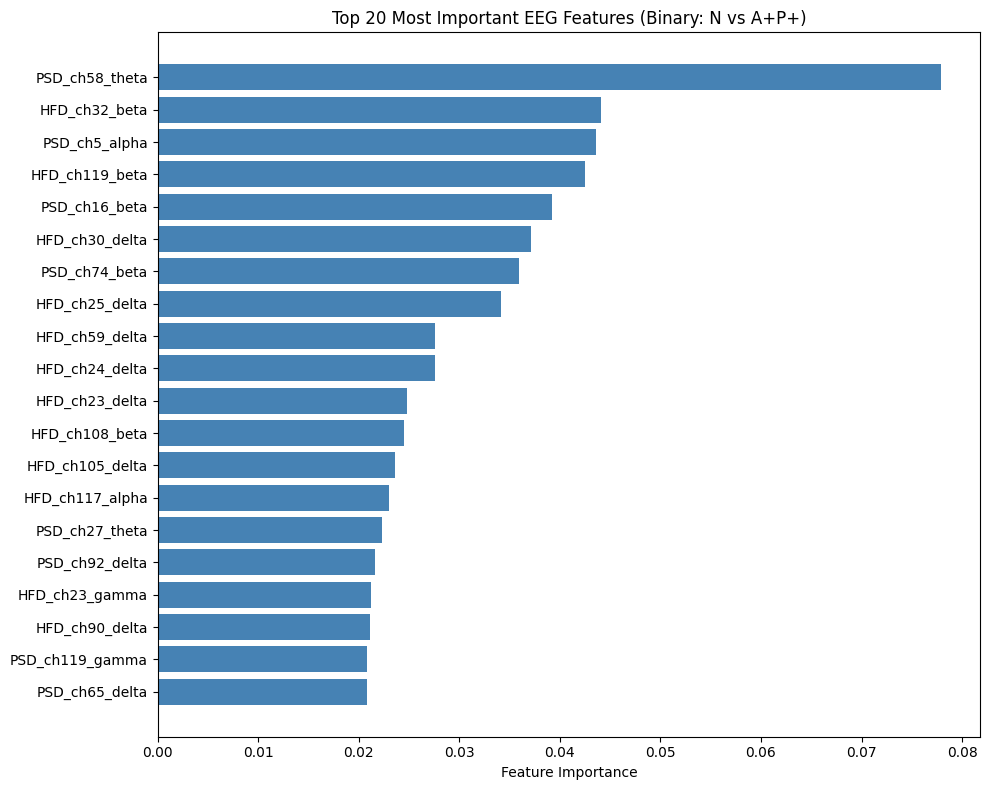


SAVING RESULTS
✓ Saved predictions: EEG_xgboost_binary_predictions.csv
✓ Saved feature importance: EEG_xgboost_binary_feature_importance.csv
✓ Saved model: EEG_xgboost_binary_model.pkl
✓ Saved scaler: EEG_xgboost_binary_scaler.pkl

✅ COMPLETE! Binary XGBoost classification finished (N vs A+P+)


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
N_FOLDS = 5
RANDOM_STATE = 42
N_CHANNELS = 127
N_BANDS = 5
BAND_NAMES = ['delta', 'theta', 'alpha', 'beta', 'gamma']

def load_eeg_features_structured(feature_dir, common_subjects, risk_group_map):
    """Load EEG features and assign correct labels from participants.tsv"""
    subject_data = []
    
    npz_files = glob.glob(os.path.join(feature_dir, '*.npz'))
    
    for npz_file in npz_files:
        subject_number = os.path.basename(npz_file).split('.')[0]
        subject_id = f'sub-{subject_number}'
        
        if subject_id not in common_subjects:
            continue
        
        # Get correct label from participants.tsv
        if subject_id not in risk_group_map:
            print(f"⚠️ Warning: {subject_id} not found in participants.tsv")
            continue
            
        correct_label = risk_group_map[subject_id]
        
        try:
            data = np.load(npz_file, allow_pickle=True)
            
            hfd_features = data['HFD_features']
            psd_features = data['PSD_features']
            
            # Average across all windows
            hfd_mean = np.median(hfd_features, axis=0)
            psd_mean = np.median(psd_features, axis=0)
            
            subject_data.append({
                'subject_id': subject_id,
                'subject_number': int(subject_number),
                'label': correct_label,  # USE CORRECT LABEL FROM TSV
                'hfd': hfd_mean,
                'psd': psd_mean
            })
            
            risk_name = {0: 'N', 1: 'A+P-', 2: 'A+P+'}[correct_label]
            print(f"Loaded {subject_id}: {risk_name} (label={correct_label})")
            
        except Exception as e:
            print(f"Error loading {npz_file}: {e}")
            continue
    
    return subject_data

def create_feature_matrix(subject_data, binary_classes=[0, 2]):
    """Create feature matrix - BINARY CLASSIFICATION ONLY"""
    
    # Filter to only include specified classes
    filtered_data = [s for s in subject_data if s['label'] in binary_classes]
    
    print(f"\nFiltered to binary classification:")
    print(f"  Class 0 (N): {sum(1 for s in filtered_data if s['label'] == 0)}")
    print(f"  Class 2 (A+P+): {sum(1 for s in filtered_data if s['label'] == 2)}")
    
    n_subjects = len(filtered_data)
    n_features = N_CHANNELS * N_BANDS * 2  # HFD + PSD
    
    X = np.zeros((n_subjects, n_features))
    y = np.zeros(n_subjects, dtype=int)
    subject_ids = []
    
    for i, subj in enumerate(filtered_data):
        # Flatten HFD and PSD features
        hfd_flat = subj['hfd'].flatten()
        psd_flat = subj['psd'].flatten()
        
        # Concatenate HFD and PSD
        X[i] = np.concatenate([hfd_flat, psd_flat])
        
        # Binary label: 0 = N, 1 = A+P+
        y[i] = 0 if subj['label'] == 0 else 1
        subject_ids.append(subj['subject_id'])
    
    return X, y, subject_ids

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("="*80)
print("BINARY XGBOOST CLASSIFICATION: N vs A+P+")
print("="*80)

# Load participant data
EEG_data_dir = "data/EEG_data/HFD_PSD_4sec_75overlap_6min"
fMRI_data_files = "/data/s.dharia-ra/PEARL/final_multi_modal/data/fMRI_data"

# Get common subjects
EEG_subjects = set([f"sub-{f.split('.')[0]}" for f in os.listdir(EEG_data_dir) if f.endswith('.npz')])
fMRI_subjects = set([f.split('_')[0] for f in os.listdir(fMRI_data_files) if f.endswith('.npz')])
common_subjects = EEG_subjects.intersection(fMRI_subjects)

print(f"\nNumber of subjects with both EEG and fMRI data: {len(common_subjects)}")

# Load participant information
df = pd.read_csv("./participants.tsv", sep="\t")

# Create risk groups
conditions = [
    (~df['APOE_haplotype'].str.contains('e4', case=False)) & (df['PICALM_rs3851179'] != 'G/G'),
    (df['APOE_haplotype'].str.contains('e4', case=False)) & (df['PICALM_rs3851179'] != 'G/G'),
    (df['APOE_haplotype'].str.contains('e4', case=False)) & (df['PICALM_rs3851179'] == 'G/G')
]
choices = ['N', 'A+P-', 'A+P+']
df['Risk_Group'] = np.select(conditions, choices, default='Excluded')

df.loc[(df['APOE_haplotype'].str.contains('e2', case=False)) & 
       (~df['APOE_haplotype'].str.contains('e4', case=False)) & 
       (df['Risk_Group'] == 'N'), 'Risk_Group'] = 'Excluded'

study_df = df[df['Risk_Group'].isin(['N', 'A+P-', 'A+P+'])].copy()
study_df['Has_EEG_fMRI'] = study_df['participant_id'].apply(lambda x: x in common_subjects)
final_df = study_df[study_df['Has_EEG_fMRI']].copy()

print(f"Final dataframe shape: {final_df.shape}")
print(f"Classes distribution:\n{final_df['Risk_Group'].value_counts()}")

# CREATE RISK GROUP MAPPING (participant_id -> numeric label)
group_mapping = {'N': 0, 'A+P-': 1, 'A+P+': 2}
risk_group_map = dict(zip(final_df['participant_id'], 
                          final_df['Risk_Group'].map(group_mapping)))

print(f"\nRisk group mapping created for {len(risk_group_map)} subjects:")
print(f"  N: {sum(1 for v in risk_group_map.values() if v == 0)}")
print(f"  A+P-: {sum(1 for v in risk_group_map.values() if v == 1)}")
print(f"  A+P+: {sum(1 for v in risk_group_map.values() if v == 2)}")

# Load EEG features WITH CORRECT LABELS
print("\n" + "="*80)
print("LOADING EEG FEATURES WITH CORRECT LABELS")
print("="*80)

subject_data = load_eeg_features_structured(EEG_data_dir, common_subjects, risk_group_map)
print(f"\nLoaded data for {len(subject_data)} subjects")

# Verify labels
label_counts = {}
for s in subject_data:
    label_counts[s['label']] = label_counts.get(s['label'], 0) + 1

print(f"\nLabel distribution after loading:")
for label, count in sorted(label_counts.items()):
    risk_name = {0: 'N', 1: 'A+P-', 2: 'A+P+'}[label]
    print(f"  {risk_name} (label={label}): {count}")

# Create BINARY feature matrix (N vs A+P+ only)
print("\n" + "="*80)
print("CREATING BINARY FEATURE MATRIX (N vs A+P+)")
print("="*80)

X, y, subject_ids = create_feature_matrix(subject_data, binary_classes=[0, 2])

print(f"\nFeature matrix shape: {X.shape}")
print(f"  Total features: {X.shape[1]}")
print(f"  HFD features: {N_CHANNELS * N_BANDS}")
print(f"  PSD features: {N_CHANNELS * N_BANDS}")
print(f"\nBinary label distribution:")
print(f"  Class 0 (N): {np.sum(y == 0)}")
print(f"  Class 1 (A+P+): {np.sum(y == 1)}")

# Check if we have both classes
if len(np.unique(y)) < 2:
    print("\n⚠️ ERROR: Only one class present in the data!")
    print("Cannot perform binary classification with a single class.")
else:
    # ============================================================================
    # BINARY XGBOOST CLASSIFICATION
    # ============================================================================
    
    print("\n" + "="*80)
    print("TRAINING BINARY XGBOOST CLASSIFIER")
    print("="*80)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Manual cross-validation
    print(f"\nPerforming {N_FOLDS}-fold cross-validation...")
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    
    train_accuracies = []
    test_accuracies = []
    train_f1_scores = []
    test_f1_scores = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_scaled, y), 1):
        print(f"  Fold {fold_idx}/{N_FOLDS}...", end=" ")
        
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train binary classifier
        model = xgb.XGBClassifier(
            n_estimators=500,
            max_depth=50,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            objective='binary:logistic'
        )
        
        model.fit(X_train, y_train, verbose=False)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_f1_scores.append(train_f1)
        test_f1_scores.append(test_f1)
        
        print(f"Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")
    
    print("\n" + "="*80)
    print("CROSS-VALIDATION RESULTS")
    print("="*80)
    
    print(f"\nAccuracy:")
    print(f"  Train: {np.mean(train_accuracies):.4f} ± {np.std(train_accuracies):.4f}")
    print(f"  Test:  {np.mean(test_accuracies):.4f} ± {np.std(test_accuracies):.4f}")
    
    print(f"\nF1-Score:")
    print(f"  Train: {np.mean(train_f1_scores):.4f} ± {np.std(train_f1_scores):.4f}")
    print(f"  Test:  {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")
    
    # Train final model on all data
    print("\n" + "="*80)
    print("TRAINING FINAL BINARY MODEL ON ALL DATA")
    print("="*80)
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        objective='binary:logistic'
    )
    
    xgb_model.fit(X_scaled, y, verbose=False)
    y_pred = xgb_model.predict(X_scaled)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['N', 'A+P+']))
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['N', 'A+P+'],
                yticklabels=['N', 'A+P+'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Binary Confusion Matrix: N vs A+P+ (XGBoost)')
    plt.tight_layout()
    plt.savefig('EEG_xgboost_binary_confusion_matrix.png', dpi=300)
    print("\n✓ Saved confusion matrix: EEG_xgboost_binary_confusion_matrix.png")
    plt.show()
    
    # Feature importance
    print("\n" + "="*80)
    print("TOP 20 MOST IMPORTANT FEATURES")
    print("="*80)
    
    feature_importance = xgb_model.feature_importances_
    feature_names = []
    
    # Create feature names
    for ch in range(N_CHANNELS):
        for band in BAND_NAMES:
            feature_names.append(f'HFD_ch{ch}_{band}')
    for ch in range(N_CHANNELS):
        for band in BAND_NAMES:
            feature_names.append(f'PSD_ch{ch}_{band}')
    
    # Get top 20 features
    top_indices = np.argsort(feature_importance)[-20:][::-1]
    top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]
    
    print("\nTop 20 features:")
    for i, (name, importance) in enumerate(top_features, 1):
        print(f"  {i:2d}. {name}: {importance:.6f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(range(20), [imp for _, imp in top_features], color='steelblue')
    plt.yticks(range(20), [name for name, _ in top_features])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important EEG Features (Binary: N vs A+P+)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('EEG_xgboost_binary_feature_importance.png', dpi=300)
    print("\n✓ Saved feature importance plot: EEG_xgboost_binary_feature_importance.png")
    plt.show()
    
    # Save results
    print("\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)
    
    # Save predictions
    results_df = pd.DataFrame({
        'subject_id': subject_ids,
        'true_label': ['N' if label == 0 else 'A+P+' for label in y],
        'predicted_label': ['N' if label == 0 else 'A+P+' for label in y_pred],
        'correct': y == y_pred
    })
    results_df.to_csv('EEG_xgboost_binary_predictions.csv', index=False)
    print("✓ Saved predictions: EEG_xgboost_binary_predictions.csv")
    
    # Save feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    importance_df.to_csv('EEG_xgboost_binary_feature_importance.csv', index=False)
    print("✓ Saved feature importance: EEG_xgboost_binary_feature_importance.csv")
    
    # Save model
    import joblib
    joblib.dump(xgb_model, 'EEG_xgboost_binary_model.pkl')
    joblib.dump(scaler, 'EEG_xgboost_binary_scaler.pkl')
    print("✓ Saved model: EEG_xgboost_binary_model.pkl")
    print("✓ Saved scaler: EEG_xgboost_binary_scaler.pkl")
    
    print("\n" + "="*80)
    print("✅ COMPLETE! Binary XGBoost classification finished (N vs A+P+)")
    print("="*80)